# Project 1

In [25]:
import pylab
import math
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import pmdarima as pm
import hvplot as hv
import warnings
import scipy.stats
from pathlib import Path
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from numpy.random import normal, seed
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import kstest_normal
from scipy.stats import shapiro, kstest, normaltest
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmspe, rmse
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose, STL

In [31]:
import warnings; warnings.filterwarnings('ignore')

# Company Tickers – Oil-Sensitive S&P 500 Firms

| Ticker | Company Name            | Description                                                    |
|--------|-------------------------|----------------------------------------------------------------|
| XOM    | ExxonMobil              | One of the largest publicly traded oil & gas companies         |
| CVX    | Chevron                 | Multinational energy corporation with global operations        |
| COP    | ConocoPhillips          | Independent energy company focused on oil & natural gas        |
| SLB    | Schlumberger            | Leading provider of oilfield services and technology           |
| PSX    | Phillips 66             | Diversified energy manufacturing and logistics company         |
| MPC    | Marathon Petroleum      | Downstream energy company focused on refining and marketing    |
| OXY    | Occidental Petroleum    | International oil & gas exploration and production company     |
| HAL    | Halliburton             | Provider of products and services to the energy industry       |
| BKR    | Baker Hughes            | Energy technology company offering oilfield services & systems |
| VLO    | Valero Energy           | Independent petroleum refiner and ethanol producer             |

---

## Exogenous Variables

- **Brent_Oil (`BNO`)**  
  *ETF proxy for Brent crude oil spot prices.*  
  Used to represent the cost of crude oil globally.

- **CPI_Proxy (`TIP`)**  
  *ETF tracking U.S. Treasury Inflation-Protected Securities (TIPS).*  
  Used as a **proxy for the Consumer Price Index (CPI)**, which measures **inflation** by tracking the average change in prices paid by consumers over time.

---

## Notes
- Data sourced from **Yahoo Finance** using Python's `yfinance` library.
- All values are **daily close prices**, auto-adjusted for splits/dividends.


https://fred.stlouisfed.org/series/DCOILBRENTEU

In [15]:
tickers = ['XOM', 'CVX', 'COP', 'SLB', 'PSX', 'MPC', 'OXY', 'HAL', 'BKR', 'VLO']
stock_data = yf.download(tickers, start='2010-01-01', auto_adjust=True)['Close']
oil = yf.download('BNO', start='2010-01-01', auto_adjust=True)['Close']
if isinstance(oil, pd.Series):
    oil = oil.to_frame('Brent_Oil')
else:
    oil = oil.rename(columns={'Close': 'Brent_Oil'})
cpi = yf.download('TIP', start='2010-01-01', auto_adjust=True)['Close']
if isinstance(cpi, pd.Series):
    cpi = cpi.to_frame('CPI_Proxy')
else:
    cpi = cpi.rename(columns={'Close': 'CPI_Proxy'})
combined = stock_data.join([oil, cpi], how='inner')
combined = combined.dropna()

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [41]:
# combined.head()

In [27]:
df_sp500 = combined.copy()

In [43]:
df_sp500.head()

Ticker            BKR        COP        CVX        HAL        MPC        OXY  \
Date                                                                           
2012-04-12  21.904327  36.383297  60.334942  26.616873  14.254814  58.949986   
2012-04-13  21.526760  35.943951  59.270470  25.999189  14.207026  57.300255   
2012-04-16  21.395668  36.041584  59.699780  25.718422  13.657454  56.452755   
2012-04-17  21.778473  36.251495  60.940693  26.199732  13.650628  57.403778   
2012-04-18  21.663101  35.777973  60.805428  27.411045  13.606255  56.912083   

Ticker            PSX        SLB        VLO        XOM        BNO        TIP  
Date                                                                          
2012-04-12  22.093212  50.645214  14.319397  49.746807  42.880001  87.242447  
2012-04-13  24.042603  49.234013  13.865639  49.360001  42.820000  87.610367  
2012-04-16  23.750200  48.557198  13.417614  49.990753  41.744999  87.558876  
2012-04-17  23.392815  49.932407  13.831172  50.847645  41.849998  87.750160  
2012-04-18  23.392815  50.350010  13.716294  51.026165  41.634998  87.647141

In [45]:
df_sp500.tail()

Ticker            BKR        COP         CVX        HAL         MPC  \
Date                                                                  
2025-04-11  37.930000  86.389999  135.630005  21.070000  123.430000   
2025-04-14  37.810001  86.449997  135.320007  21.250000  124.849998   
2025-04-15  38.160000  85.720001  134.539993  21.250000  122.230003   
2025-04-16  38.130001  86.360001  135.360001  21.430000  124.070000   
2025-04-17  38.910000  88.980003  137.869995  22.530001  127.720001   

Ticker            OXY        PSX        SLB         VLO         XOM  \
Date                                                                  
2025-04-11  37.669998  97.379997  33.959999  110.699997  103.139999   
2025-04-14  37.900002  97.820000  33.919998  110.330002  103.389999   
2025-04-15  37.799999  96.209999  33.759998  107.550003  103.099998   
2025-04-16  38.450001  96.570000  34.150002  107.129997  104.190002   
2025-04-17  39.709999  99.099998  35.110001  110.059998  106.919998   

Ticker            BNO         TIP  
Date                               
2025-04-11  26.969999  107.970001  
2025-04-14  27.110001  108.489998  
2025-04-15  27.040001  108.480003  
2025-04-16  27.559999  108.779999  
2025-04-17  28.190001  109.029999

In [35]:
file_path = Path('CrudeOilPricesBrent-Europe.csv')

In [80]:
df_oil = pd.read_csv(file_path, sep=',')

In [82]:
df_oil.head()

observation_date  DCOILBRENTEU
0       2010-01-04         79.05
1       2010-01-05         79.27
2       2010-01-06         80.14
3       2010-01-07         80.57
4       2010-01-08         80.06

In [84]:
df_oil.tail()

observation_date  DCOILBRENTEU
3981       2025-04-08         64.86
3982       2025-04-09         67.30
3983       2025-04-10         65.37
3984       2025-04-11         66.83
3985       2025-04-14         67.18

In [56]:
df_sp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3274 entries, 2012-04-12 to 2025-04-17
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BKR     3274 non-null   float64
 1   COP     3274 non-null   float64
 2   CVX     3274 non-null   float64
 3   HAL     3274 non-null   float64
 4   MPC     3274 non-null   float64
 5   OXY     3274 non-null   float64
 6   PSX     3274 non-null   float64
 7   SLB     3274 non-null   float64
 8   VLO     3274 non-null   float64
 9   XOM     3274 non-null   float64
 10  BNO     3274 non-null   float64
 11  TIP     3274 non-null   float64
dtypes: float64(12)
memory usage: 332.5 KB


In [58]:
df_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3986 entries, 0 to 3985
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   observation_date  3986 non-null   object 
 1   DCOILBRENTEU      3868 non-null   float64
dtypes: float64(1), object(1)
memory usage: 62.4+ KB


In [60]:
df_sp500.isna().sum()

Ticker
BKR    0
COP    0
CVX    0
HAL    0
MPC    0
OXY    0
PSX    0
SLB    0
VLO    0
XOM    0
BNO    0
TIP    0
dtype: int64

In [62]:
df_oil.isna().sum()

observation_date      0
DCOILBRENTEU        118
dtype: int64

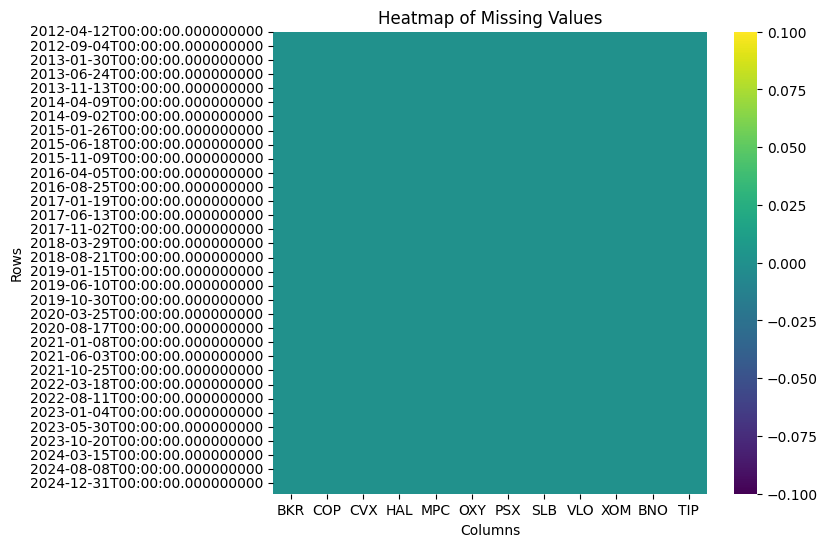

In [70]:
missing_values = df_sp500.isna()
missing_values_numeric = missing_values.astype(int)
plt.figure(figsize=(7, 6))
sns.heatmap(missing_values_numeric, cmap='viridis', cbar=True)
plt.title('Heatmap of Missing Values')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

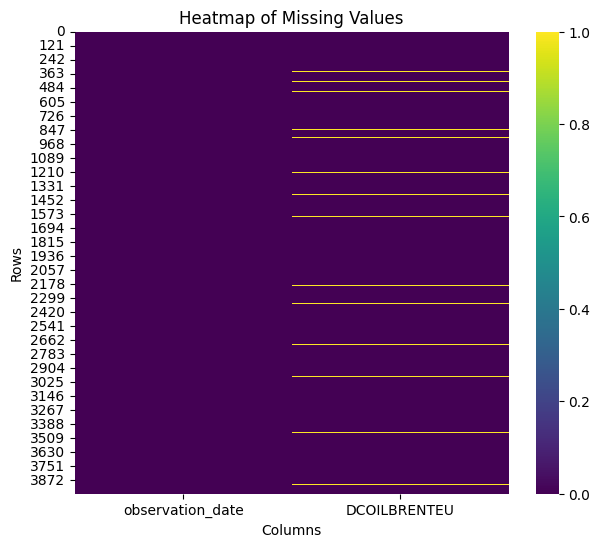

In [86]:
missing_values = df_oil.isna()
missing_values_numeric = missing_values.astype(int)
plt.figure(figsize=(7, 6))
sns.heatmap(missing_values_numeric, cmap='viridis', cbar=True)
plt.title('Heatmap of Missing Values')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

In [88]:
df_oil.interpolate(method='linear', inplace=True)

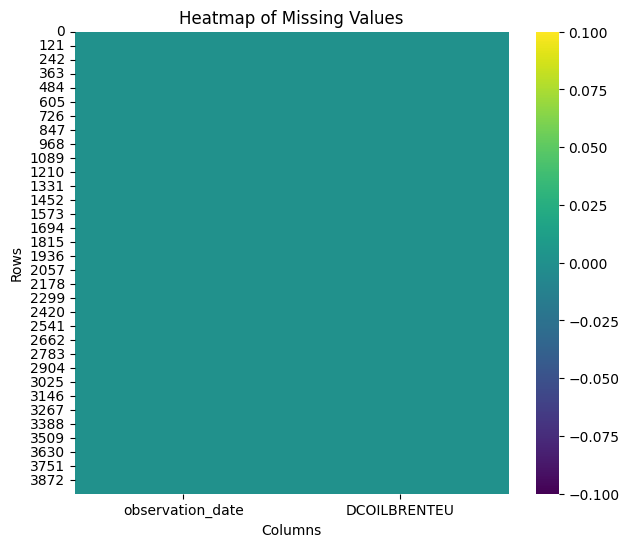

In [90]:
missing_values = df_oil.isna()
missing_values_numeric = missing_values.astype(int)
plt.figure(figsize=(7, 6))
sns.heatmap(missing_values_numeric, cmap='viridis', cbar=True)
plt.title('Heatmap of Missing Values')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

In [92]:
df_oil.isna().sum()

observation_date    0
DCOILBRENTEU        0
dtype: int64

### Checking for duplicates

In [99]:
# Check for duplicates in your DataFrame
duplicates = df_oil[df_oil.duplicated()]
print("Duplicates in df_oil:\n", duplicates)
# Check for duplicates in your second DataFrame
duplicates_sp500 = df_sp500[df_sp500.duplicated()]
print("Duplicates in df_sp500:\n", duplicates_sp500)

Duplicates in df_oil:
 Empty DataFrame
Columns: [observation_date, DCOILBRENTEU]
Index: []
Duplicates in df_sp500:
 Empty DataFrame
Columns: [BKR, COP, CVX, HAL, MPC, OXY, PSX, SLB, VLO, XOM, BNO, TIP]
Index: []


In [101]:
df_sp500.value_counts()

BKR        COP         CVX         HAL        MPC         OXY        PSX         SLB        VLO         XOM         BNO        TIP       
8.066179   20.374395   43.437885   4.851487   14.150804   9.265388   34.125328   11.580360  26.433687   24.809376   8.950000   98.966789     1
29.940552  34.508724   74.829399   36.631062  40.407097   48.625721  60.614906   52.416248  48.950031   56.433254   12.650000  89.688789     1
29.898672  33.851120   74.053207   36.544708  42.177498   47.788200  61.051720   52.392200  49.679653   56.055649   12.460000  88.986099     1
29.899509  47.199955   69.754089   32.052425  32.328918   56.703209  46.684032   62.700924  32.205357   57.881931   20.700001  86.983223     1
29.900370  109.814537  143.664139  35.380260  175.811157  59.742271  144.348206  49.099751  145.222153  104.841202  29.799999  104.246025    1
                                                                                                                                            ..
23.8

In [103]:
df_oil.value_counts()

observation_date  DCOILBRENTEU
2010-01-04        79.05           1
2020-03-18        22.79           1
2020-02-28        51.31           1
2020-03-02        52.52           1
2020-03-03        52.24           1
                                 ..
2015-02-12        56.23           1
2015-02-13        60.33           1
2015-02-16        61.57           1
2015-02-17        60.78           1
2025-04-14        67.18           1
Name: count, Length: 3986, dtype: int64

In [105]:
dfs = [df_sp500, df_oil]

In [111]:
for i in dfs:
    i.info()
    print('-*-*-*-')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3274 entries, 2012-04-12 to 2025-04-17
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BKR     3274 non-null   float64
 1   COP     3274 non-null   float64
 2   CVX     3274 non-null   float64
 3   HAL     3274 non-null   float64
 4   MPC     3274 non-null   float64
 5   OXY     3274 non-null   float64
 6   PSX     3274 non-null   float64
 7   SLB     3274 non-null   float64
 8   VLO     3274 non-null   float64
 9   XOM     3274 non-null   float64
 10  BNO     3274 non-null   float64
 11  TIP     3274 non-null   float64
dtypes: float64(12)
memory usage: 332.5 KB
-*-*-*-
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3986 entries, 0 to 3985
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   observation_date  3986 non-null   object 
 1   DCOILBRENTEU      3986 non-null   float64
dtypes: floa

In [117]:
# Total memory usage of the entire DataFrame
total_memory = df_oil.memory_usage(deep=True).sum() / (1024 ** 2)
print(f"Total memory usage: {total_memory:.2f} MB")

Total memory usage: 0.25 MB


In [123]:
# Check memory usage for df_sp500
df_sp500_memory = df_sp500.memory_usage(deep=True) / (1024 ** 2) 
print("Current memory usage per column in df_sp500:\n", df_sp500_memory)
# Check current memory usage for df_oil
df_oil_memory = df_oil.memory_usage(deep=True) / (1024 ** 2)  
print("Current memory usage per column in df_oil:\n", df_oil_memory)

Current memory usage per column in df_sp500:
 Index    0.024979
BKR      0.024979
COP      0.024979
CVX      0.024979
HAL      0.024979
MPC      0.024979
OXY      0.024979
PSX      0.024979
SLB      0.024979
VLO      0.024979
XOM      0.024979
BNO      0.024979
TIP      0.024979
dtype: float64
Current memory usage per column in df_oil:
 Index               0.000126
observation_date    0.224279
DCOILBRENTEU        0.030411
dtype: float64


In [129]:
df_sp500.index

DatetimeIndex(['2012-04-12', '2012-04-13', '2012-04-16', '2012-04-17',
               '2012-04-18', '2012-04-19', '2012-04-20', '2012-04-23',
               '2012-04-24', '2012-04-25',
               ...
               '2025-04-04', '2025-04-07', '2025-04-08', '2025-04-09',
               '2025-04-10', '2025-04-11', '2025-04-14', '2025-04-15',
               '2025-04-16', '2025-04-17'],
              dtype='datetime64[ns]', name='Date', length=3274, freq=None)

In [135]:
df_oil.index

RangeIndex(start=0, stop=3986, step=1)

In [133]:
print(df_sp500.index.freq)

None


In [139]:
# print(df_oil.index.freq)

In [141]:
df_oil['date'] = pd.to_datetime(df_oil.observation_date)

In [145]:
df_oil.set_index('date', inplace=True)

In [147]:
df_oil.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3986 entries, 2010-01-04 to 2025-04-14
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   observation_date  3986 non-null   object 
 1   DCOILBRENTEU      3986 non-null   float64
dtypes: float64(1), object(1)
memory usage: 93.4+ KB


In [151]:
df_oil.index

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2025-04-01', '2025-04-02', '2025-04-03', '2025-04-04',
               '2025-04-07', '2025-04-08', '2025-04-09', '2025-04-10',
               '2025-04-11', '2025-04-14'],
              dtype='datetime64[ns]', name='date', length=3986, freq=None)

In [153]:
del df_oil['observation_date']

In [159]:
df_oil.rename(columns={'DCOILBRENTEU': 'Price'}, inplace=True)

In [161]:
df_oil.head()

Price
date             
2010-01-04  79.05
2010-01-05  79.27
2010-01-06  80.14
2010-01-07  80.57
2010-01-08  80.06

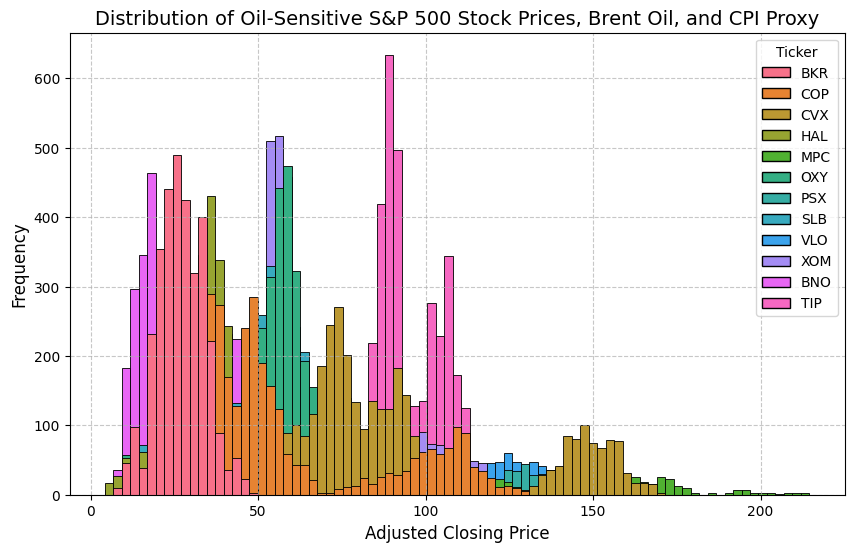

In [217]:
plt.figure(figsize=(10, 6)) 
sns.histplot(df_sp500, alpha=1, color='orange', edgecolor='black')
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.title('Distribution of Oil-Sensitive S&P 500 Stock Prices, Brent Oil, and CPI Proxy', fontsize=14)
plt.xlabel('Adjusted Closing Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

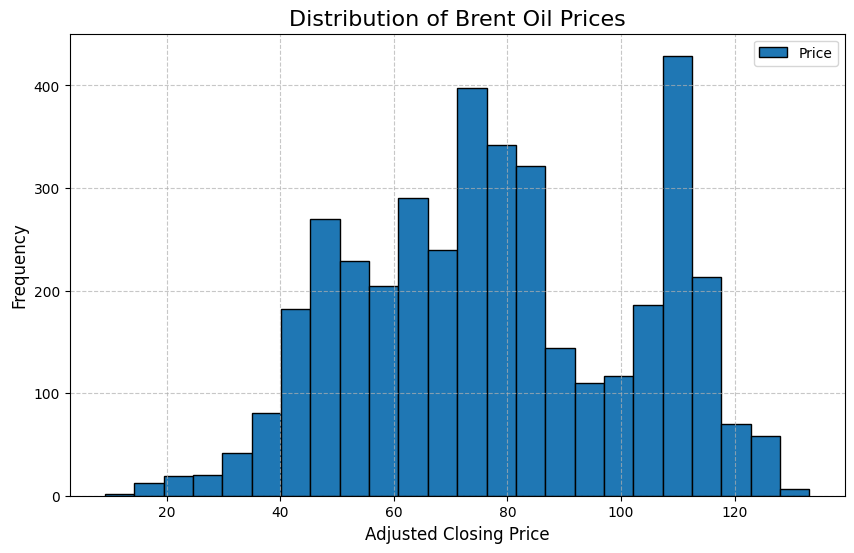

In [207]:
plt.figure(figsize=(10, 6))
sns.histplot(df_oil, alpha=1, color='orange', edgecolor='black')
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.title('Distribution of Brent Oil Prices', fontsize=16)
plt.xlabel('Adjusted Closing Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

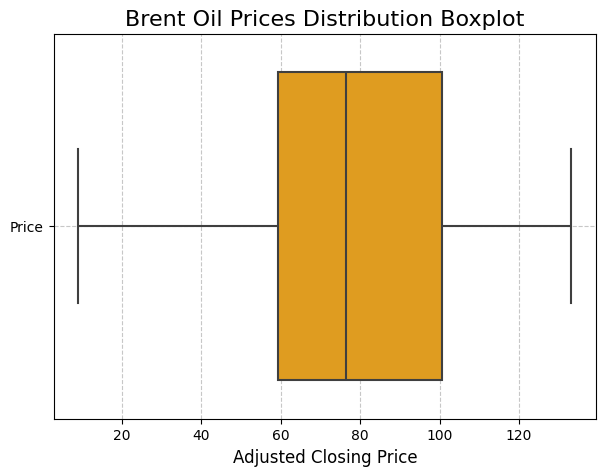

In [245]:
plt.figure(figsize=(7, 5))
sns.boxplot(data=df_oil, orient='h', whis=1.5, color='orange', linewidth=1.5, 
            flierprops={'markerfacecolor': 'black', 'markeredgecolor': 'black'})
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.title('Brent Oil Prices Distribution Boxplot', fontsize=16)
plt.xlabel('Adjusted Closing Price', fontsize=12)
plt.ylabel('')
plt.show()

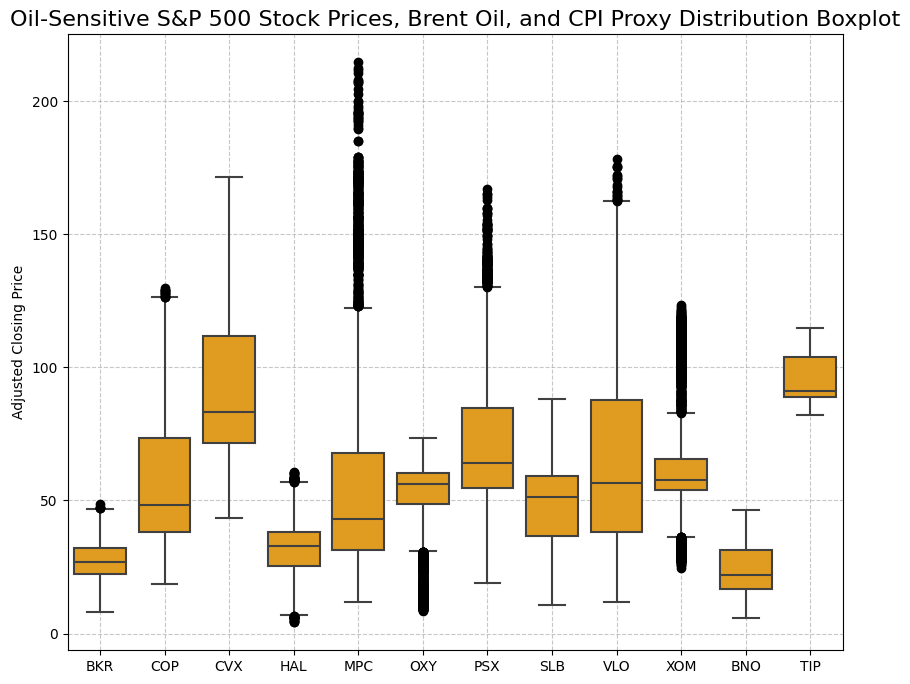

In [251]:
plt.figure(figsize=(10, 8))
sns.boxplot(data=df_sp500, orient='v', whis=1.5, color='orange', linewidth=1.5, 
            flierprops={'markerfacecolor': 'black', 'markeredgecolor': 'black'})
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.title('Oil-Sensitive S&P 500 Stock Prices, Brent Oil, and CPI Proxy Distribution Boxplot', fontsize=16)
plt.xlabel('', fontsize=12)
plt.ylabel('Adjusted Closing Price')
plt.show()

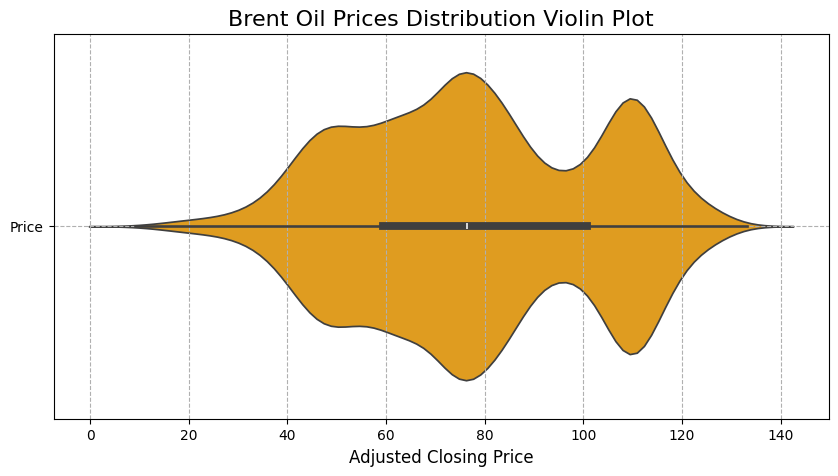

In [249]:
plt.figure(figsize=(10, 5))
sns.violinplot(df_oil, orient='h', alpha=1, color='orange')
plt.grid(visible=True, linestyle='--', alpha=1)
plt.title('Brent Oil Prices Distribution Violin Plot', fontsize=16)
plt.xlabel('Adjusted Closing Price', fontsize=12)
plt.ylabel('')
plt.show()

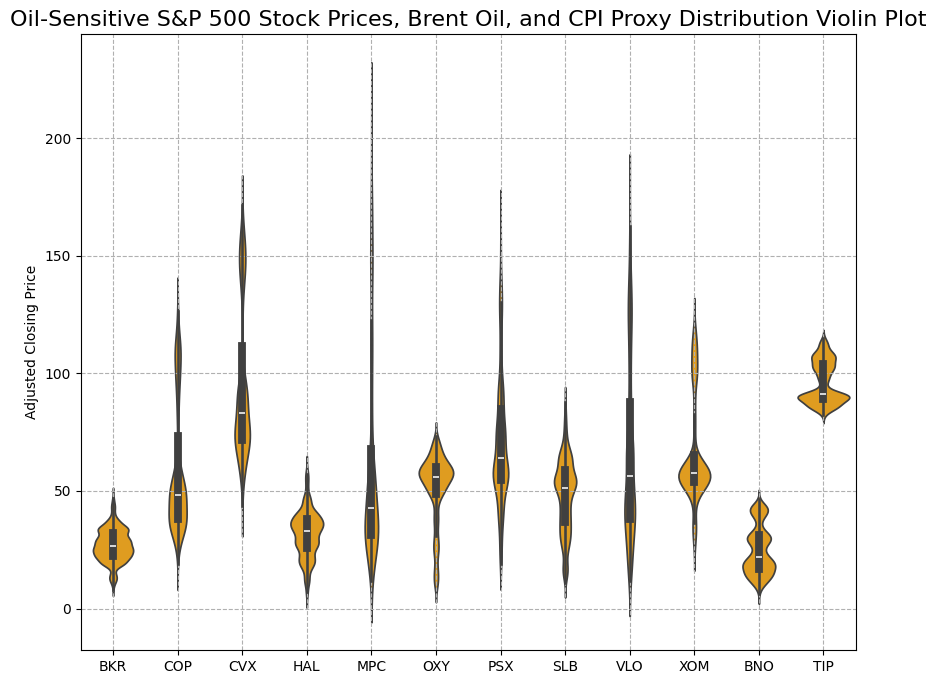

In [263]:
plt.figure(figsize=(10, 8))
sns.violinplot(df_sp500, orient='v', alpha=1, color='orange')
plt.grid(visible=True, linestyle='--', alpha=1)
plt.title('Oil-Sensitive S&P 500 Stock Prices, Brent Oil, and CPI Proxy Distribution Violin Plot', fontsize=16)
plt.xlabel('', fontsize=12)
plt.ylabel('Adjusted Closing Price')
plt.show()

In [265]:
def iqr_outliers(data):
    q1, q3 = np.percentile(data, [25, 75])  # Calculate the 25th and 75th percentiles
    IQR = q3 - q1  # Interquartile range
    lower_fence = q1 - (1.5 * IQR)  # Lower bound for outliers
    upper_fence = q3 + (1.5 * IQR)  # Upper bound for outliers
    return data[(data > upper_fence) | (data < lower_fence)] 

In [269]:
outliers_df_oil= iqr_outliers(df_oil.Price)
outliers_df_oil

Series([], Name: Price, dtype: float64)

In [275]:
outliers_df_sp500= iqr_outliers(df_sp500.BKR)
outliers_df_sp500

Date
2025-02-03    47.170052
2025-02-04    47.727333
2025-02-05    48.613014
2025-02-10    47.180000
2025-02-11    47.110001
Name: BKR, dtype: float64

In [277]:
columns = df_sp500.columns.to_list()

In [279]:
columns

['BKR',
 'COP',
 'CVX',
 'HAL',
 'MPC',
 'OXY',
 'PSX',
 'SLB',
 'VLO',
 'XOM',
 'BNO',
 'TIP']

In [299]:
for i in columns:
    outliers = iqr_outliers(df_sp500[i])
    print(f'Variable {i} >>>>>>>>')
    print(outliers)
    print()
    print()

Variable BKR >>>>>>>>
Date
2025-02-03    47.170052
2025-02-04    47.727333
2025-02-05    48.613014
2025-02-10    47.180000
2025-02-11    47.110001
Name: BKR, dtype: float64


Variable COP >>>>>>>>
Date
2024-04-02    126.986420
2024-04-03    127.919365
2024-04-04    128.035980
2024-04-05    129.756088
2024-04-08    128.687088
2024-04-09    128.521881
2024-04-10    129.075821
2024-04-11    129.172989
2024-04-12    127.501472
2024-04-15    126.578262
2024-04-26    126.568550
2024-04-29    126.549110
Name: COP, dtype: float64


Variable CVX >>>>>>>>
Series([], Name: CVX, dtype: float64)


Variable HAL >>>>>>>>
Date
2014-06-20    57.771301
2014-06-23    57.878220
2014-06-25    57.113312
2014-06-26    57.203785
2014-06-27    57.960457
2014-06-30    58.404613
2014-07-01    58.273010
2014-07-02    58.248344
2014-07-03    58.371704
2014-07-07    57.705494
2014-07-08    57.294266
2014-07-09    58.124962
2014-07-14    57.409409
2014-07-15    57.787754
2014-07-16    59.103710
2014-07-17    57.8617

In [301]:
def zscore(df, column_name, degree=3):
    data = df.copy()
    data['zscore'] = (data[column_name] - data[column_name].mean()) / data[column_name].std()
    outliers = data[(data['zscore'] <= -degree) | (data['zscore'] >= degree)]
    return outliers[column_name], data

In [317]:
threshold = 2
outliers, transformed_oil = zscore(df_oil, 'Price', threshold)

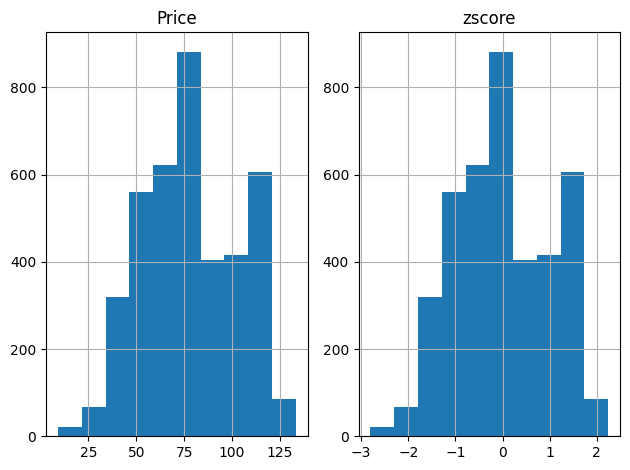

In [319]:
transformed_oil[['Price', 'zscore']].hist(); plt.tight_layout()

In [321]:
threshold = 2
outliers, transformed_cpi = zscore(df_sp500, 'TIP', threshold)

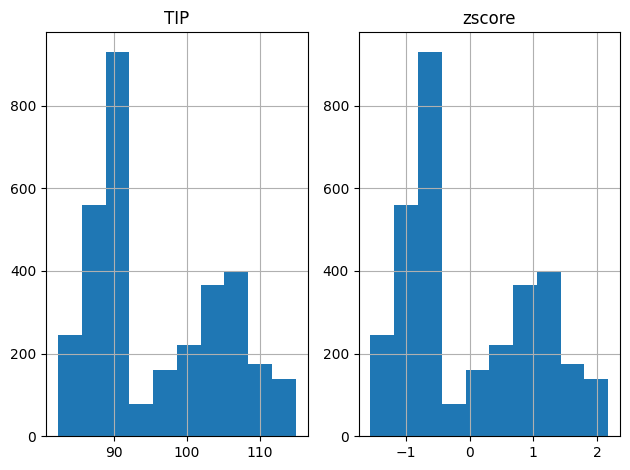

In [323]:
transformed_cpi[['TIP', 'zscore']].hist(); plt.tight_layout()

In [331]:
outliers, transformed_hal = zscore(df_sp500, 'HAL', threshold)

In [325]:
def plot_zscore(data, d=3):
    n = len(data)
    plt.figure(figsize=(10, 6))
    plt.plot(data, 'k^')
    plt.plot([0, n], [d, d], 'r--')
    plt.plot([0, n], [-d, -d], 'r--')

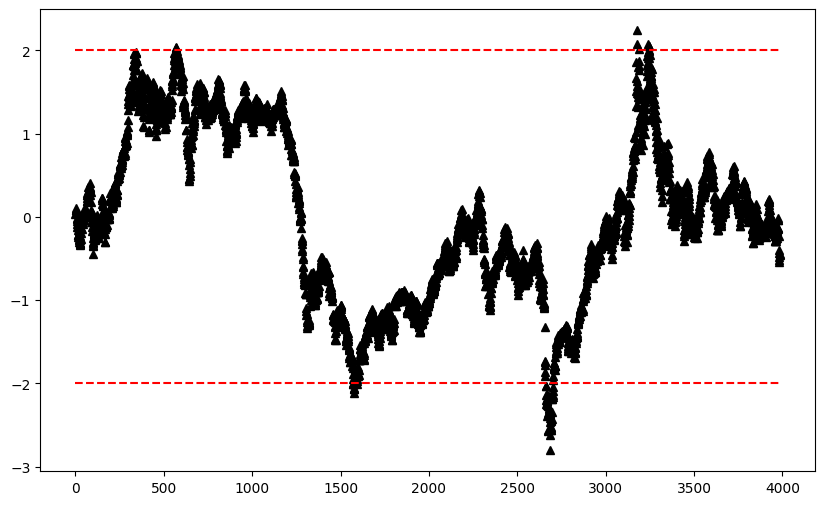

In [327]:
data = transformed_oil['zscore'].values
plot_zscore(data, d=2)

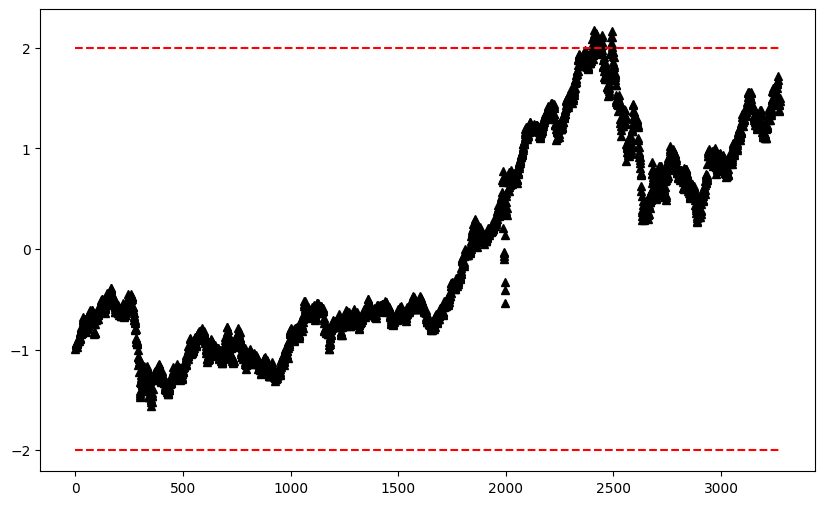

In [329]:
data = transformed_cpi['zscore'].values
plot_zscore(data, d=2)

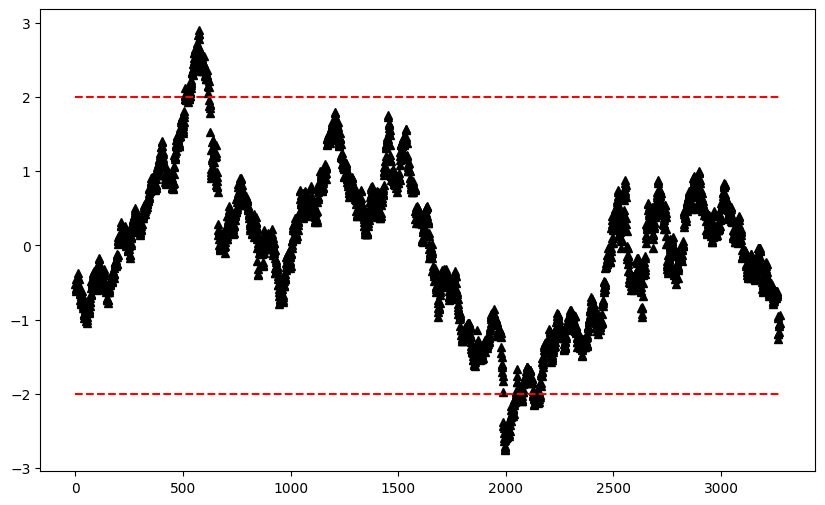

In [333]:
data = transformed_hal['zscore'].values
plot_zscore(data, d=2)

In [335]:
def test_normal(df):
    t_test, p_value = kstest_normal(df)
    if p_value < 0.05:
        print('Reject null hypothesis. Data is not normally distributed')
    else:
        print('Fail to reject null hypothesis. Data is normally distributed')

In [345]:
for i in columns:
    print(f'Variable {i}:')
    test_normal(df_sp500[i])

Variable BKR:
Reject null hypothesis. Data is not normally distributed
Variable COP:
Reject null hypothesis. Data is not normally distributed
Variable CVX:
Reject null hypothesis. Data is not normally distributed
Variable HAL:
Reject null hypothesis. Data is not normally distributed
Variable MPC:
Reject null hypothesis. Data is not normally distributed
Variable OXY:
Reject null hypothesis. Data is not normally distributed
Variable PSX:
Reject null hypothesis. Data is not normally distributed
Variable SLB:
Reject null hypothesis. Data is not normally distributed
Variable VLO:
Reject null hypothesis. Data is not normally distributed
Variable XOM:
Reject null hypothesis. Data is not normally distributed
Variable BNO:
Reject null hypothesis. Data is not normally distributed
Variable TIP:
Reject null hypothesis. Data is not normally distributed


In [347]:
test_normal(df_oil.Price)

Reject null hypothesis. Data is not normally distributed


In [349]:
from numpy.random import normal, seed
from scipy.stats import norm

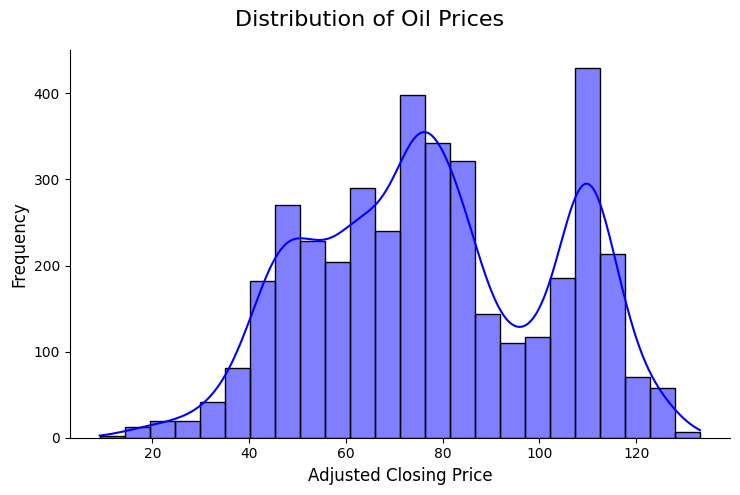

In [379]:
sns.displot(df_oil['Price'], kde=True, color='blue', height=5, aspect=1.5)
plt.suptitle('Distribution of Oil Prices', fontsize=16)
plt.xlabel('Adjusted Closing Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

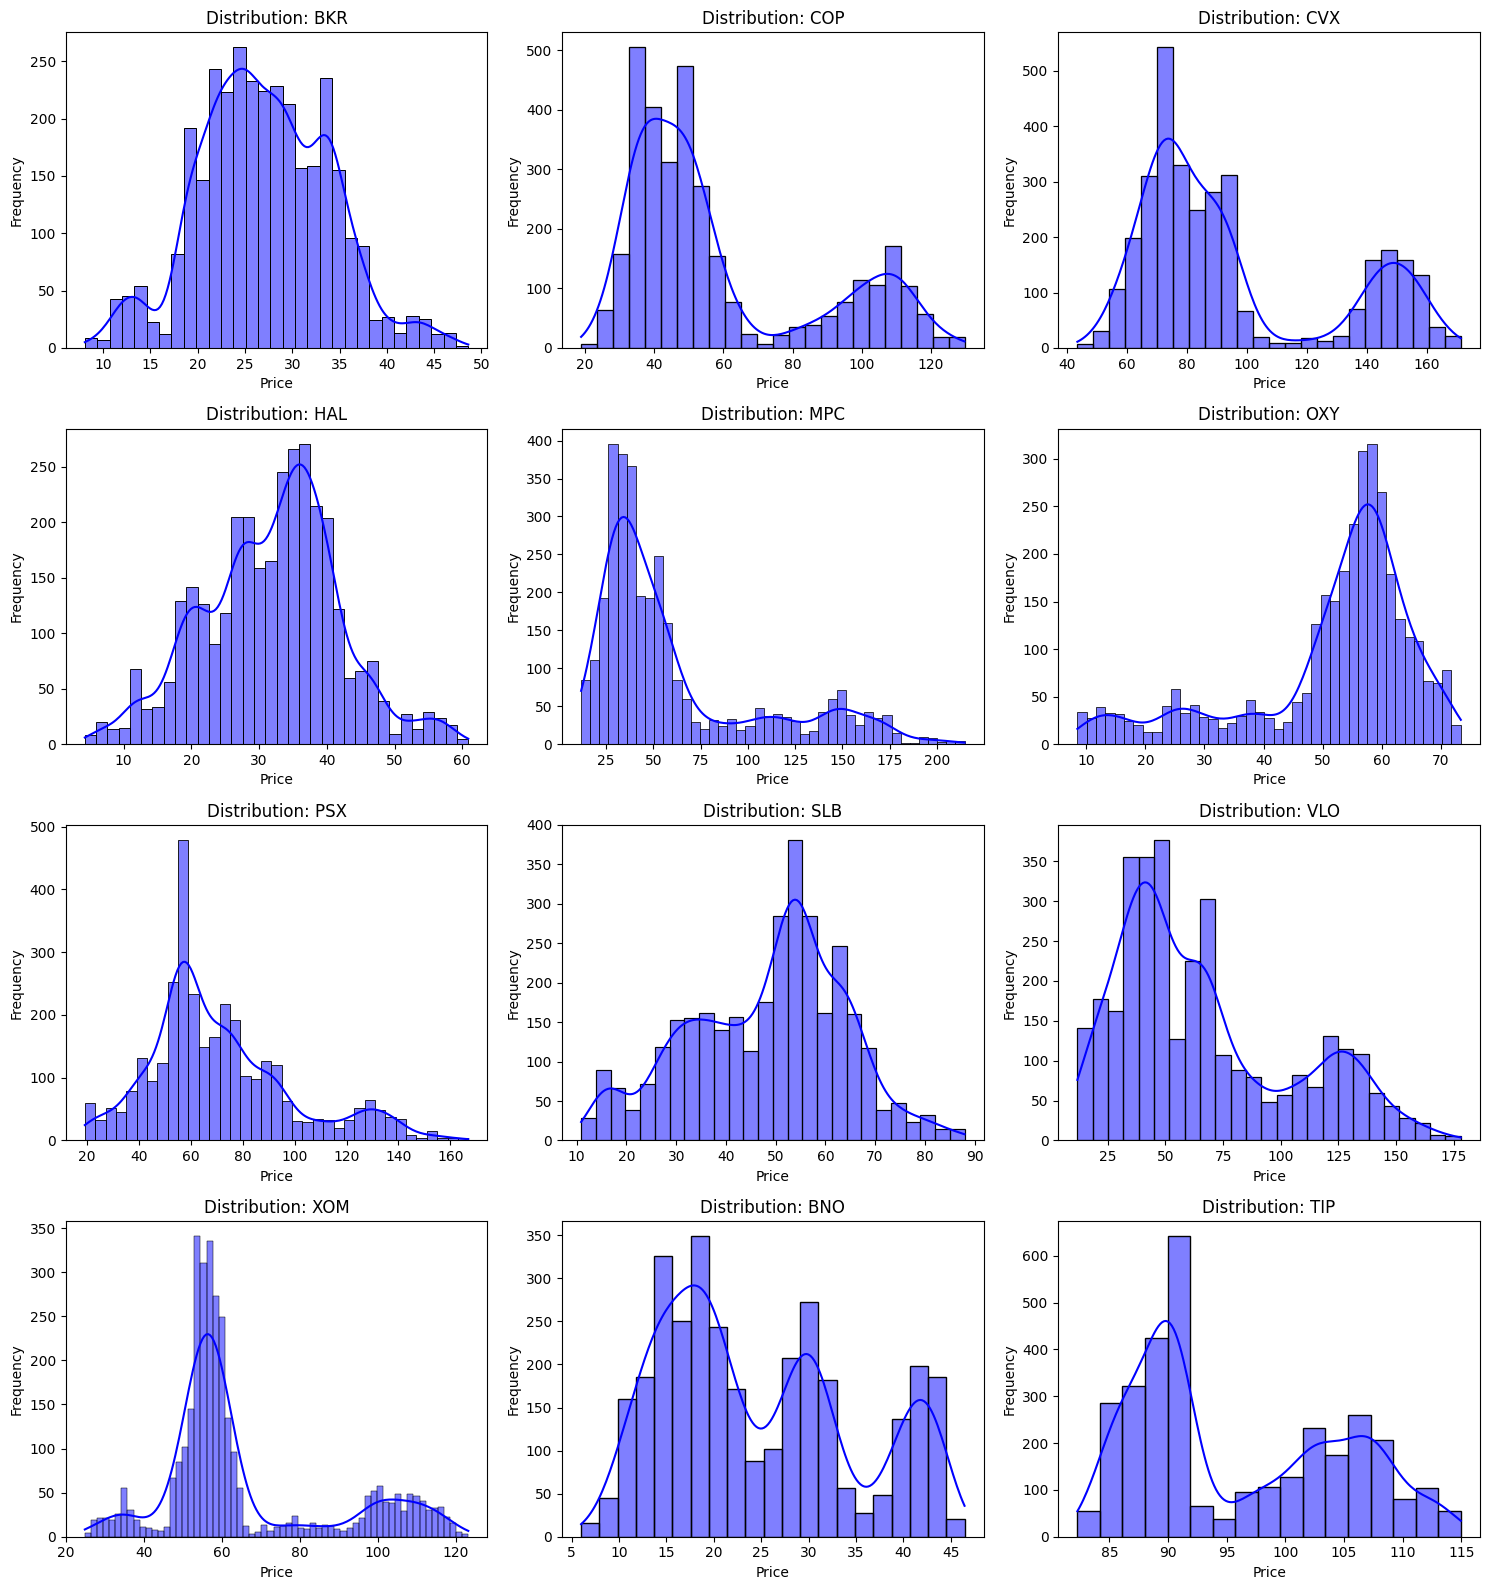

In [401]:
cols = df_sp500.columns
n = len(cols)
rows = (n + 2) // 3 
fig, axes = plt.subplots(rows, 3, figsize=(15, 4 * rows))
axes = axes.flatten()
for i, col in enumerate(cols):
    sns.histplot(df_sp500[col], kde=True, color='blue', ax=axes[i])
    axes[i].set_title(f'Distribution: {col}')
    axes[i].set_xlabel('Price')
    axes[i].set_ylabel('Frequency')
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)
plt.tight_layout()
plt.show()

In [411]:
import statsmodels.api as sm

<Figure size 500x500 with 0 Axes>

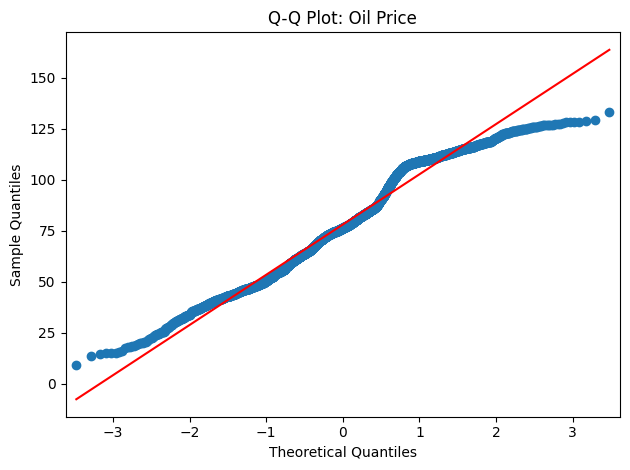

In [417]:
plt.figure(figsize=(5, 5))
sm.qqplot(df_oil['Price'], line='s')
plt.title('Q-Q Plot: Oil Price')
plt.tight_layout()
plt.show()

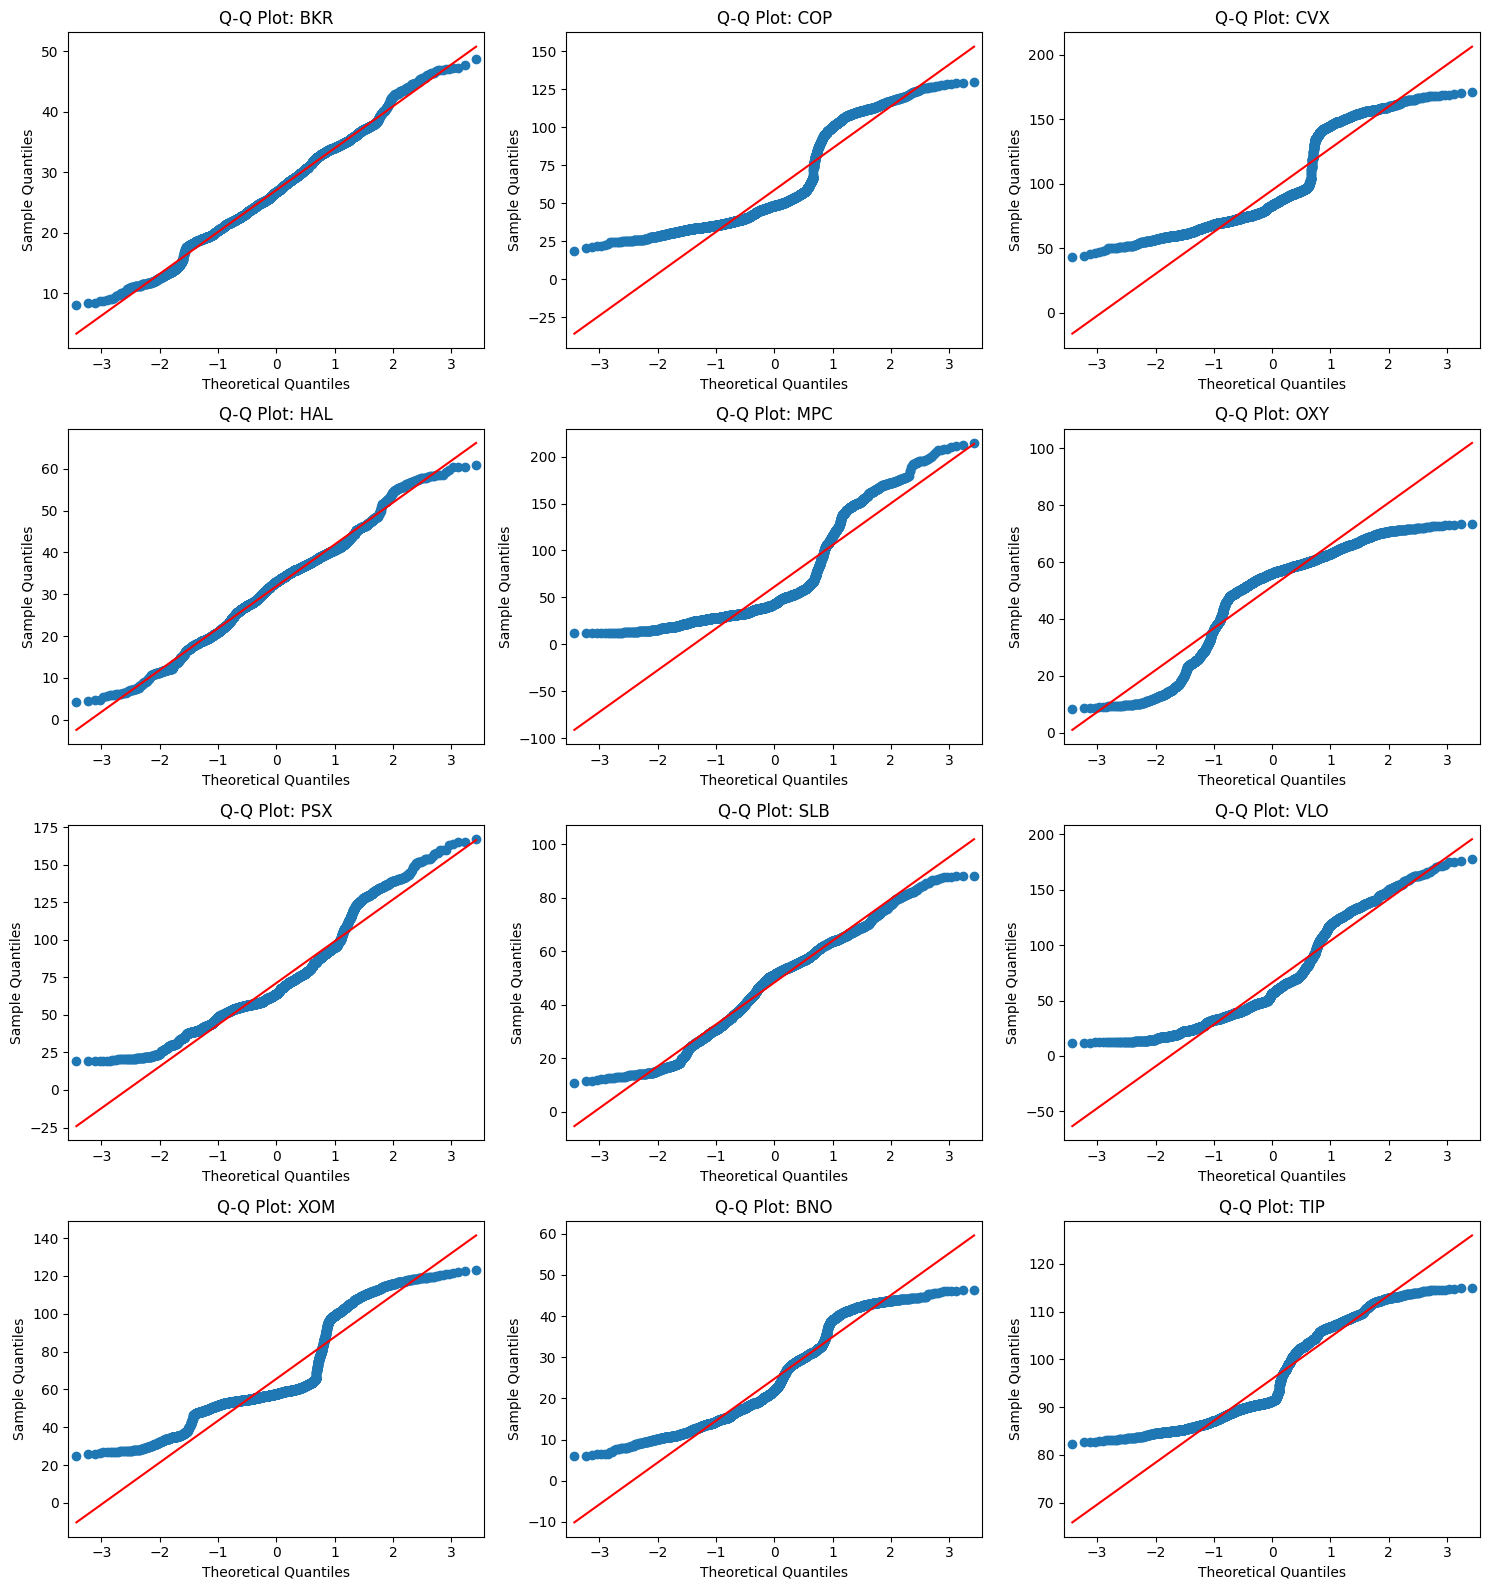

In [419]:
cols = df_sp500.columns
n = len(cols)
rows = (n + 2) // 3  # 3 plots per row
fig, axes = plt.subplots(rows, 3, figsize=(15, 4 * rows))
axes = axes.flatten()
for i, col in enumerate(cols):
    sm.qqplot(df_sp500[col], line='s', ax=axes[i])
    axes[i].set_title(f'Q-Q Plot: {col}')
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)
plt.tight_layout()
plt.show()

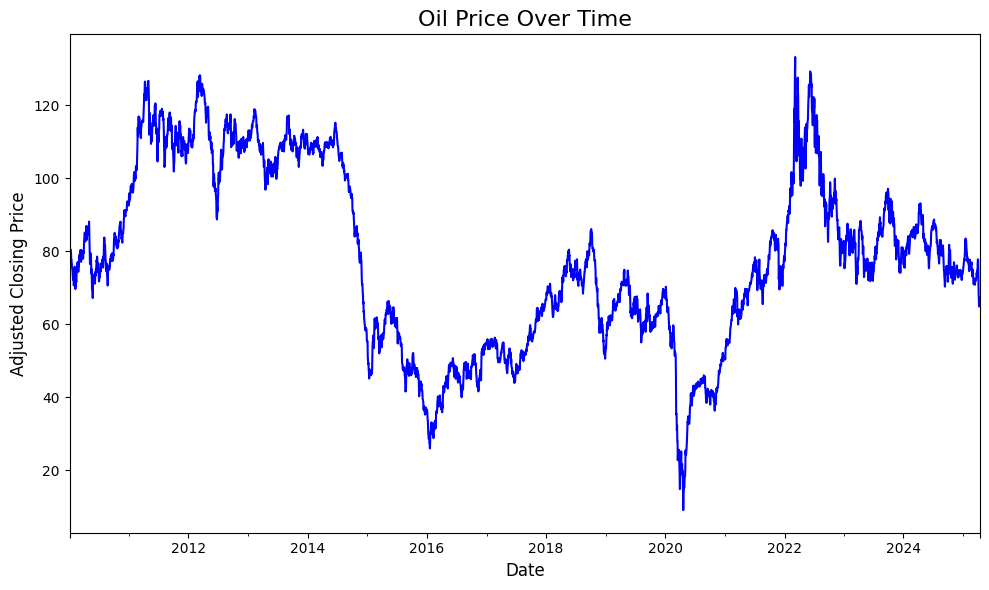

In [480]:
plt.figure(figsize=(10, 6))
df_oil['Price'].plot(color='blue', linewidth=1.5)
plt.title('Oil Price Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Adjusted Closing Price', fontsize=12)
plt.tight_layout()
plt.show()

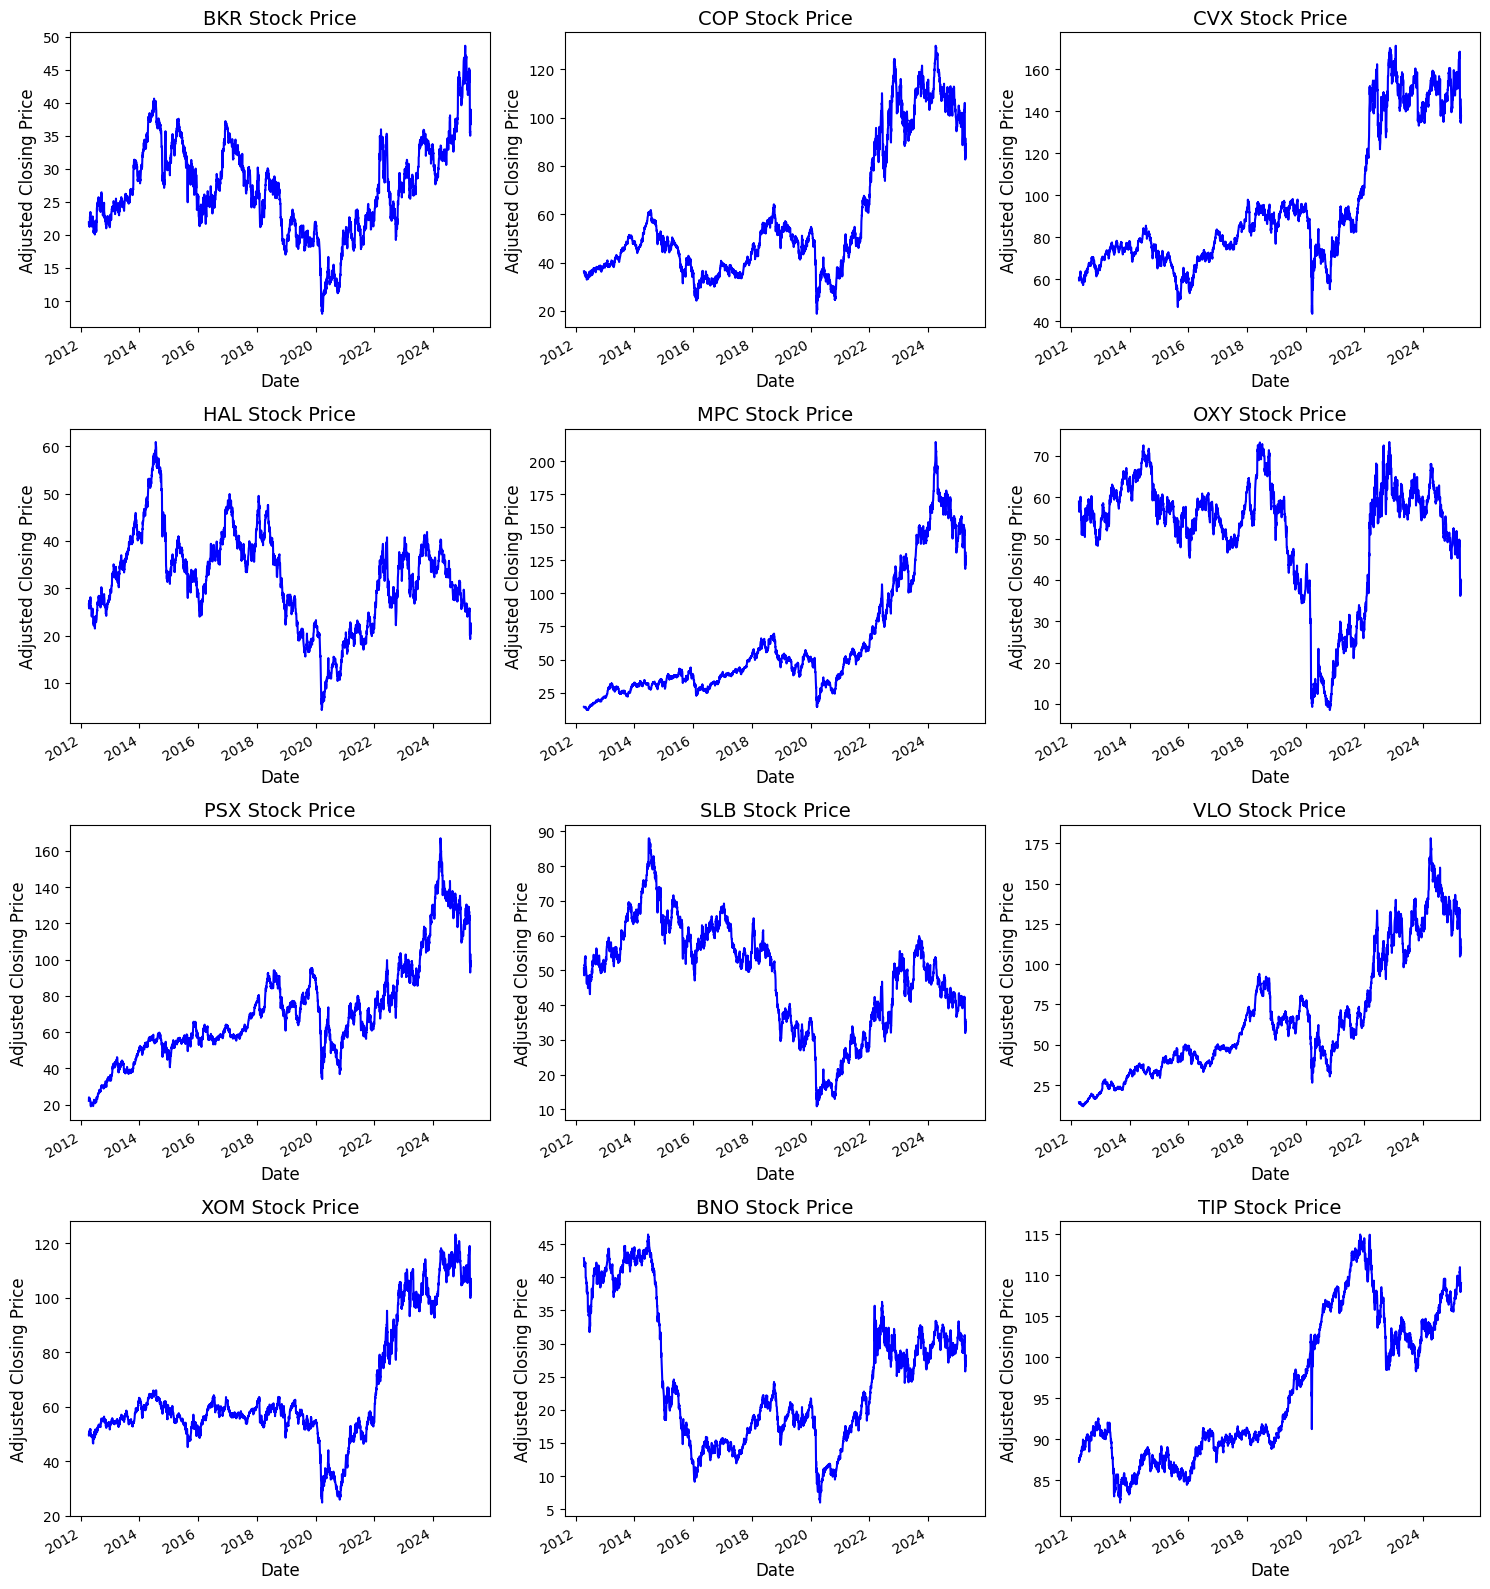

In [433]:
cols = df_sp500.columns
n = len(cols)
rows = (n + 2) // 3
fig, axes = plt.subplots(rows, 3, figsize=(15, 4 * rows))
axes = axes.flatten()
for i, col in enumerate(cols):
    df_sp500[col].plot(ax=axes[i], color='blue', linewidth=1.5)
    axes[i].set_title(f'{col} Stock Price', fontsize=14)
    axes[i].set_xlabel('Date', fontsize=12)
    axes[i].set_ylabel('Adjusted Closing Price', fontsize=12)
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)
plt.tight_layout()
plt.show()

In [593]:
df_oil_copy = df_oil.copy()
df_sp500_copy = df_sp500.copy()

In [595]:
df_oil = df_oil.resample('D').ffill()

In [597]:
df_oil.index.freq

<Day>

In [599]:
df_sp500 = df_sp500.asfreq('D').ffill()

In [601]:
df_sp500.index.freq

<Day>

In [603]:
df_oil.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5580 entries, 2010-01-04 to 2025-04-14
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   5580 non-null   float64
dtypes: float64(1)
memory usage: 87.2 KB


In [605]:
df_sp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4754 entries, 2012-04-12 to 2025-04-17
Freq: D
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BKR     4754 non-null   float64
 1   COP     4754 non-null   float64
 2   CVX     4754 non-null   float64
 3   HAL     4754 non-null   float64
 4   MPC     4754 non-null   float64
 5   OXY     4754 non-null   float64
 6   PSX     4754 non-null   float64
 7   SLB     4754 non-null   float64
 8   VLO     4754 non-null   float64
 9   XOM     4754 non-null   float64
 10  BNO     4754 non-null   float64
 11  TIP     4754 non-null   float64
dtypes: float64(12)
memory usage: 482.8 KB


# Train and Split

In [607]:
from sklearn.model_selection import train_test_split

In [609]:
df_oil_train, df_oil_test = train_test_split(df_oil, test_size=0.2, shuffle=False)
df_sp500_train, df_sp500_test = train_test_split(df_sp500, test_size=0.2, shuffle=False)

In [611]:
df_oil_train.tail()

Price
date              
2022-03-21  122.29
2022-03-22  121.53
2022-03-23  127.52
2022-03-24  123.98
2022-03-25  122.67

In [613]:
df_oil_test.head()

Price
date              
2022-03-26  122.67
2022-03-27  122.67
2022-03-28  114.50
2022-03-29  112.79
2022-03-30  115.59

In [615]:
df_sp500_train.tail()

Ticker            BKR         COP         CVX        HAL        MPC  \
Date                                                                  
2022-09-05  23.776989  100.152954  142.906601  28.453659  93.792030   
2022-09-06  23.410172   98.672371  142.245712  28.101435  93.158134   
2022-09-07  22.902281   96.973778  140.426010  27.301802  93.044579   
2022-09-08  22.469627   98.390793  141.186493  27.044779  93.148666   
2022-09-09  23.748770  101.706200  144.825912  28.234711  94.624672   

Ticker            OXY        PSX        SLB         VLO        XOM        BNO  \
Date                                                                            
2022-09-05  66.268158  80.892044  35.890129  105.457489  87.885117  29.299999   
2022-09-06  64.446907  79.337486  35.383434  104.493896  87.296715  29.160000   
2022-09-07  63.049664  78.935127  35.099308  104.345657  86.551994  27.670000   
2022-09-08  62.259495  78.578499  36.150585  103.706345  87.259941  27.910000   
2022-09-09  63.350574  80.498840  37.552288  104.994225  88.721771  29.160000   

Ticker             TIP  
Date                    
2022-09-05  105.368462  
2022-09-06  104.364357  
2022-09-07  104.796013  
2022-09-08  104.214218  
2022-09-09  104.261131

In [617]:
df_sp500_test.head()

Ticker            BKR         COP         CVX        HAL        MPC  \
Date                                                                  
2022-09-10  23.748770  101.706200  144.825912  28.234711  94.624672   
2022-09-11  23.748770  101.706200  144.825912  28.234711  94.624672   
2022-09-12  23.946281  103.904350  147.116409  28.824915  94.558449   
2022-09-13  23.080984  102.033211  144.318924  27.749214  92.391754   
2022-09-14  23.880445  106.920036  147.813507  28.939144  93.025665   

Ticker            OXY        PSX        SLB         VLO        XOM        BNO  \
Date                                                                            
2022-09-10  63.350574  80.498840  37.552288  104.994225  88.721771  29.160000   
2022-09-11  63.350574  80.498840  37.552288  104.994225  88.721771  29.160000   
2022-09-12  64.499603  81.897934  38.025826  105.855888  89.742302  29.650000   
2022-09-13  63.089870  78.788826  36.434711  103.150436  87.646080  29.469999   
2022-09-14  64.885818  78.642509  38.111073  101.538269  89.797478  29.740000   

Ticker             TIP  
Date                    
2022-09-10  104.261131  
2022-09-11  104.261131  
2022-09-12  103.951431  
2022-09-13  103.641762  
2022-09-14  103.904526

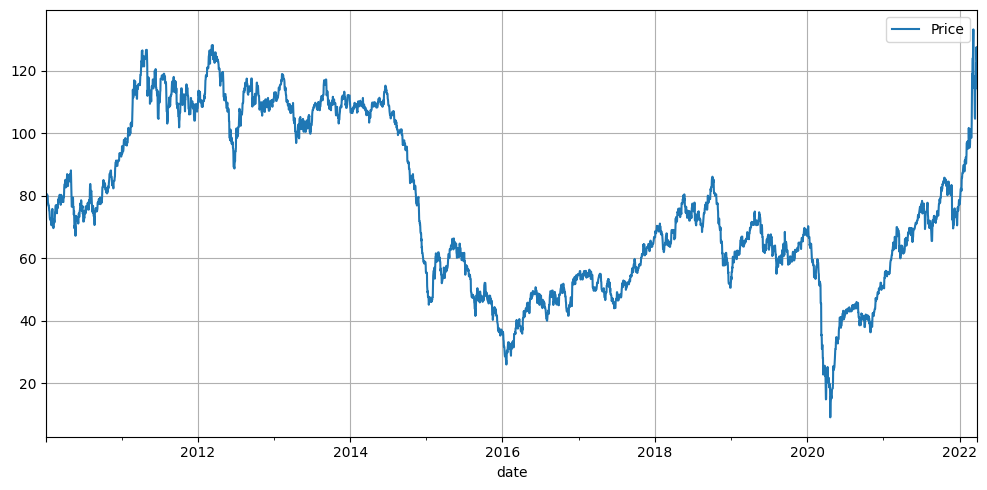

In [619]:
df_oil_train.plot(figsize=(10, 5), grid=True); plt.tight_layout()

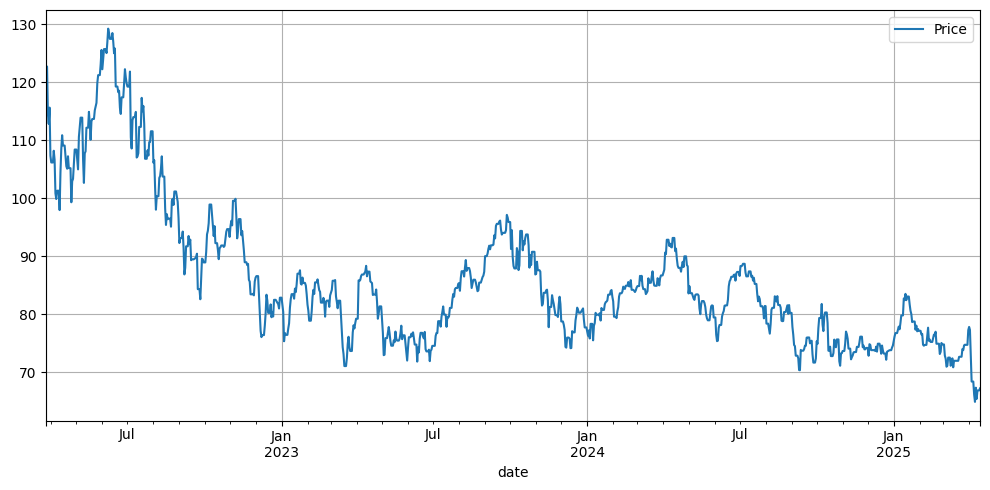

In [621]:
df_oil_test.plot(figsize=(10, 5), grid=True); plt.tight_layout()

In [623]:
from arch.unitroot import PhillipsPerron

In [625]:
def print_results(output, test='adf'):
    if test == 'pp':
        pval = output.pvalue
        test_score = output.stat
        lags = output.lags
        critical = output.critical_values
        decision = 'Stationary' if pval < 0.05 else 'Non-Stationary'
    else:
        pval = output[1]
        test_score = output[0]
        lags = output[2]
        decision = 'Non-Stationary'
        if test == 'adf':
            critical = output[4]
            if pval < 0.05:
                decision = 'Stationary'
        elif test == 'kpss':
            critical = output[3]
            if pval >= 0.05:
                decision = 'Stationary'

    output_dict = {
        'Test Statistic': test_score, 
        'p-value': pval,
        'Number of lags': lags, 
        'Decision': decision
    }

    for key, value in critical.items():
        output_dict[f'Critical Value ({key})'] = value

    return pd.Series(output_dict, name=test)

In [627]:
series = df_oil_train.Price

In [629]:
adf_output = adfuller(series)
kpss_output = kpss(series, regression='c')
pp_output = PhillipsPerron(series)

In [631]:
pd.concat([
    print_results(adf_output, 'adf'),
    print_results(kpss_output, 'kpss'),
    print_results(pp_output, 'pp')
], axis=1)

adf            kpss              pp
Test Statistic              -1.115566        4.864423       -1.218255
p-value                      0.708825            0.01        0.665694
Number of lags                      9              41              32
Decision               Non-Stationary  Non-Stationary  Non-Stationary
Critical Value (1%)         -3.431819           0.739       -3.431816
Critical Value (5%)         -2.862189           0.463       -2.862188
Critical Value (10%)        -2.567116           0.347       -2.567115
Critical Value (2.5%)             NaN           0.574             NaN

In [633]:
adfuller(df_oil_train.Price)

(-1.1155656430861742,
 0.7088247577144307,
 9,
 4454,
 {'1%': -3.431819032948193,
  '5%': -2.862189136197695,
  '10%': -2.5671155389917066},
 14377.863385783163)

In [635]:
kpss(df_oil_train['Price'], regression='c')

(4.864422966245772,
 0.01,
 41,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [637]:
PhillipsPerron(df_oil_train['Price'])

<class 'arch.unitroot.unitroot.PhillipsPerron'>
"""
     Phillips-Perron Test (Z-tau)    
=====================================
Test Statistic                 -1.218
P-value                         0.666
Lags                               32
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
"""

---
ADF (Augmented Dickey-Fuller):

Use when you suspect unit roots (i.e., non-stationarity due to random walks). It's ideal for trend-stationary series.

KPSS (Kwiatkowski–Phillips–Schmidt–Shin):

Use if you're checking for stationarity around a trend. It tests the null hypothesis of stationarity (so, higher p-value means stationary).

PP (Phillips-Perron):

Use if your data contains heteroskedasticity or autocorrelation, as it’s robust to these issues.

---

In [639]:
results = []
for col in df_sp500_train.columns:
    series = df_sp500_train[col]
    adf_output = adfuller(series)
    kpss_output = kpss(series, regression='c')
    pp_output = PhillipsPerron(series)
    results.append(pd.concat([
        print_results(adf_output, 'adf'),
        print_results(kpss_output, 'kpss'),
        print_results(pp_output, 'pp')
    ], axis=1))
stationarity_results = pd.concat(results, axis=0)
stationarity_results

adf            kpss              pp
Test Statistic              -2.266461        3.078583       -2.363754
p-value                      0.183013            0.01        0.152229
Number of lags                      0              38              30
Decision               Non-Stationary  Non-Stationary  Non-Stationary
Critical Value (1%)         -3.432071           0.739       -3.432071
...                               ...             ...             ...
Decision               Non-Stationary  Non-Stationary  Non-Stationary
Critical Value (1%)          -3.43208           0.739       -3.432071
Critical Value (5%)         -2.862305           0.463         -2.8623
Critical Value (10%)        -2.567177           0.347       -2.567175
Critical Value (2.5%)             NaN           0.574             NaN

[96 rows x 3 columns]

In [641]:
df_sp500_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3803 entries, 2012-04-12 to 2022-09-09
Freq: D
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BKR     3803 non-null   float64
 1   COP     3803 non-null   float64
 2   CVX     3803 non-null   float64
 3   HAL     3803 non-null   float64
 4   MPC     3803 non-null   float64
 5   OXY     3803 non-null   float64
 6   PSX     3803 non-null   float64
 7   SLB     3803 non-null   float64
 8   VLO     3803 non-null   float64
 9   XOM     3803 non-null   float64
 10  BNO     3803 non-null   float64
 11  TIP     3803 non-null   float64
dtypes: float64(12)
memory usage: 386.2 KB


---
Stock prices (like XOM, CVX) are typically the focus for your analysis, as you're studying the relationship with oil prices and CPI.

Brent Oil and CPI (like BNO, TIP) can also be important depending on your model setup.

---

In [643]:
series = df_sp500_train.XOM
adf_output = adfuller(series)
kpss_output = kpss(series, regression='c')
pp_output = PhillipsPerron(series)
pd.concat([
    print_results(adf_output, 'adf'),
    print_results(kpss_output, 'kpss'),
    print_results(pp_output, 'pp')
], axis=1)

adf            kpss              pp
Test Statistic              -0.825016        0.504469        -0.89344
p-value                      0.811663         0.04066        0.790125
Number of lags                     15              38              30
Decision               Non-Stationary  Non-Stationary  Non-Stationary
Critical Value (1%)         -3.432078           0.739       -3.432071
Critical Value (5%)         -2.862304           0.463         -2.8623
Critical Value (10%)        -2.567176           0.347       -2.567175
Critical Value (2.5%)             NaN           0.574             NaN

In [645]:
series = df_sp500_train.CVX
adf_output = adfuller(series)
kpss_output = kpss(series, regression='c')
pp_output = PhillipsPerron(series)
pd.concat([
    print_results(adf_output, 'adf'),
    print_results(kpss_output, 'kpss'),
    print_results(pp_output, 'pp')
], axis=1)

adf            kpss              pp
Test Statistic              -0.598406        4.114271       -0.666553
p-value                      0.871342            0.01        0.855224
Number of lags                     15              38              30
Decision               Non-Stationary  Non-Stationary  Non-Stationary
Critical Value (1%)         -3.432078           0.739       -3.432071
Critical Value (5%)         -2.862304           0.463         -2.8623
Critical Value (10%)        -2.567176           0.347       -2.567175
Critical Value (2.5%)             NaN           0.574             NaN

In [647]:
series = df_sp500_train.BNO
adf_output = adfuller(series)
kpss_output = kpss(series, regression='c')
pp_output = PhillipsPerron(series)
pd.concat([
    print_results(adf_output, 'adf'),
    print_results(kpss_output, 'kpss'),
    print_results(pp_output, 'pp')
], axis=1)

adf            kpss              pp
Test Statistic              -1.622266        4.517806       -1.732517
p-value                      0.471542            0.01        0.414442
Number of lags                      7              39              30
Decision               Non-Stationary  Non-Stationary  Non-Stationary
Critical Value (1%)         -3.432074           0.739       -3.432071
Critical Value (5%)         -2.862302           0.463         -2.8623
Critical Value (10%)        -2.567176           0.347       -2.567175
Critical Value (2.5%)             NaN           0.574             NaN

In [649]:
series = df_sp500_train.TIP
adf_output = adfuller(series)
kpss_output = kpss(series, regression='c')
pp_output = PhillipsPerron(series)
pd.concat([
    print_results(adf_output, 'adf'),
    print_results(kpss_output, 'kpss'),
    print_results(pp_output, 'pp')
], axis=1)

adf            kpss              pp
Test Statistic              -0.471947        7.351423       -0.643954
p-value                      0.897376            0.01        0.860738
Number of lags                     20              39              30
Decision               Non-Stationary  Non-Stationary  Non-Stationary
Critical Value (1%)          -3.43208           0.739       -3.432071
Critical Value (5%)         -2.862305           0.463         -2.8623
Critical Value (10%)        -2.567177           0.347       -2.567175
Critical Value (2.5%)             NaN           0.574             NaN

In [526]:
# i checked most of these columns and all of them are non-stationary which means i can apply first order diff()
# to the whole df

In [651]:
df_sp500_diff = df_sp500_train.diff().dropna()

In [653]:
df_oil_diff = df_oil_train.diff().dropna()

### as you can see first order differencing is enough to make data stationary

# First Order Differencing

In [657]:
series = df_oil_diff.Price
adf_output = adfuller(series)
kpss_output = kpss(series, regression='c')
pp_output = PhillipsPerron(series)
pd.concat([
    print_results(adf_output, 'adf'),
    print_results(kpss_output, 'kpss'),
    print_results(pp_output, 'pp')
], axis=1)

adf        kpss          pp
Test Statistic         -21.580179    0.262827  -66.109455
p-value                       0.0         0.1         0.0
Number of lags                  8          13          32
Decision               Stationary  Stationary  Stationary
Critical Value (1%)     -3.431819       0.739   -3.431816
Critical Value (5%)     -2.862189       0.463   -2.862188
Critical Value (10%)    -2.567116       0.347   -2.567115
Critical Value (2.5%)         NaN       0.574         NaN

In [660]:
series = df_sp500_diff.XOM
adf_output = adfuller(series)
kpss_output = kpss(series, regression='c')
pp_output = PhillipsPerron(series)
pd.concat([
    print_results(adf_output, 'adf'),
    print_results(kpss_output, 'kpss'),
    print_results(pp_output, 'pp')
], axis=1)

adf        kpss          pp
Test Statistic         -15.930178    0.225598  -60.897211
p-value                       0.0         0.1         0.0
Number of lags                 14           5          30
Decision               Stationary  Stationary  Stationary
Critical Value (1%)     -3.432078       0.739   -3.432072
Critical Value (5%)     -2.862304       0.463   -2.862301
Critical Value (10%)    -2.567176       0.347   -2.567175
Critical Value (2.5%)         NaN       0.574         NaN

In [662]:
series = df_sp500_diff.CVX
adf_output = adfuller(series)
kpss_output = kpss(series, regression='c')
pp_output = PhillipsPerron(series)
pd.concat([
    print_results(adf_output, 'adf'),
    print_results(kpss_output, 'kpss'),
    print_results(pp_output, 'pp')
], axis=1)

adf        kpss          pp
Test Statistic         -16.102619    0.156481   -61.76843
p-value                       0.0         0.1         0.0
Number of lags                 14           0          30
Decision               Stationary  Stationary  Stationary
Critical Value (1%)     -3.432078       0.739   -3.432072
Critical Value (5%)     -2.862304       0.463   -2.862301
Critical Value (10%)    -2.567176       0.347   -2.567175
Critical Value (2.5%)         NaN       0.574         NaN

In [664]:
series = df_sp500_diff.BNO
adf_output = adfuller(series)
kpss_output = kpss(series, regression='c')
pp_output = PhillipsPerron(series)
pd.concat([
    print_results(adf_output, 'adf'),
    print_results(kpss_output, 'kpss'),
    print_results(pp_output, 'pp')
], axis=1)

adf        kpss          pp
Test Statistic         -22.859014    0.449345  -62.413888
p-value                       0.0    0.055886         0.0
Number of lags                  6          12          30
Decision               Stationary  Stationary  Stationary
Critical Value (1%)     -3.432074       0.739   -3.432072
Critical Value (5%)     -2.862302       0.463   -2.862301
Critical Value (10%)    -2.567176       0.347   -2.567175
Critical Value (2.5%)         NaN       0.574         NaN

In [666]:
series = df_sp500_diff.TIP
adf_output = adfuller(series)
kpss_output = kpss(series, regression='c')
pp_output = PhillipsPerron(series)
pd.concat([
    print_results(adf_output, 'adf'),
    print_results(kpss_output, 'kpss'),
    print_results(pp_output, 'pp')
], axis=1)

adf        kpss          pp
Test Statistic         -15.394246    0.099681  -56.158929
p-value                       0.0         0.1         0.0
Number of lags                 19           8          30
Decision               Stationary  Stationary  Stationary
Critical Value (1%)      -3.43208       0.739   -3.432072
Critical Value (5%)     -2.862305       0.463   -2.862301
Critical Value (10%)    -2.567177       0.347   -2.567175
Critical Value (2.5%)         NaN       0.574         NaN

### As you can see most (all) datasets are now stationary

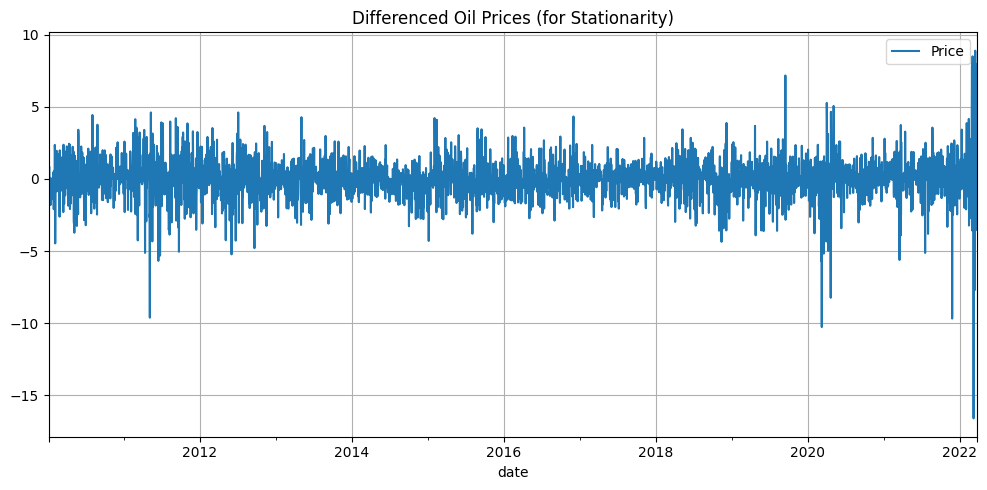

In [693]:
df_oil_diff.plot(figsize=(10, 5), grid=True, title="Differenced Oil Prices (for Stationarity)"); plt.tight_layout()

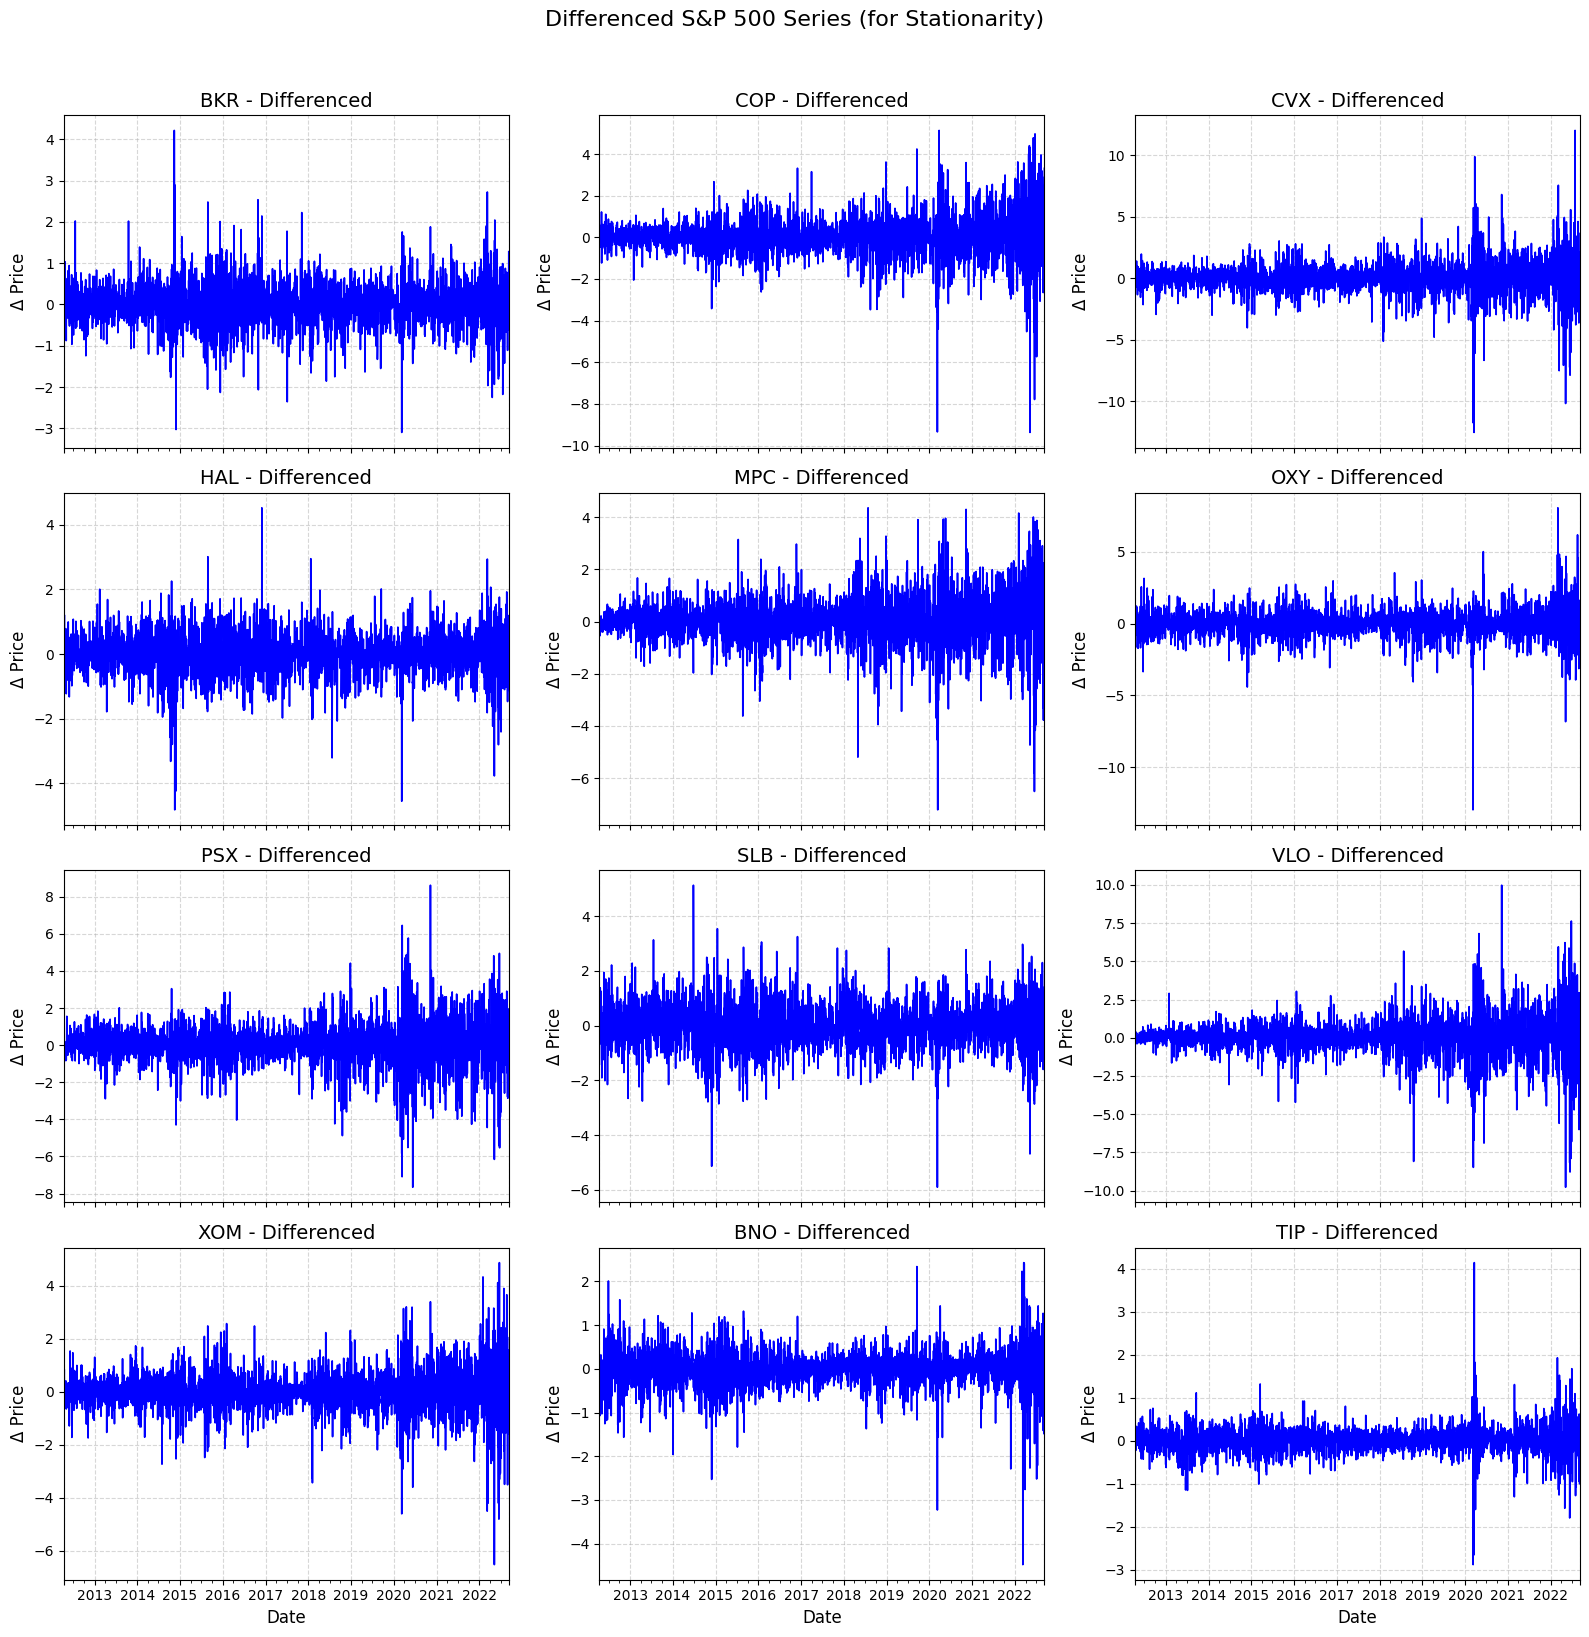

In [691]:
cols = df_sp500_diff.columns
n = len(cols)
rows = (n + 2) // 3
fig, axes = plt.subplots(rows, 3, figsize=(16, 4 * rows), sharex=True)
axes = axes.flatten()
for i, col in enumerate(cols):
    df_sp500_diff[col].plot(ax=axes[i], color='blue', linewidth=1.2)
    axes[i].set_title(f'{col} - Differenced', fontsize=14)
    axes[i].set_xlabel('Date', fontsize=12)
    axes[i].set_ylabel('Δ Price', fontsize=12)
    axes[i].grid(True, linestyle='--', alpha=0.5)

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Differenced S&P 500 Series (for Stationarity)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

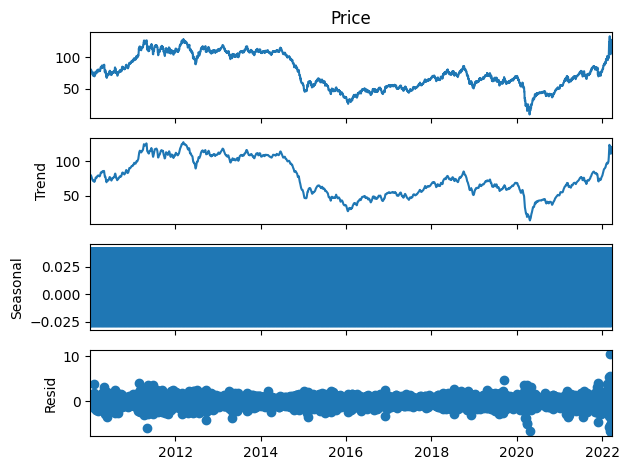

In [705]:
oil_decomposed = seasonal_decompose(df_oil_train.Price, model='additive')
oil_decomposed.plot().show()

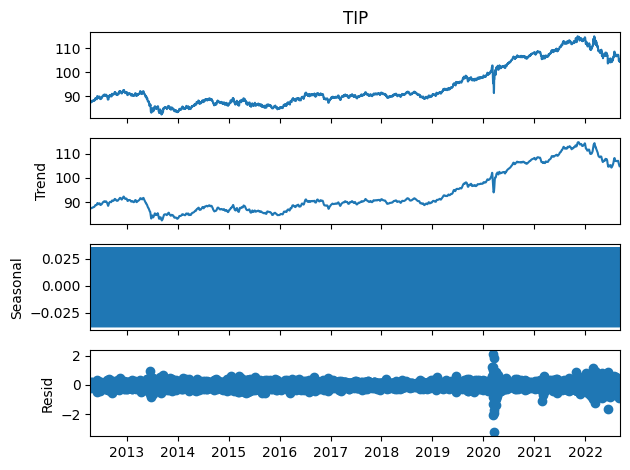

In [707]:
oil_decomposed = seasonal_decompose(df_sp500_train.TIP, model='additive')
oil_decomposed.plot().show()

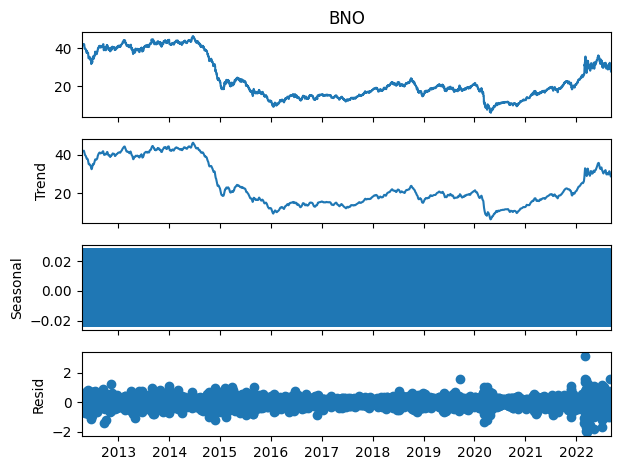

In [709]:
oil_decomposed = seasonal_decompose(df_sp500_train.BNO, model='additive')
oil_decomposed.plot().show()

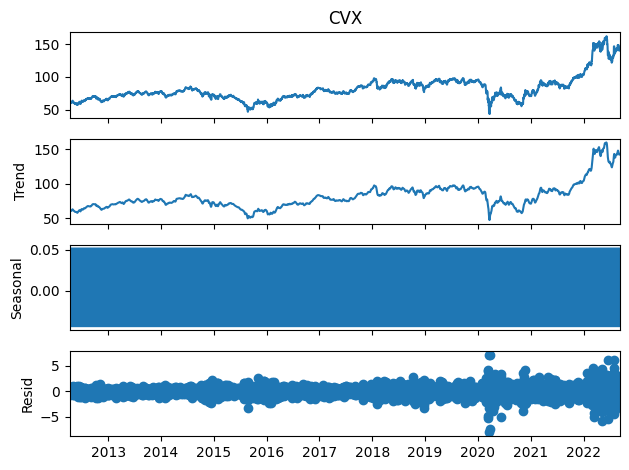

In [748]:
oil_decomposed = seasonal_decompose(df_sp500_train.CVX, model='additive')
oil_decomposed.plot(); plt.show()

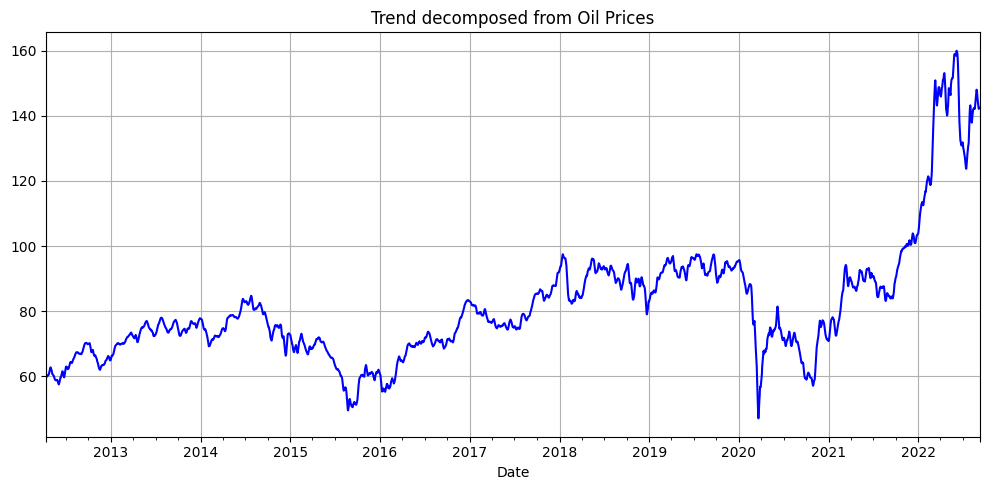

In [750]:
(oil_decomposed.trend).plot(color='blue', grid=True, title='Trend decomposed from Oil Prices', figsize=(10, 5))
plt.tight_layout();

Based on the plot provided, the seasonal component is essentially constant—it does not show significant variation over time. This indicates that data lacks a detectable seasonality.

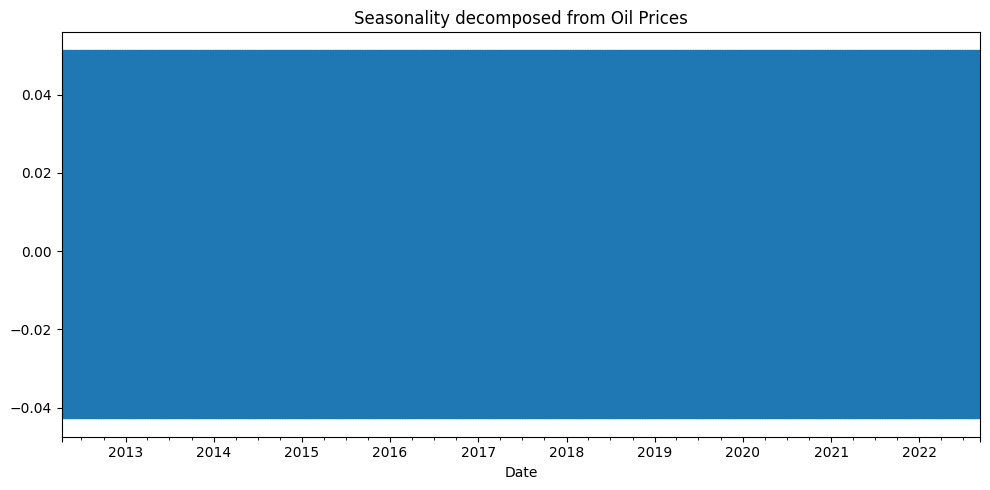

In [752]:
(oil_decomposed.seasonal).plot(title='Seasonality decomposed from Oil Prices', figsize=(10, 5)); plt.tight_layout()

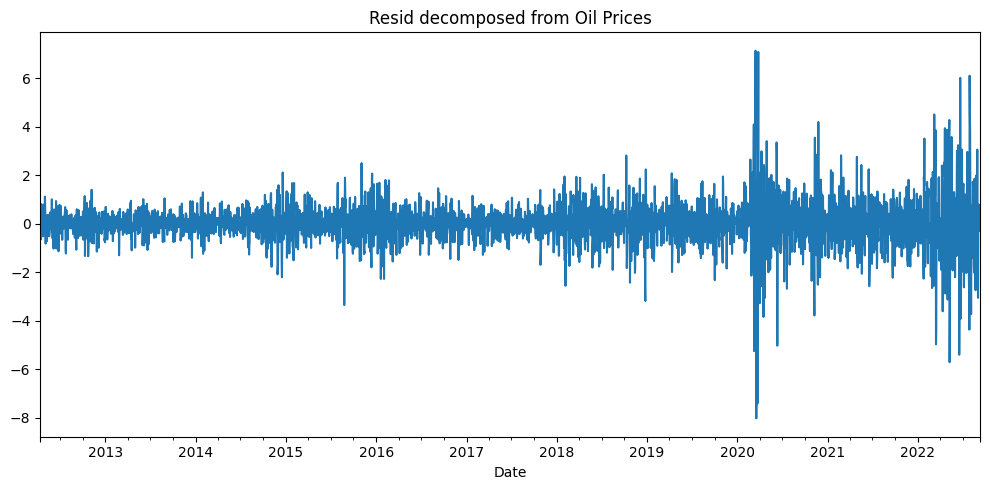

In [754]:
(oil_decomposed.resid).plot(title='Resid decomposed from Oil Prices', figsize=(10, 5)); plt.tight_layout()

<Axes: title={'center': 'Trend + Seasonality + Residuals'}, xlabel='Date'>

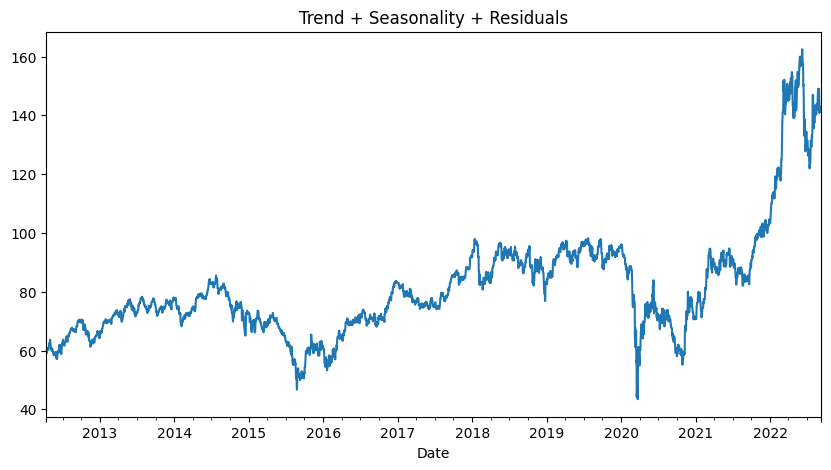

In [764]:
(oil_decomposed.trend + oil_decomposed.seasonal + oil_decomposed.resid).plot(figsize=(10, 5), 
                            title='Trend + Seasonality + Residuals')

<Axes: title={'center': 'Trend + Residuals, Without Seasonality'}, xlabel='Date'>

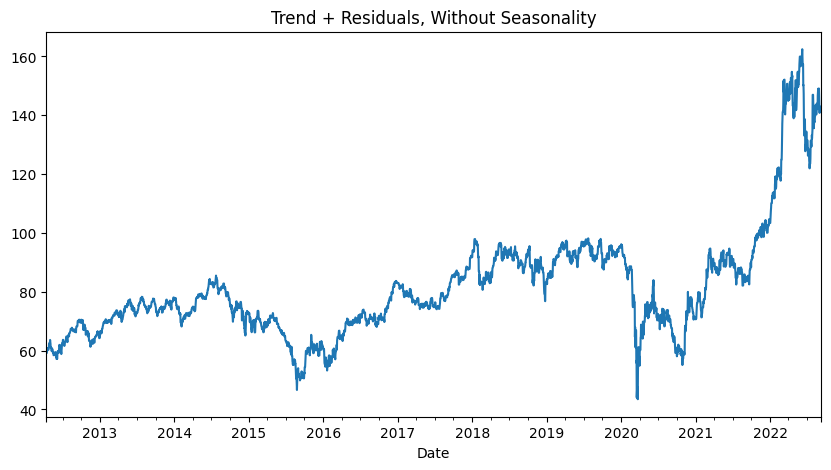

In [766]:
(oil_decomposed.trend + oil_decomposed.resid).plot(figsize=(10, 5), 
                                        title='Trend + Residuals, Without Seasonality')

<Axes: title={'center': 'Seasonality + Residuals, Without Trend'}, xlabel='Date'>

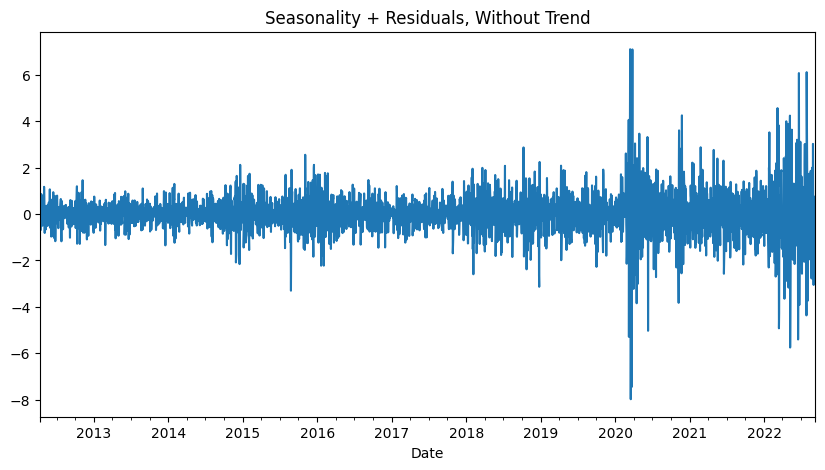

In [774]:
(oil_decomposed.seasonal + oil_decomposed.resid).plot(figsize=(10, 5), 
                                    title='Seasonality + Residuals, Without Trend')

---
=> What you can see from here is that, without seasonality it is the same so there is no seasonality in this data. \
And without trend only residuals are here which means data is already stationary. \
If we take the resid then we have only trend. In one word, detrending is enough to make out data stationary and ready for forecasting.

---

### More Advanced Decomposition Technique: STL

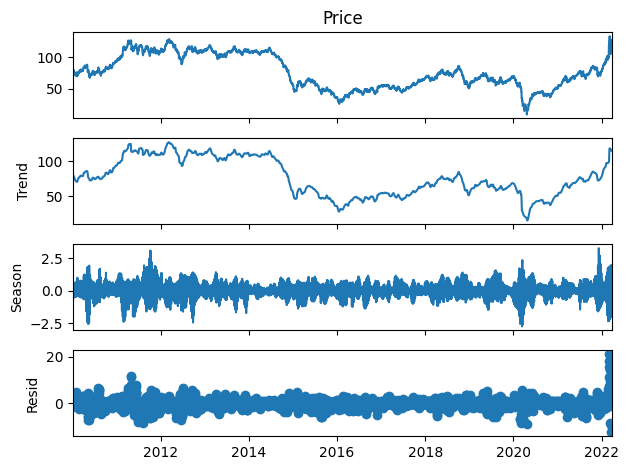

In [789]:
dt_STL_decomposed = STL(
    df_oil_train.Price, 
    robust = True
).fit()
dt_STL_decomposed.plot(); plt.show()

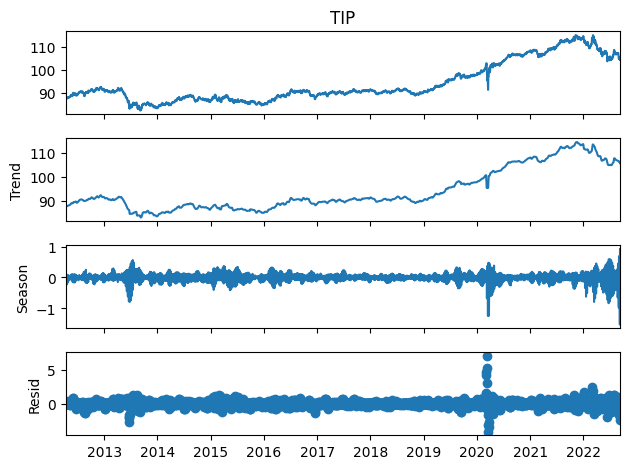

In [791]:
dt_STL_decomposed = STL(
    df_sp500_train.TIP, 
    robust = True
).fit()
dt_STL_decomposed.plot(); plt.show()

In [796]:
from statsmodels.tsa.filters.hp_filter import hpfilter

In [798]:
df_oil_cyclic, df_oil_trend = hpfilter(df_oil_train.Price)

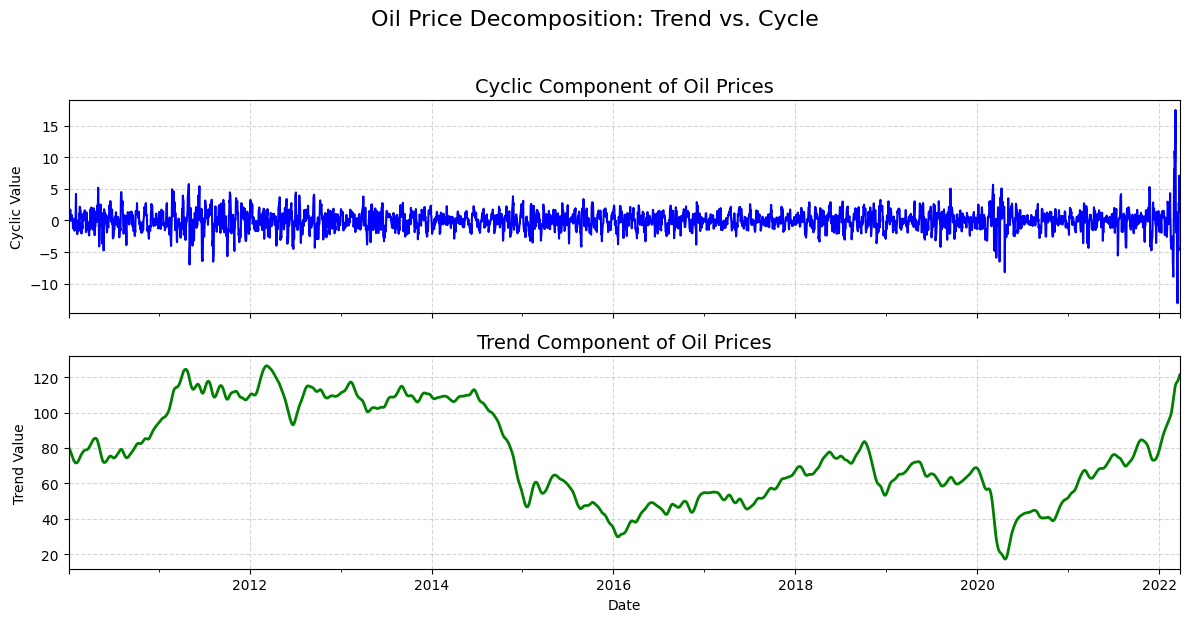

In [812]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
df_oil_cyclic.plot(ax=ax[0], color='blue', linewidth=1.5, linestyle='-')
ax[0].set_title('Cyclic Component of Oil Prices', fontsize=14)
ax[0].set_ylabel('Cyclic Value')
ax[0].grid(True, linestyle='--', alpha=0.5)
df_oil_trend.plot(ax=ax[1], color='green', linewidth=2)
ax[1].set_title('Trend Component of Oil Prices', fontsize=14)
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Trend Value')
ax[1].grid(True, linestyle='--', alpha=0.5)
plt.suptitle('Oil Price Decomposition: Trend vs. Cycle', fontsize=16, y=1.03)
plt.tight_layout()
plt.show()

In [814]:
adf_result_for_oil = adfuller(df_oil_diff.Price, store=True)

In [816]:
adf_result_for_oil

(-21.58017904180778,
 0.0,
 {'1%': -3.431819032948193,
  '5%': -2.862189136197695,
  '10%': -2.5671155389917066},
 <statsmodels.stats.diagnostic.ResultsStore at 0x1bf4d3829f0>)

In [832]:
print(adf_result_for_oil[-1].resols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     486.2
Date:                Fri, 18 Apr 2025   Prob (F-statistic):               0.00
Time:                        19:04:53   Log-Likelihood:                -7218.1
No. Observations:                4454   AIC:                         1.446e+04
Df Residuals:                    4444   BIC:                         1.452e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.9607      0.045    -21.580      0.0

In [822]:
adf_result_for_sp500_TIP = adfuller(df_sp500_diff.TIP, store=True)

In [824]:
adf_result_for_sp500_TIP

(-15.394245774023931,
 3.2789395400004237e-28,
 {'1%': -3.432080233724424,
  '5%': -2.862304522028767,
  '10%': -2.5671769652905114},
 <statsmodels.stats.diagnostic.ResultsStore at 0x1bf41e93ec0>)

In [830]:
print(adf_result_for_sp500_TIP[-1].resols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                     165.6
Date:                Fri, 18 Apr 2025   Prob (F-statistic):               0.00
Time:                        19:04:39   Log-Likelihood:                -443.23
No. Observations:                3782   AIC:                             928.5
Df Residuals:                    3761   BIC:                             1059.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.2076      0.078    -15.394      0.0

In [834]:
from scipy.stats import shapiro, kstest, normaltest
from statsmodels.stats.diagnostic import kstest_normal

In [836]:
def is_normal(test, p_level = 0.05):
    stat, pval = test
    return 'Normal' if pval > 0.05 else 'Not Normal'

In [842]:
shapiro(df_oil_diff.Price)

ShapiroResult(statistic=0.8583490926958621, pvalue=4.342310255175361e-53)

In [844]:
print(is_normal(shapiro(df_oil_diff.Price)))

Not Normal


In [846]:
print(is_normal(kstest_normal(df_oil_diff.Price)))

Not Normal


In [850]:
shapiro(df_sp500_train.TIP)

ShapiroResult(statistic=0.8379471671047728, pvalue=2.059993206313428e-52)

In [856]:
print(is_normal(shapiro(df_sp500_train.TIP)))

Not Normal


In [858]:
print(is_normal(kstest_normal(df_sp500_train.TIP)))

Not Normal


### Testing for homoskedactisity --- keep this for model test

In [861]:
# testing for stability of the variance against the model's residuals.
from statsmodels.stats.api import (het_breuschpagan, het_goldfeldquandt, het_white)

In [863]:
def het_test(model, test=het_breuschpagan):
    lm, lm_pvalue, fvalue, f_pvalue = (
        het_breuschpagan(model.resid, sm.add_constant(model.fittedvalues))
    )
    return 'Heteroskedastic' if f_pvalue < 0.05 else 'Homoskedastic'

In [869]:
# het_test(df_oil_train.Price, test=het_breuschpagan)

In [871]:
# het_test(model, test=het_white)

### Applying Box-Cox transform

In [875]:
from scipy.stats import boxcox

In [881]:
xt, lmbda = boxcox(df_oil_train.Price)
xts = pd.Series(xt, index=df_oil_train.index)

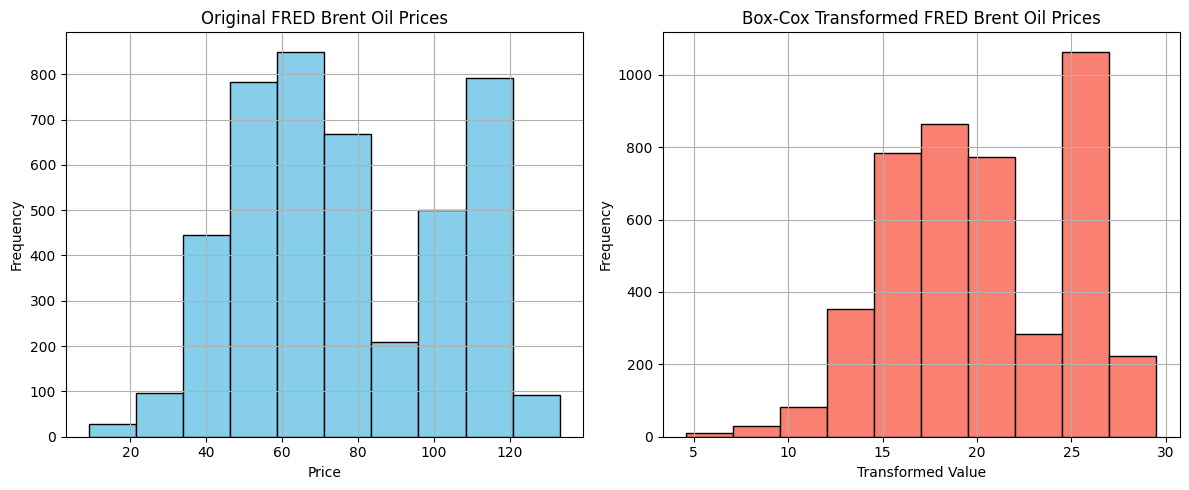

In [931]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
df_oil_train.Price.hist(ax=ax[0], color='skyblue', edgecolor='black')
ax[0].set_title('Original FRED Brent Oil Prices')
ax[0].set_xlabel('Price')
ax[0].set_ylabel('Frequency')
xts.hist(ax=ax[1], color='salmon', edgecolor='black')
ax[1].set_title('Box-Cox Transformed FRED Brent Oil Prices')
ax[1].set_xlabel('Transformed Value')
ax[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

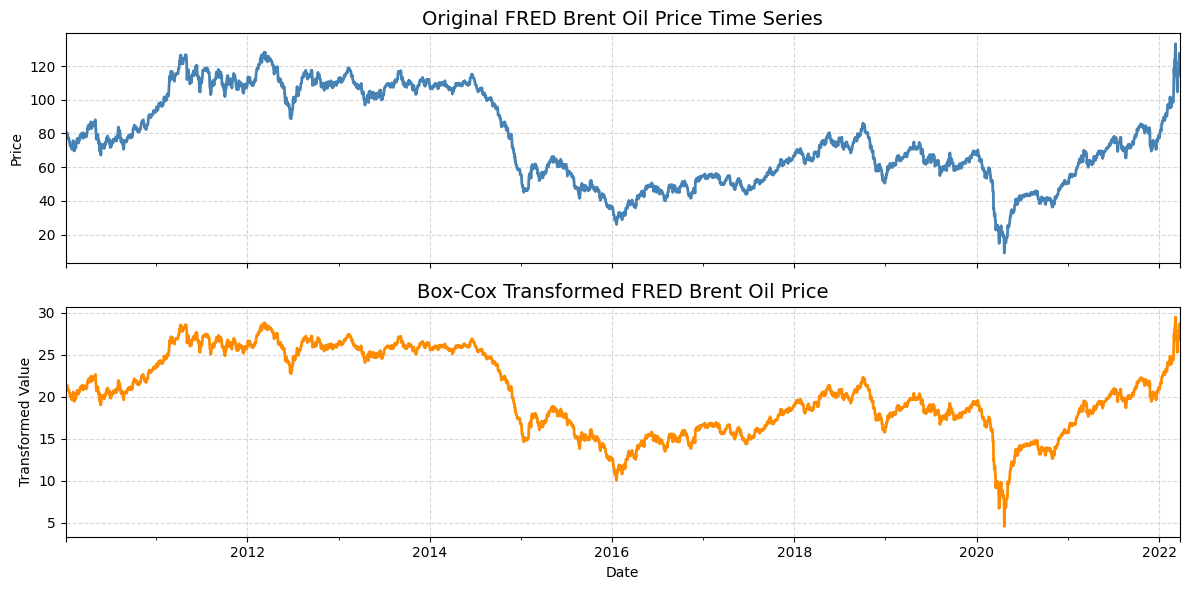

In [929]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
df_oil_train.Price.plot(ax=ax[0], color='steelblue', linewidth=2)
ax[0].set_title('Original FRED Brent Oil Price Time Series', fontsize=14)
ax[0].set_ylabel('Price')
ax[0].grid(True, linestyle='--', alpha=0.5)
xts.plot(ax=ax[1], color='darkorange', linewidth=2)
ax[1].set_title('Box-Cox Transformed FRED Brent Oil Price', fontsize=14)
ax[1].set_ylabel('Transformed Value')
ax[1].set_xlabel('Date')
ax[1].grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [893]:
print(is_normal(shapiro(xts)))

Not Normal


In [905]:
xts.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 4464 entries, 2010-01-04 to 2022-03-25
Freq: D
Series name: None
Non-Null Count  Dtype  
--------------  -----  
4464 non-null   float64
dtypes: float64(1)
memory usage: 69.8 KB


In [907]:
xt, lmbda = boxcox(df_sp500_train.TIP)
xts_TIP = pd.Series(xt, index=df_sp500_train.index)

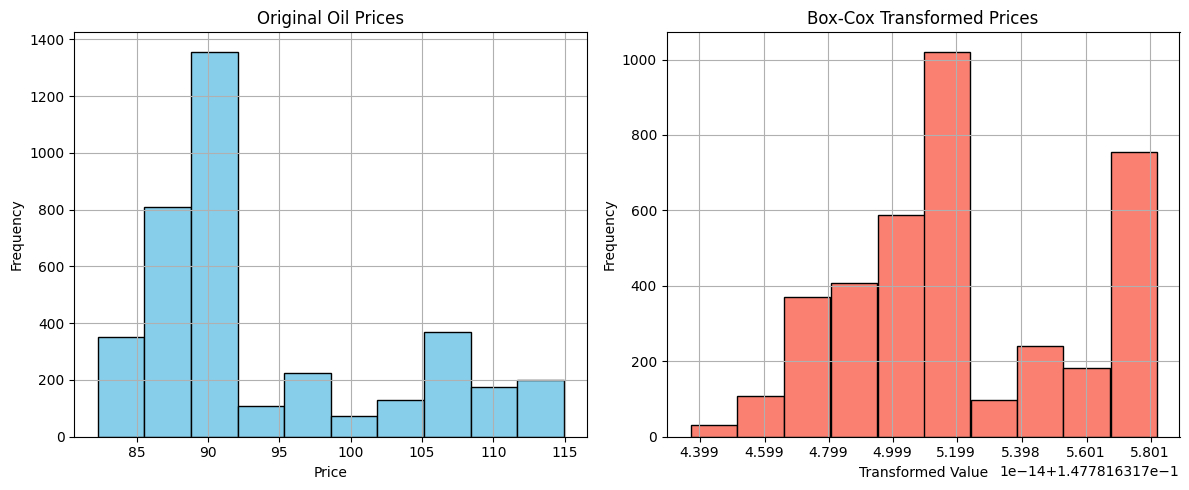

In [909]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
df_sp500_train.TIP.hist(ax=ax[0], color='skyblue', edgecolor='black')
ax[0].set_title('Original Oil Prices')
ax[0].set_xlabel('Price')
ax[0].set_ylabel('Frequency')
xts_TIP.hist(ax=ax[1], color='salmon', edgecolor='black')
ax[1].set_title('Box-Cox Transformed Prices')
ax[1].set_xlabel('Transformed Value')
ax[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

In [911]:
print(is_normal(shapiro(xts_TIP)))

Not Normal


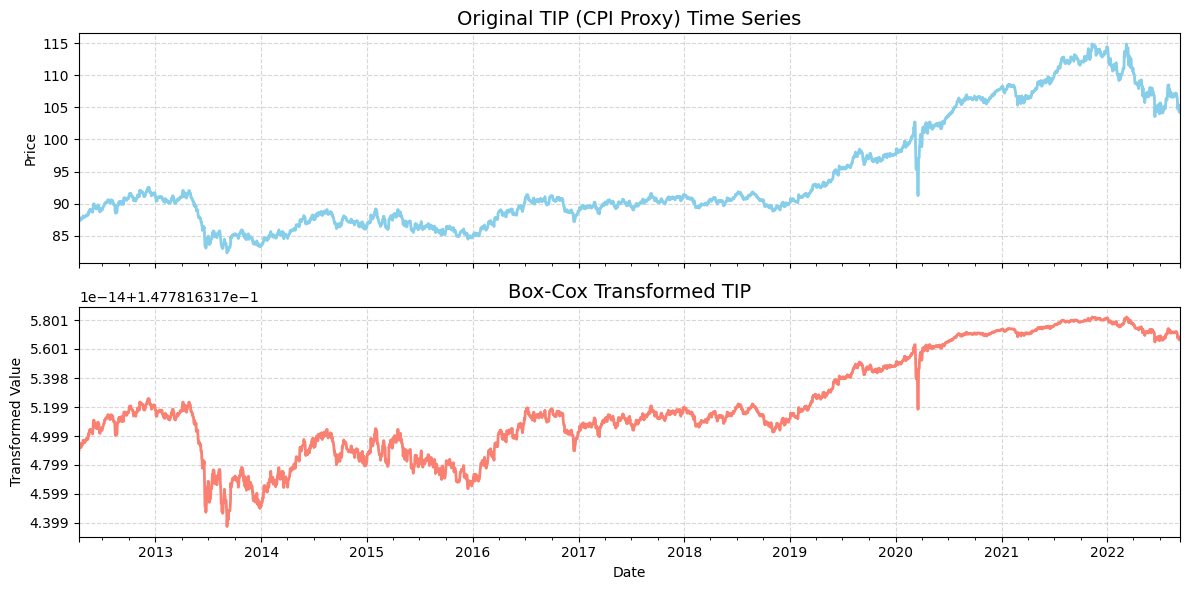

In [923]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
df_sp500_train.TIP.plot(ax=ax[0], color='skyblue', linewidth=2)
ax[0].set_title('Original TIP (CPI Proxy) Time Series', fontsize=14)
ax[0].set_ylabel('Price')
ax[0].grid(True, linestyle='--', alpha=0.5)
xts_TIP.plot(ax=ax[1], color='salmon', linewidth=2)
ax[1].set_title('Box-Cox Transformed TIP', fontsize=14)
ax[1].set_ylabel('Transformed Value')
ax[1].set_xlabel('Date')
ax[1].grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# ACF & PACF

- `ywm` (Yule-Walker Modified) is:
  - More stable for longer lag values.
  - Less sensitive to multicollinearity.
  - Preferred when differencing is applied.
  - Default in many statistical tools due to better finite sample properties.

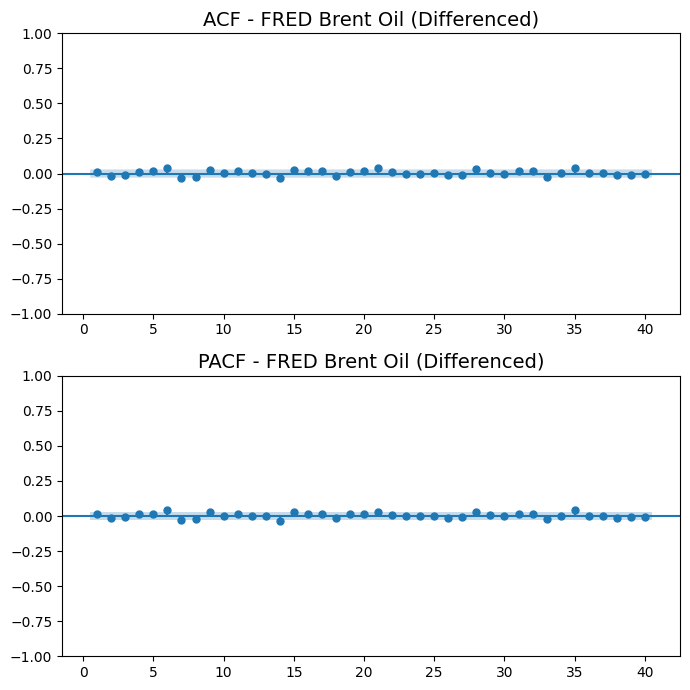

In [1149]:
fig, axes = plt.subplots(2, 1, figsize=(7, 7))
plot_acf(df_oil_diff['Price'], ax=axes[0], lags=40, alpha=0.05, zero=False)
axes[0].set_title('ACF - FRED Brent Oil (Differenced)', fontsize=14)
plot_pacf(df_oil_diff['Price'], ax=axes[1], lags=40, alpha=0.05, method='ywm', zero=False)
axes[1].set_title('PACF - FRED Brent Oil (Differenced)', fontsize=14)
plt.tight_layout()
plt.show()

In [989]:
model_ar1 = SARIMAX(df_oil_diff.Price, order = (1, 0, 0))
result_model_ar1 = model_ar1.fit()

In [991]:
print(result_model_ar1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 4463
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -7240.230
Date:                Fri, 18 Apr 2025   AIC                          14484.461
Time:                        22:20:03   BIC                          14497.268
Sample:                    01-05-2010   HQIC                         14488.975
                         - 03-25-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0128      0.009      1.427      0.154      -0.005       0.030
sigma2         1.5018      0.011    137.550      0.000       1.480       1.523
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [993]:
resid_model_ar1 = result_model_ar1.resid

In [995]:
resid_model_ar1.var()

1.5020678179916267

In [997]:
resid_model_ar1.mean()

0.009644657180827241

In [971]:
resid_model_ar1.std()

1.2255887638158351

In [973]:
mae = np.mean(np.abs(resid_model_ar1))
mae

0.7249568169652717

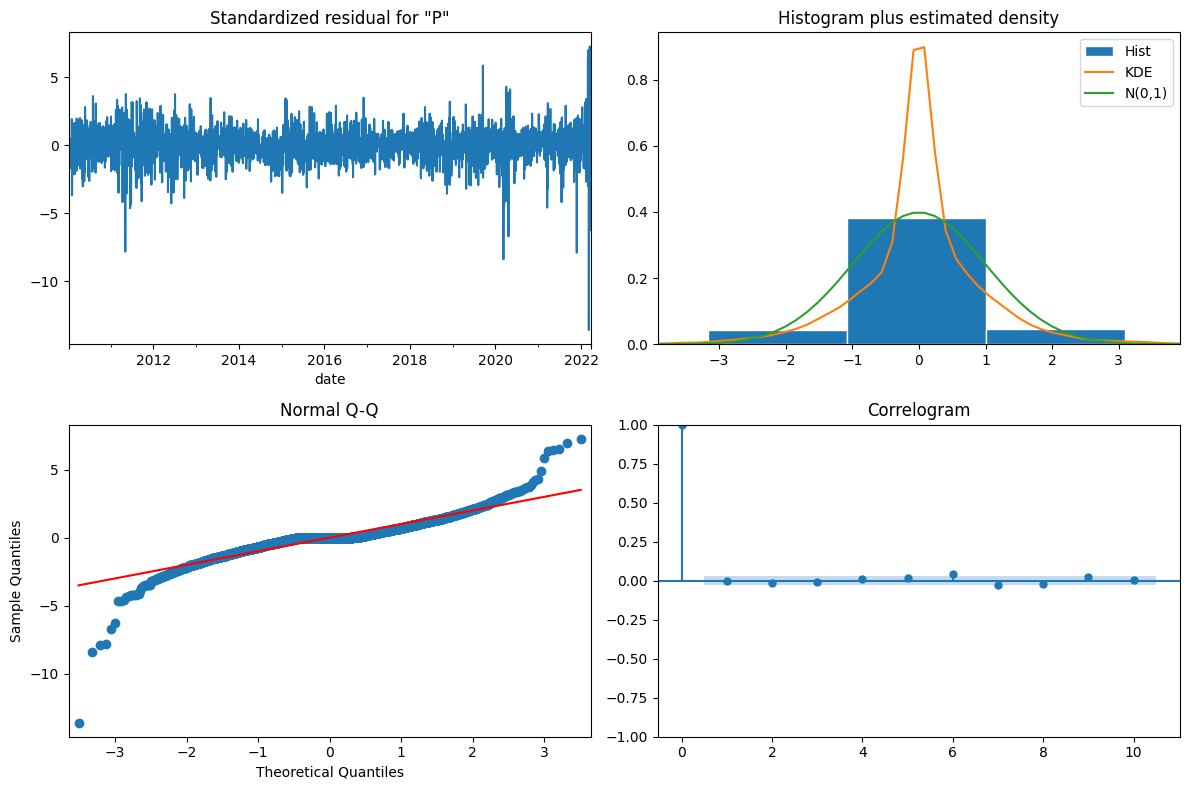

In [1234]:
result_model_ar1.plot_diagnostics(figsize=(12, 8)); plt.tight_layout()

In [999]:
model_ar2 = SARIMAX(df_oil_diff.Price, order = (2, 0, 0))
result_model_ar2 = model_ar2.fit()
print(result_model_ar2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 4463
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -7239.769
Date:                Fri, 18 Apr 2025   AIC                          14485.539
Time:                        22:20:13   BIC                          14504.749
Sample:                    01-05-2010   HQIC                         14492.311
                         - 03-25-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0130      0.009      1.404      0.160      -0.005       0.031
ar.L2         -0.0144      0.009     -1.607      0.108      -0.032       0.003
sigma2         1.5015      0.011    135.077      0.0

In [1021]:
resid_model_ar2 = result_model_ar2.resid
print('Residuals Variance:', resid_model_ar2.var())
print('Residuals Mean:',resid_model_ar2.mean())
print('Residuals STD:',resid_model_ar2.std())
mae = np.mean(np.abs(resid_model_ar2))
print('Residuals MAE:',mae)

Residuals Variance: 1.501754353864541
Residuals Mean: 0.009799199561711944
Residuals STD: 1.225460874065158
Residuals MAE: 0.7282361106985379


In [1170]:
# result_model_ar2.plot_diagnostics(); plt.tight_layout()

In [1028]:
model_ar3 = SARIMAX(df_oil_diff.Price, order = (3, 0, 0))
result_model_ar3 = model_ar3.fit()
print(result_model_ar3.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 4463
Model:               SARIMAX(3, 0, 0)   Log Likelihood               -7239.565
Date:                Fri, 18 Apr 2025   AIC                          14487.131
Time:                        22:29:39   BIC                          14512.745
Sample:                    01-05-2010   HQIC                         14496.160
                         - 03-25-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0129      0.009      1.379      0.168      -0.005       0.031
ar.L2         -0.0142      0.009     -1.517      0.129      -0.033       0.004
ar.L3         -0.0096      0.010     -0.982      0.3

In [1030]:
resid_model_ar3 = result_model_ar3.resid
print('Residuals Variance:', resid_model_ar3.var())
print('Residuals Mean:',resid_model_ar3.mean())
print('Residuals STD:',resid_model_ar3.std())
mae = np.mean(np.abs(resid_model_ar3))
print('Residuals MAE:',mae)

Residuals Variance: 1.5016152720772002
Residuals Mean: 0.009890052846921692
Residuals STD: 1.2254041260242272
Residuals MAE: 0.7290507370259333


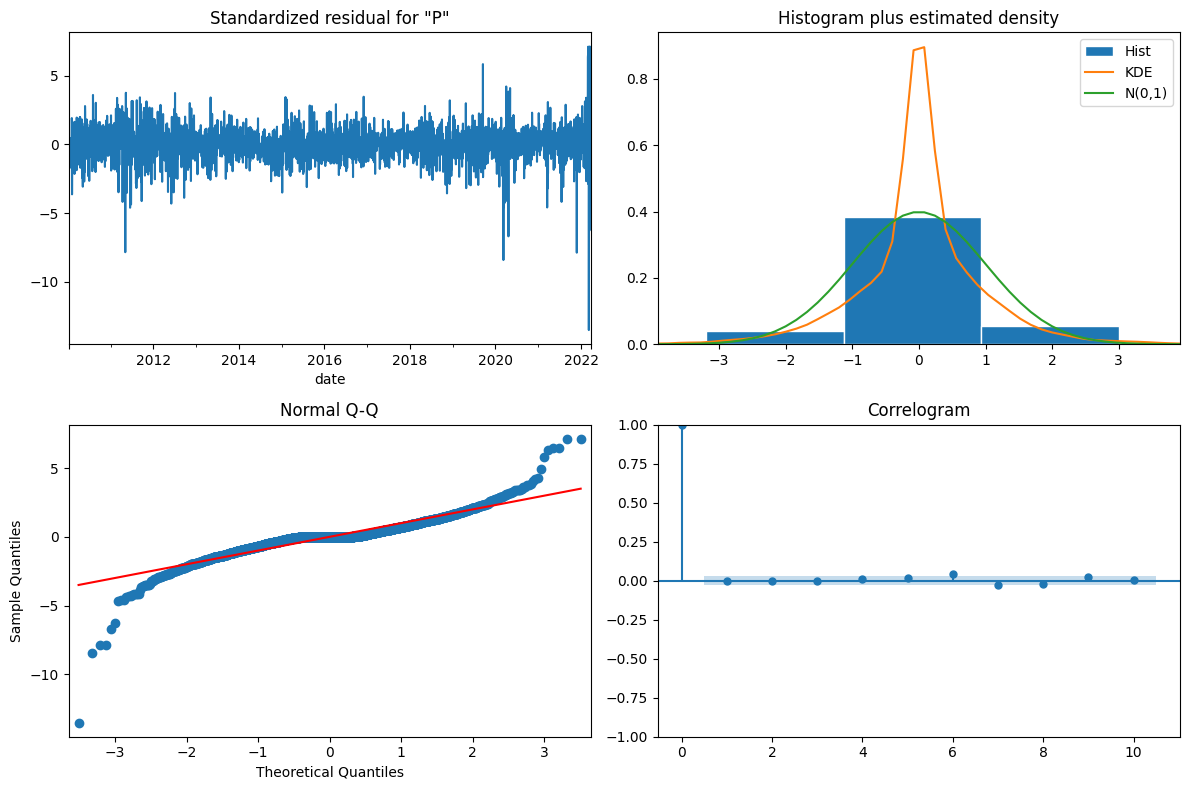

In [1232]:
result_model_ar3.plot_diagnostics(figsize=(12, 8)); plt.tight_layout(); plt.show()

In [1037]:
model_ma1 = SARIMAX(df_oil_diff.Price, order = (0, 0, 1))
result_model_ma1 = model_ma1.fit()
print(result_model_ma1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 4463
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -7240.220
Date:                Fri, 18 Apr 2025   AIC                          14484.439
Time:                        22:32:33   BIC                          14497.247
Sample:                    01-05-2010   HQIC                         14488.954
                         - 03-25-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0132      0.009      1.458      0.145      -0.005       0.031
sigma2         1.5018      0.011    137.662      0.000       1.480       1.523
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [1039]:
resid_model_ma1 = result_model_ma1.resid
print('Residuals Variance:', resid_model_ma1.var())
print('Residuals Mean:',resid_model_ma1.mean())
print('Residuals STD:',resid_model_ma1.std())
mae = np.mean(np.abs(resid_model_ma1))
print('Residuals MAE:',mae)

Residuals Variance: 1.5020606676275883
Residuals Mean: 0.009642880924723504
Residuals STD: 1.2255858466984628
Residuals MAE: 0.7250415542823176


In [1052]:
model_ma2 = SARIMAX(df_oil_diff.Price, order = (0, 0, 2))
result_model_ma2 = model_ma2.fit()
print(result_model_ma2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 4463
Model:               SARIMAX(0, 0, 2)   Log Likelihood               -7239.797
Date:                Fri, 18 Apr 2025   AIC                          14485.594
Time:                        22:36:44   BIC                          14504.805
Sample:                    01-05-2010   HQIC                         14492.366
                         - 03-25-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0127      0.009      1.372      0.170      -0.005       0.031
ma.L2         -0.0136      0.009     -1.518      0.129      -0.031       0.004
sigma2         1.5015      0.011    135.122      0.0

In [1054]:
resid_model_ma2 = result_model_ma2.resid
print('Residuals Variance:', resid_model_ma2.var())
print('Residuals Mean:',resid_model_ma2.mean())
print('Residuals STD:',resid_model_ma2.std())
mae = np.mean(np.abs(resid_model_ma2))
print('Residuals MAE:',mae)

Residuals Variance: 1.5017731175685973
Residuals Mean: 0.00979363425540501
Residuals STD: 1.225468529815677
Residuals MAE: 0.7280449640571558


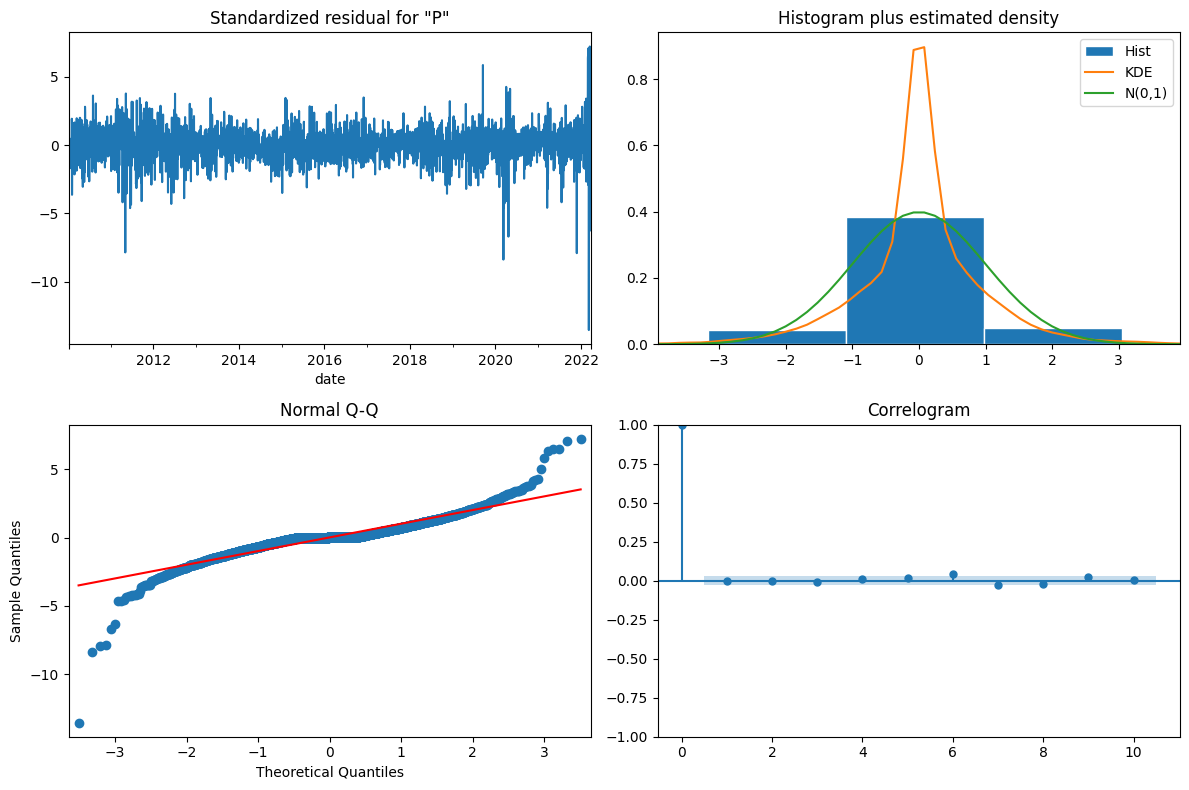

In [1230]:
result_model_ma2.plot_diagnostics(figsize=(12, 8)); plt.tight_layout(); plt.show()

In [1059]:
model_ma3 = SARIMAX(df_oil_diff.Price, order = (0, 0, 3))
result_model_ma3 = model_ma3.fit()
print(result_model_ma3.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 4463
Model:               SARIMAX(0, 0, 3)   Log Likelihood               -7239.598
Date:                Fri, 18 Apr 2025   AIC                          14487.196
Time:                        23:33:51   BIC                          14512.810
Sample:                    01-05-2010   HQIC                         14496.225
                         - 03-25-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0131      0.009      1.406      0.160      -0.005       0.031
ma.L2         -0.0134      0.009     -1.447      0.148      -0.032       0.005
ma.L3         -0.0091      0.010     -0.940      0.3

In [1061]:
resid_model_ma3 = result_model_ma3.resid
print('Residuals Variance:', resid_model_ma3.var())
print('Residuals Mean:',resid_model_ma3.mean())
print('Residuals STD:',resid_model_ma3.std())
mae = np.mean(np.abs(resid_model_ma3))
print('Residuals MAE:',mae)

Residuals Variance: 1.5016373791362152
Residuals Mean: 0.009874677126772027
Residuals STD: 1.2254131463046312
Residuals MAE: 0.7288004991430255


In [1168]:
# result_model_ma3.plot_diagnostics(); plt.tight_layout(); plt.show()

In [1065]:
model_ar1_ma1 = SARIMAX(df_oil_diff.Price, order=(1, 0, 1))
result_ar1_ma1 = model_ar1_ma1.fit()

In [1069]:
print(result_ar1_ma1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 4463
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -7240.082
Date:                Fri, 18 Apr 2025   AIC                          14486.164
Time:                        23:36:58   BIC                          14505.375
Sample:                    01-05-2010   HQIC                         14492.936
                         - 03-25-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2727      0.606     -0.450      0.653      -1.461       0.915
ma.L1          0.2873      0.605      0.474      0.635      -0.899       1.474
sigma2         1.5016      0.011    136.328      0.0

In [1073]:
resid_model_ar1_ma1 = result_ar1_ma1.resid
print('Residuals Variance:', resid_model_ar1_ma1.var())
print('Residuals Mean:',resid_model_ar1_ma1.mean())
print('Residuals STD:',resid_model_ar1_ma1.std())
mae = np.mean(np.abs(resid_model_ar1_ma1))
print('Residuals MAE:',mae)

Residuals Variance: 1.5019676204549886
Residuals Mean: 0.00966377713310269
Residuals STD: 1.2255478858269833
Residuals MAE: 0.7260788754950174


In [1075]:
model_ar2_ma1 = SARIMAX(df_oil_diff.Price, order=(2, 0, 1))
result_ar2_ma1 = model_ar2_ma1.fit()

In [1077]:
print(result_ar2_ma1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 4463
Model:               SARIMAX(2, 0, 1)   Log Likelihood               -7239.711
Date:                Sat, 19 Apr 2025   AIC                          14487.422
Time:                        04:48:33   BIC                          14513.036
Sample:                    01-05-2010   HQIC                         14496.451
                         - 03-25-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1902      0.654      0.291      0.771      -1.091       1.472
ar.L2         -0.0173      0.010     -1.806      0.071      -0.036       0.001
ma.L1         -0.1773      0.655     -0.271      0.7

In [1079]:
resid_model_ar2_ma1 = result_ar2_ma1.resid
print('Residuals Variance:', resid_model_ar2_ma1.var())
print('Residuals Mean:',resid_model_ar2_ma1.mean())
print('Residuals STD:',resid_model_ar2_ma1.std())
mae = np.mean(np.abs(resid_model_ar2_ma1))
print('Residuals MAE:',mae)

Residuals Variance: 1.5017143315132717
Residuals Mean: 0.009836850770345473
Residuals STD: 1.2254445444463293
Residuals MAE: 0.7284711998045031


In [1081]:
model_ar1_ma2 = SARIMAX(df_oil_diff.Price, order=(1, 0, 2))
result_ar1_ma2 = model_ar1_ma2.fit()

In [1083]:
print(result_ar1_ma2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 4463
Model:               SARIMAX(1, 0, 2)   Log Likelihood               -7239.740
Date:                Sat, 19 Apr 2025   AIC                          14487.480
Time:                        04:50:16   BIC                          14513.095
Sample:                    01-05-2010   HQIC                         14496.510
                         - 03-25-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1813      0.691      0.262      0.793      -1.172       1.535
ma.L1         -0.1684      0.692     -0.243      0.808      -1.524       1.187
ma.L2         -0.0165      0.010     -1.679      0.0

In [1085]:
resid_model_ar1_ma2 = result_ar1_ma2.resid
print('Residuals Variance:', resid_model_ar1_ma2.var())
print('Residuals Mean:',resid_model_ar1_ma2.mean())
print('Residuals STD:',resid_model_ar1_ma2.std())
mae = np.mean(np.abs(resid_model_ar1_ma2))
print('Residuals MAE:',mae)

Residuals Variance: 1.501734177605175
Residuals Mean: 0.009828181417105732
Residuals STD: 1.2254526419267189
Residuals MAE: 0.7282530759103168


In [1087]:
model_ar2_ma2 = SARIMAX(df_oil_diff.Price, order=(2, 0, 2))
result_ar2_ma2 = model_ar2_ma2.fit()

In [1089]:
print(result_ar2_ma2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 4463
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -7238.664
Date:                Sat, 19 Apr 2025   AIC                          14487.328
Time:                        04:53:00   BIC                          14519.346
Sample:                    01-05-2010   HQIC                         14498.615
                         - 03-25-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6037      0.951      0.635      0.525      -1.260       2.467
ar.L2          0.3558      0.917      0.388      0.698      -1.442       2.153
ma.L1         -0.5880      0.949     -0.620      0.5

In [1091]:
resid_model_ar2_ma2 = result_ar2_ma2.resid
print('Residuals Variance:', resid_model_ar2_ma2.var())
print('Residuals Mean:',resid_model_ar2_ma2.mean())
print('Residuals STD:',resid_model_ar2_ma2.std())
mae = np.mean(np.abs(resid_model_ar2_ma2))
print('Residuals MAE:',mae)

Residuals Variance: 1.5010312689551986
Residuals Mean: 0.008602970066145514
Residuals STD: 1.225165812841347
Residuals MAE: 0.7300246976971758


In [1093]:
model_ar3_ma2 = SARIMAX(df_oil_diff.Price, order=(3, 0, 2))
result_ar3_ma2 = model_ar3_ma2.fit()

In [1095]:
print(result_ar3_ma2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 4463
Model:               SARIMAX(3, 0, 2)   Log Likelihood               -7237.259
Date:                Sat, 19 Apr 2025   AIC                          14486.518
Time:                        04:54:26   BIC                          14524.939
Sample:                    01-05-2010   HQIC                         14500.061
                         - 03-25-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3201      0.375      3.522      0.000       0.586       2.055
ar.L2         -0.3715      0.363     -1.023      0.306      -1.083       0.340
ar.L3          0.0272      0.011      2.560      0.0

In [1097]:
resid_model_ar3_ma2 = result_ar3_ma2.resid
print('Residuals Variance:', resid_model_ar3_ma2.var())
print('Residuals Mean:',resid_model_ar3_ma2.mean())
print('Residuals STD:',resid_model_ar3_ma2.std())
mae = np.mean(np.abs(resid_model_ar3_ma2))
print('Residuals MAE:',mae)

Residuals Variance: 1.5000853527607492
Residuals Mean: 0.008557250033801495
Residuals STD: 1.2247797160145775
Residuals MAE: 0.7326682526273669


In [1121]:
model_ar3_ma3 = SARIMAX(df_oil_diff.Price, order=(3, 0, 3))
result_ar3_ma3 = model_ar3_ma3.fit()
print(result_ar3_ma3.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 4463
Model:               SARIMAX(3, 0, 3)   Log Likelihood               -7233.092
Date:                Sat, 19 Apr 2025   AIC                          14480.184
Time:                        04:57:11   BIC                          14525.009
Sample:                    01-05-2010   HQIC                         14495.985
                         - 03-25-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1842      7.399      0.025      0.980     -14.318      14.687
ar.L2         -0.5791      4.967     -0.117      0.907     -10.313       9.155
ar.L3         -0.4361      6.694     -0.065      0.9

In [1123]:
model_ar4_ma3 = SARIMAX(df_oil_diff.Price, order=(4, 0, 3))
result_ar4_ma3 = model_ar4_ma3.fit()
print(result_ar4_ma3.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 4463
Model:               SARIMAX(4, 0, 3)   Log Likelihood               -7226.373
Date:                Sat, 19 Apr 2025   AIC                          14468.745
Time:                        04:57:44   BIC                          14519.974
Sample:                    01-05-2010   HQIC                         14486.804
                         - 03-25-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3859      0.054     -7.174      0.000      -0.491      -0.281
ar.L2         -0.4694      0.034    -13.801      0.000      -0.536      -0.403
ar.L3         -0.9441      0.055    -17.078      0.0

In [1127]:
model_ar5_ma3 = SARIMAX(df_oil_diff.Price, order=(5, 0, 3))
result_ar5_ma3 = model_ar5_ma3.fit()
print(result_ar5_ma3.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 4463
Model:               SARIMAX(5, 0, 3)   Log Likelihood               -7231.820
Date:                Sat, 19 Apr 2025   AIC                          14481.639
Time:                        04:58:12   BIC                          14539.271
Sample:                    01-05-2010   HQIC                         14501.955
                         - 03-25-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9271      0.484      1.917      0.055      -0.021       1.875
ar.L2         -1.0720      0.333     -3.222      0.001      -1.724      -0.420
ar.L3          0.2939      0.438      0.670      0.5

In [1161]:
model_ar5_ma4 = SARIMAX(df_oil_diff.Price, order=(5, 0, 4))
result_ar5_ma4 = model_ar5_ma4.fit()
print(result_ar5_ma4.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 4463
Model:               SARIMAX(5, 0, 4)   Log Likelihood               -7226.780
Date:                Sat, 19 Apr 2025   AIC                          14473.560
Time:                        05:07:06   BIC                          14537.596
Sample:                    01-05-2010   HQIC                         14496.133
                         - 03-25-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7430      0.073    -10.162      0.000      -0.886      -0.600
ar.L2         -1.1713      0.057    -20.492      0.000      -1.283      -1.059
ar.L3         -0.7936      0.060    -13.225      0.0

## LLR Test

In [1166]:
from scipy.stats.distributions import chi2
def LLR_test(mod_1, mod_2, DF=1): # DF -> degrees of freedom
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

In [1172]:
LLR_test(model_ar1, model_ar2)

0.337

In [1174]:
LLR_test(model_ar2, model_ar3)

0.523

In [1178]:
LLR_test(model_ar3, model_ar2)

1.0

In [1182]:
LLR_test(model_ar2, model_ar1)

1.0

In [1188]:
LLR_test(model_ar3, model_ma3)

1.0

In [1190]:
LLR_test(model_ma3, model_ar3)

0.799

In [1192]:
LLR_test(model_ma1, model_ma2)

0.358

In [1194]:
LLR_test(model_ma1, model_ma3)

0.265

In [1196]:
LLR_test(model_ar1_ma1, model_ma2)

0.45

In [1198]:
LLR_test(model_ma2, model_ar1_ma1)

1.0

In [1200]:
LLR_test(model_ar3, model_ar2_ma2)

0.179

In [1204]:
LLR_test(model_ar2_ma2, model_ar3_ma2)

0.094

In [1206]:
LLR_test(model_ar2_ma2, model_ar3_ma3)

0.001

In [1208]:
LLR_test(model_ar3_ma3, model_ar4_ma3)

0.0

In [1210]:
LLR_test(model_ar4_ma3, model_ar5_ma3)

1.0

In [1218]:
LLR_test(model_ar4_ma3, model_ar5_ma4)

1.0

In [1216]:
LLR_test(model_ar5_ma4, model_ar4_ma3)

0.367

---
=> model_ar4_ma3

---

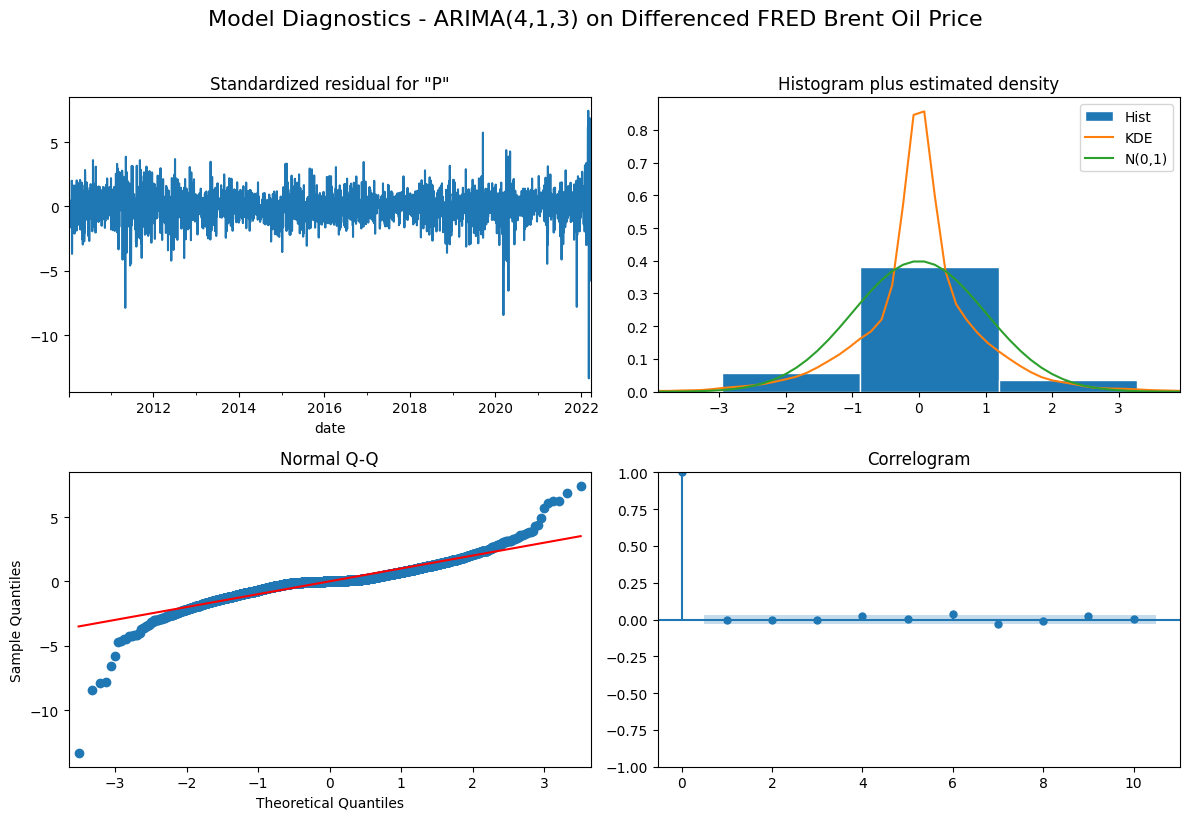

In [1226]:
fig = model_ar4_ma3.fit().plot_diagnostics(figsize=(12, 8))
fig.suptitle('Model Diagnostics - ARIMA(4,1,3) on Differenced FRED Brent Oil Price', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# SP500

In [1239]:
df_sp500_diff.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3802 entries, 2012-04-13 to 2022-09-09
Freq: D
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BKR     3802 non-null   float64
 1   COP     3802 non-null   float64
 2   CVX     3802 non-null   float64
 3   HAL     3802 non-null   float64
 4   MPC     3802 non-null   float64
 5   OXY     3802 non-null   float64
 6   PSX     3802 non-null   float64
 7   SLB     3802 non-null   float64
 8   VLO     3802 non-null   float64
 9   XOM     3802 non-null   float64
 10  BNO     3802 non-null   float64
 11  TIP     3802 non-null   float64
dtypes: float64(12)
memory usage: 386.1 KB


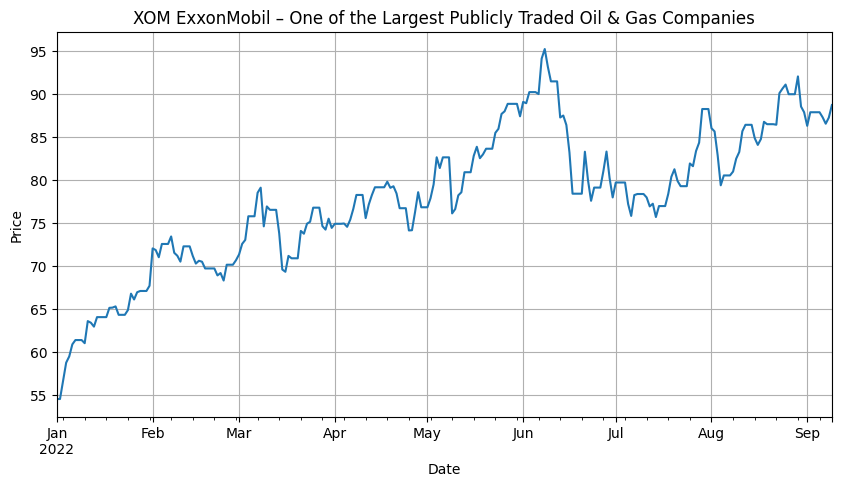

In [1269]:
df_sp500_train.loc['2022-01-01':, 'XOM'].plot(
    figsize=(10, 5), grid=True,
    title="XOM ExxonMobil – One of the Largest Publicly Traded Oil & Gas Companies"
)
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

<Axes: title={'center': 'XOM ExxonMobil One of the largest publicly traded oil & gas companies'}, xlabel='Date'>

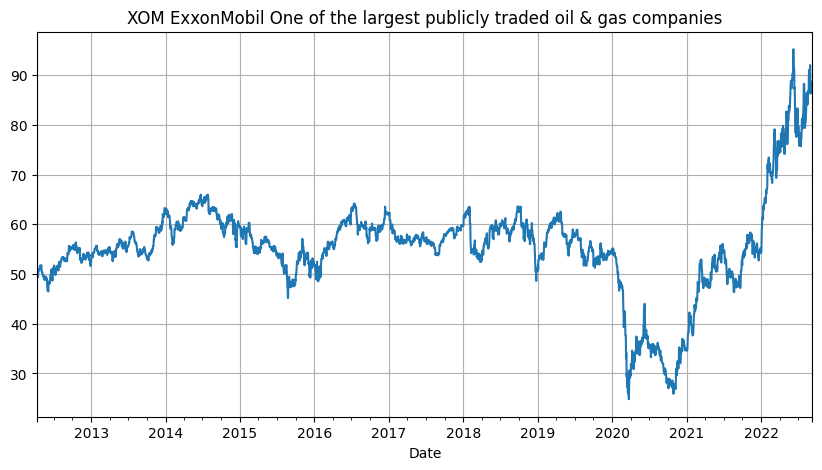

In [1259]:
df_sp500_train.XOM.plot(figsize=(10, 5), grid=True, title="XOM ExxonMobil One of the largest publicly traded oil & gas companies")

<Axes: title={'center': 'XOM - first order differenced'}, xlabel='Date'>

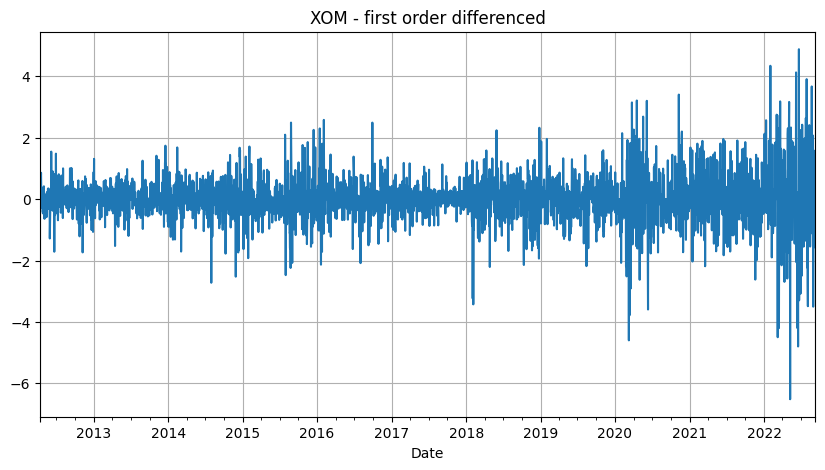

In [1283]:
df_sp500_diff.XOM.plot(figsize=(10, 5), grid=True, title='XOM - first order differenced')

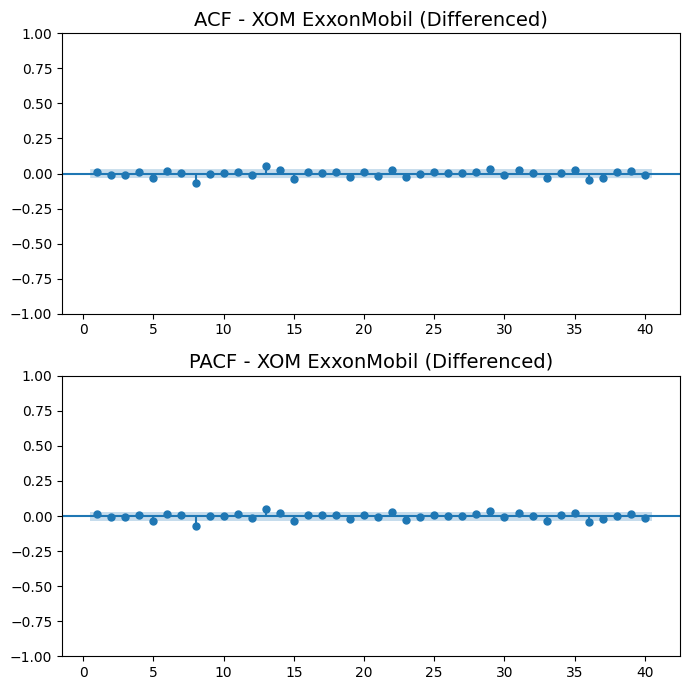

In [1285]:
fig, axes = plt.subplots(2, 1, figsize=(7, 7))
plot_acf(df_sp500_diff.XOM, ax=axes[0], lags=40, alpha=0.05, zero=False)
axes[0].set_title('ACF - XOM ExxonMobil (Differenced)', fontsize=14)
plot_pacf(df_sp500_diff.XOM, ax=axes[1], lags=40, alpha=0.05, method='ywm', zero=False)
axes[1].set_title('PACF - XOM ExxonMobil (Differenced)', fontsize=14)
plt.tight_layout()
plt.show()

In [1287]:
import pmdarima as pm

In [1289]:
results1 = pm.auto_arima(df_sp500_diff.XOM)
print(results1)

 ARIMA(0,0,0)(0,0,0)[0]          


# Resample:::

In [1298]:
dt_oil = df_oil.resample('M').mean()
dt_oil.index.freq

<MonthEnd>

In [1304]:
dt_sp500 = df_sp500.resample('M').mean()
dt_sp500.index.freq

<MonthEnd>

In [1306]:
dt_oil.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 184 entries, 2010-01-31 to 2025-04-30
Freq: ME
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   184 non-null    float64
dtypes: float64(1)
memory usage: 2.9 KB


In [1308]:
dt_sp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 157 entries, 2012-04-30 to 2025-04-30
Freq: ME
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BKR     157 non-null    float64
 1   COP     157 non-null    float64
 2   CVX     157 non-null    float64
 3   HAL     157 non-null    float64
 4   MPC     157 non-null    float64
 5   OXY     157 non-null    float64
 6   PSX     157 non-null    float64
 7   SLB     157 non-null    float64
 8   VLO     157 non-null    float64
 9   XOM     157 non-null    float64
 10  BNO     157 non-null    float64
 11  TIP     157 non-null    float64
dtypes: float64(12)
memory usage: 15.9 KB


In [1310]:
dt_oil_train, dt_oil_test = train_test_split(dt_oil, test_size=0.2, shuffle=False)
dt_sp500_train, dt_sp500_test = train_test_split(dt_sp500, test_size=0.2, shuffle=False)

In [1312]:
dt_oil_train.plot(figsize=(10, 5), grid=True); plt.tight_layout()

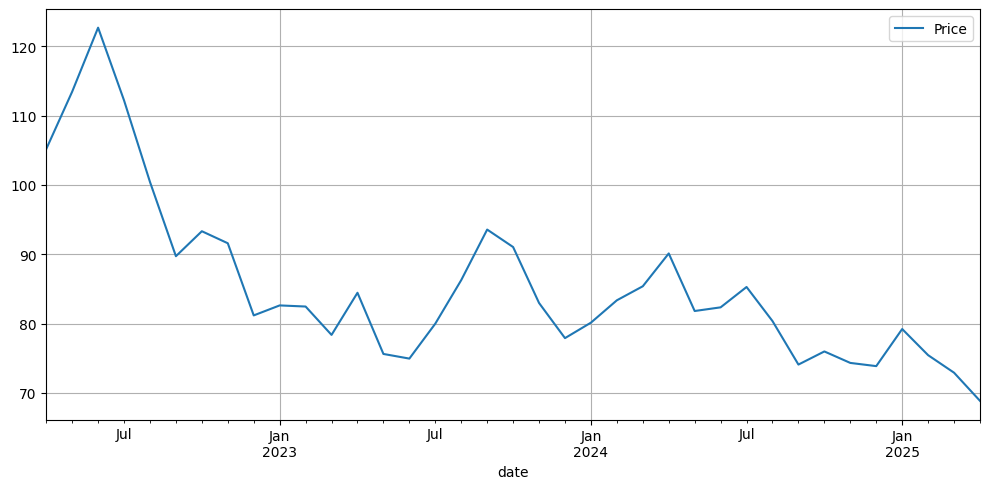

In [1314]:
dt_oil_test.plot(figsize=(10, 5), grid=True); plt.tight_layout()

In [1316]:
series = dt_oil_train.Price

In [1318]:
adf_output = adfuller(series)
kpss_output = kpss(series, regression='c')
pp_output = PhillipsPerron(series)

In [1320]:
pd.concat([
    print_results(adf_output, 'adf'),
    print_results(kpss_output, 'kpss'),
    print_results(pp_output, 'pp')
], axis=1)

adf            kpss              pp
Test Statistic              -1.284549        0.818354       -1.508317
p-value                      0.636211            0.01        0.529393
Number of lags                      2               8              14
Decision               Non-Stationary  Non-Stationary  Non-Stationary
Critical Value (1%)         -3.476598           0.739       -3.475953
Critical Value (5%)         -2.881829           0.463       -2.881548
Critical Value (10%)        -2.577589           0.347       -2.577439
Critical Value (2.5%)             NaN           0.574             NaN

In [1322]:
results = []
for col in dt_sp500_train.columns:
    series = dt_sp500_train[col]
    adf_output = adfuller(series)
    kpss_output = kpss(series, regression='c')
    pp_output = PhillipsPerron(series)
    results.append(pd.concat([
        print_results(adf_output, 'adf'),
        print_results(kpss_output, 'kpss'),
        print_results(pp_output, 'pp')
    ], axis=1))
stationarity_results = pd.concat(results, axis=0)
stationarity_results

adf            kpss              pp
Test Statistic              -2.314807        0.650097       -1.996115
p-value                      0.167237        0.018082        0.288279
Number of lags                      1               6              13
Decision               Non-Stationary  Non-Stationary  Non-Stationary
Critical Value (1%)         -3.484667           0.739        -3.48422
...                               ...             ...             ...
Decision               Non-Stationary  Non-Stationary  Non-Stationary
Critical Value (1%)         -3.484667           0.739        -3.48422
Critical Value (5%)          -2.88534           0.463       -2.885145
Critical Value (10%)        -2.579463           0.347       -2.579359
Critical Value (2.5%)             NaN           0.574             NaN

[96 rows x 3 columns]

In [1324]:
dt_sp500_diff = dt_sp500_train.diff().dropna()
dt_oil_diff = dt_oil_train.diff().dropna()

In [1326]:
series = dt_oil_diff.Price
adf_output = adfuller(series)
kpss_output = kpss(series, regression='c')
pp_output = PhillipsPerron(series)
pd.concat([
    print_results(adf_output, 'adf'),
    print_results(kpss_output, 'kpss'),
    print_results(pp_output, 'pp')
], axis=1)

adf        kpss          pp
Test Statistic          -7.801234    0.204881   -7.442325
p-value                       0.0         0.1         0.0
Number of lags                  1           2          14
Decision               Stationary  Stationary  Stationary
Critical Value (1%)     -3.476598       0.739   -3.476273
Critical Value (5%)     -2.881829       0.463   -2.881688
Critical Value (10%)    -2.577589       0.347   -2.577513
Critical Value (2.5%)         NaN       0.574         NaN

In [1330]:
results = []
for col in dt_sp500_diff.columns:
    series = dt_sp500_diff[col]
    adf_output = adfuller(series)
    kpss_output = kpss(series, regression='c')
    pp_output = PhillipsPerron(series)
    results.append(pd.concat([
        print_results(adf_output, 'adf'),
        print_results(kpss_output, 'kpss'),
        print_results(pp_output, 'pp')
    ], axis=1))
stationarity_results = pd.concat(results, axis=0)
stationarity_results

adf        kpss          pp
Test Statistic          -9.067548    0.077869   -8.884549
p-value                       0.0         0.1         0.0
Number of lags                  0           1          13
Decision               Stationary  Stationary  Stationary
Critical Value (1%)     -3.484667       0.739   -3.484667
...                           ...         ...         ...
Decision               Stationary  Stationary  Stationary
Critical Value (1%)     -3.485585       0.739   -3.484667
Critical Value (5%)     -2.885739       0.463    -2.88534
Critical Value (10%)    -2.579676       0.347   -2.579463
Critical Value (2.5%)         NaN       0.574         NaN

[96 rows x 3 columns]

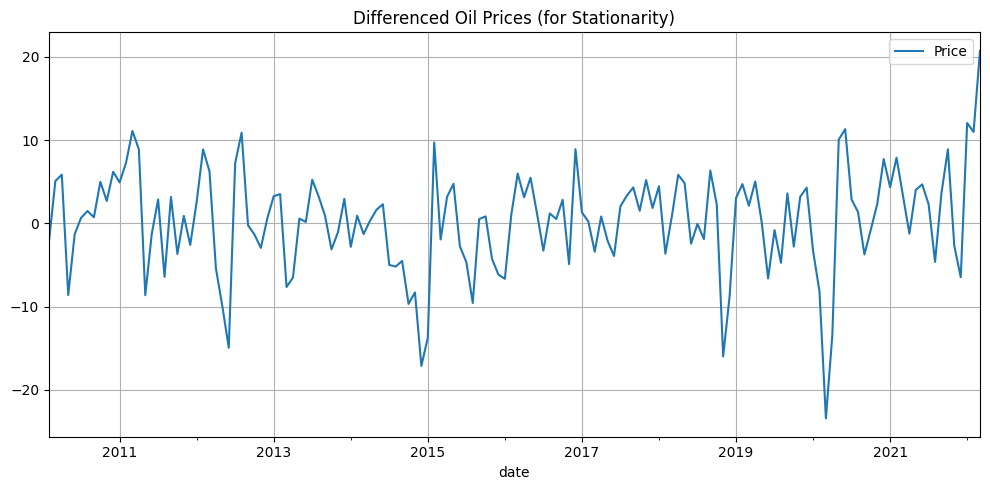

In [1332]:
dt_oil_diff.plot(figsize=(10, 5), grid=True, title="Differenced Oil Prices (for Stationarity)"); plt.tight_layout()

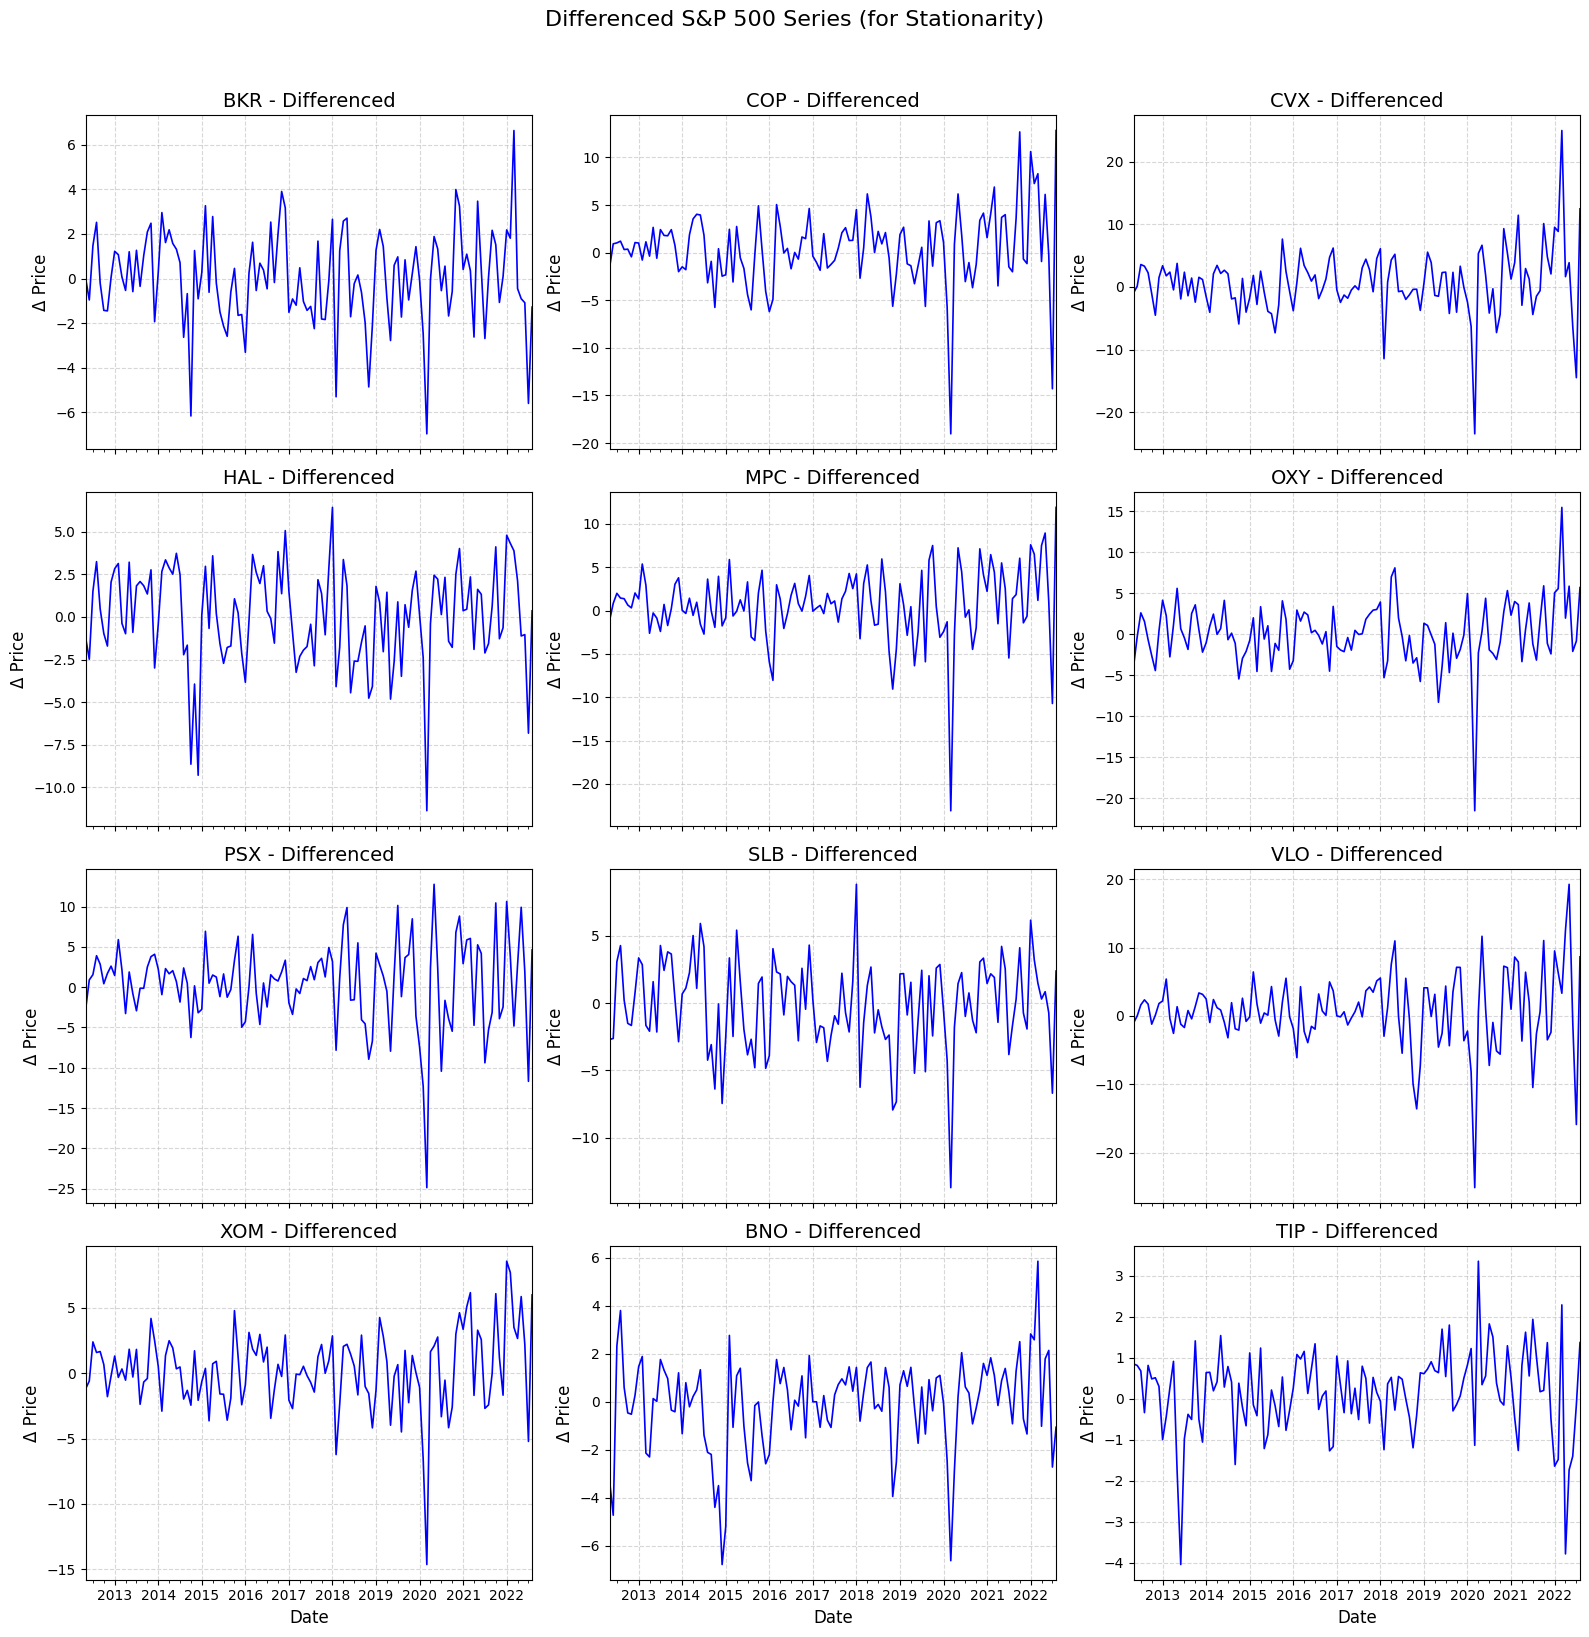

In [1334]:
cols = dt_sp500_diff.columns
n = len(cols)
rows = (n + 2) // 3
fig, axes = plt.subplots(rows, 3, figsize=(16, 4 * rows), sharex=True)
axes = axes.flatten()
for i, col in enumerate(cols):
    dt_sp500_diff[col].plot(ax=axes[i], color='blue', linewidth=1.2)
    axes[i].set_title(f'{col} - Differenced', fontsize=14)
    axes[i].set_xlabel('Date', fontsize=12)
    axes[i].set_ylabel('Δ Price', fontsize=12)
    axes[i].grid(True, linestyle='--', alpha=0.5)

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Differenced S&P 500 Series (for Stationarity)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

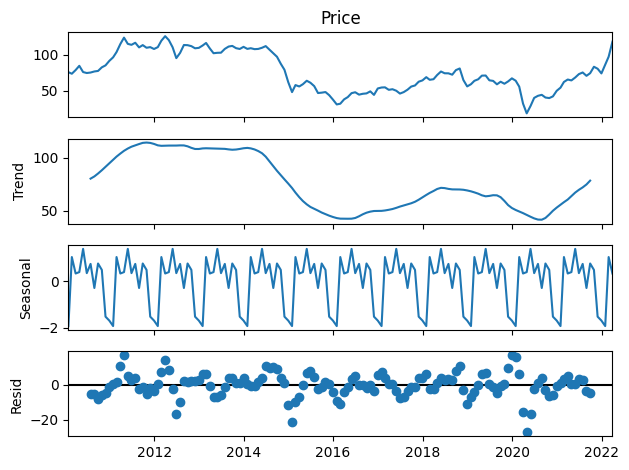

In [1336]:
oil_decomposed = seasonal_decompose(dt_oil_train.Price, model='additive')
oil_decomposed.plot().show()

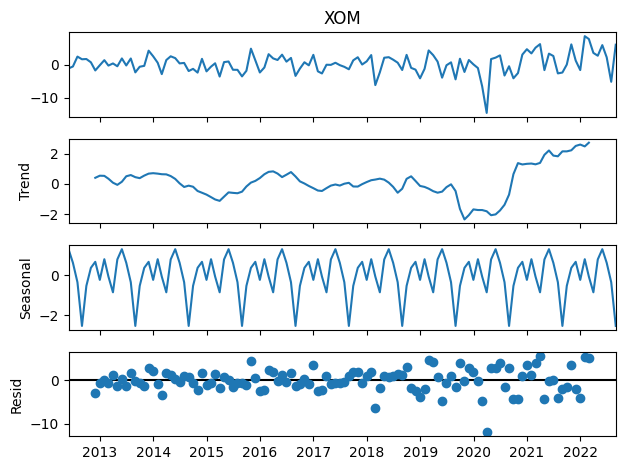

In [1338]:
xom_decomposed = seasonal_decompose(dt_sp500_diff.XOM, model='additive')
xom_decomposed.plot().show()

In [1340]:
(oil_decomposed.trend).plot(color='blue', grid=True, title='Trend decomposed from Oil Prices', figsize=(10, 5))
plt.tight_layout();

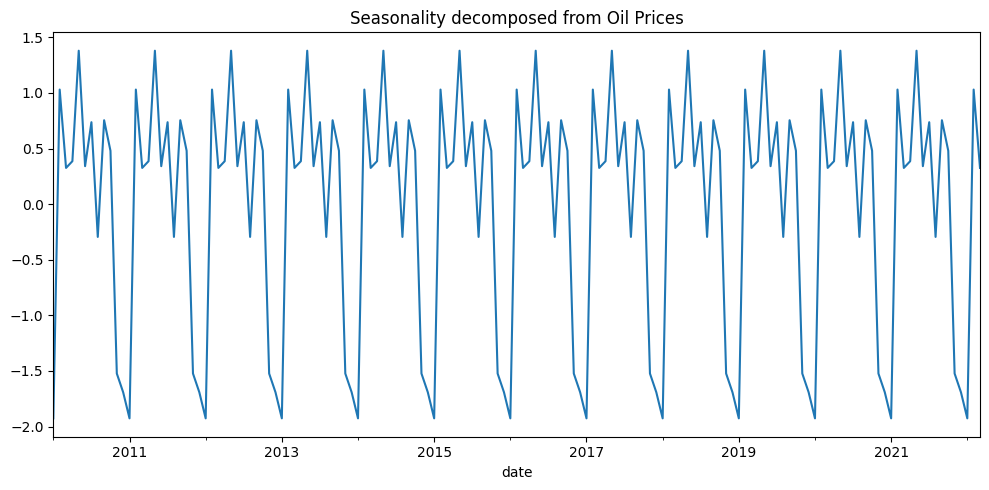

In [1342]:
(oil_decomposed.seasonal).plot(title='Seasonality decomposed from Oil Prices', figsize=(10, 5)); plt.tight_layout()

In [1344]:
(oil_decomposed.resid).plot(title='Resid decomposed from Oil Prices', figsize=(10, 5)); plt.tight_layout()

In [1346]:
(oil_decomposed.trend + oil_decomposed.seasonal + oil_decomposed.resid).plot(figsize=(10, 5), 
                            title='Trend + Seasonality + Residuals')

<Axes: title={'center': 'Trend + Seasonality + Residuals'}, xlabel='date'>

In [1352]:
adf_result_for_oil = adfuller(dt_oil_diff.Price, store=True)

In [1354]:
adf_result_for_oil

(-7.801234090481725,
 7.4837109345705e-12,
 {'1%': -3.476597917537401,
  '5%': -2.8818291230495543,
  '10%': -2.5775887982253085},
 <statsmodels.stats.diagnostic.ResultsStore at 0x1bf44950da0>)

In [1356]:
print(adf_result_for_oil[-1].resols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     33.57
Date:                Sat, 19 Apr 2025   Prob (F-statistic):           1.19e-12
Time:                        06:03:27   Log-Likelihood:                -454.60
No. Observations:                 144   AIC:                             915.2
Df Residuals:                     141   BIC:                             924.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.7633      0.098     -7.801      0.0

In [1358]:
adf_result_for_sp500_TIP = adfuller(dt_sp500_diff.TIP, store=True)

In [1360]:
adf_result_for_sp500_TIP

(-4.974290376759665,
 2.4945628254427312e-05,
 {'1%': -3.485585145896754,
  '5%': -2.885738566292665,
  '10%': -2.5796759080663887},
 <statsmodels.stats.diagnostic.ResultsStore at 0x1bf41b21370>)

In [1362]:
print(adf_result_for_sp500_TIP[-1].resols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     30.26
Date:                Sat, 19 Apr 2025   Prob (F-statistic):           1.49e-14
Time:                        06:04:01   Log-Likelihood:                -174.51
No. Observations:                 121   AIC:                             357.0
Df Residuals:                     117   BIC:                             368.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.6998      0.141     -4.974      0.0

In [1364]:
shapiro(dt_oil_diff.Price)

ShapiroResult(statistic=0.9709938880135829, pvalue=0.0034529589332598413)

In [1366]:
print(is_normal(shapiro(dt_oil_diff.Price)))

Not Normal


# dt Oil

In [1375]:
fig, axes = plt.subplots(2, 1, figsize=(7, 7))
plot_acf(dt_oil_diff['Price'], ax=axes[0], lags=48, alpha=0.05, zero=False)
axes[0].set_title('ACF - FRED Brent Oil (Differenced, Monthly)', fontsize=14)
axes[0].grid(True, linestyle='--', alpha=0.5)
plot_pacf(dt_oil_diff['Price'], ax=axes[1], lags=48, alpha=0.05, method='ywm', zero=False)
axes[1].set_title('PACF - FRED Brent Oil (Differenced, Monthly)', fontsize=14)
axes[1].grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [1379]:
model_ar1_i_ma1 = SARIMAX(dt_oil_train.Price, order=(1, 1, 1))
print(model_ar1_i_ma1.fit().summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  147
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -461.580
Date:                Sat, 19 Apr 2025   AIC                            929.159
Time:                        06:15:50   BIC                            938.110
Sample:                    01-31-2010   HQIC                           932.796
                         - 03-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0633      0.138      0.459      0.647      -0.207       0.334
ma.L1          0.3832      0.152      2.525      0.012       0.086       0.681
sigma2        32.5796      3.018     10.797      0.0

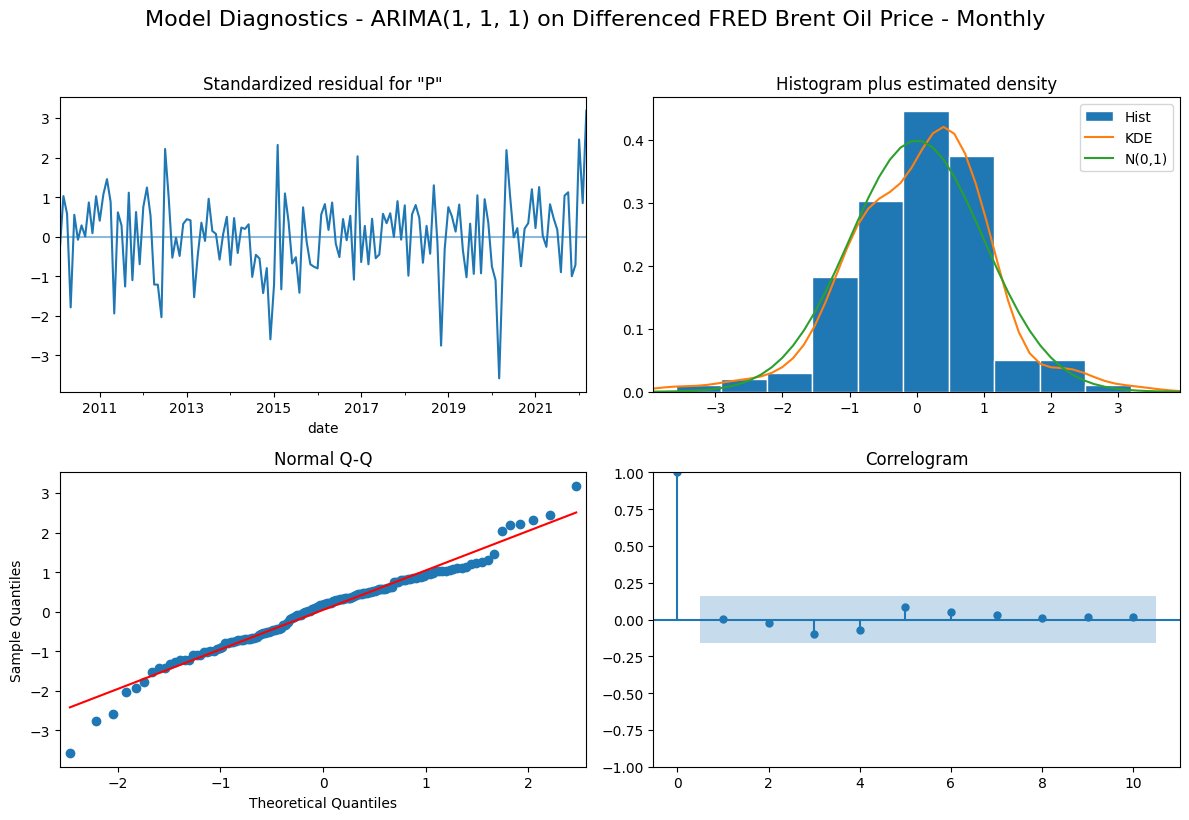

In [1385]:
fig = model_ar1_i_ma1.fit().plot_diagnostics(figsize=(12, 8))
fig.suptitle('Model Diagnostics - ARIMA(1, 1, 1) on Differenced FRED Brent Oil Price - Monthly', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [1387]:
model_ar2_i_ma1 = SARIMAX(dt_oil_train.Price, order=(2, 1, 1))
print(model_ar2_i_ma1.fit().summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  147
Model:               SARIMAX(2, 1, 1)   Log Likelihood                -460.494
Date:                Sat, 19 Apr 2025   AIC                            928.987
Time:                        06:17:41   BIC                            940.922
Sample:                    01-31-2010   HQIC                           933.836
                         - 03-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6482      0.373      1.739      0.082      -0.082       1.379
ar.L2         -0.2907      0.139     -2.086      0.037      -0.564      -0.018
ma.L1         -0.2116      0.404     -0.524      0.6

In [1393]:
# fig = model_ar2_i_ma1.fit().plot_diagnostics(figsize=(12, 8))
# fig.suptitle('Model Diagnostics - ARIMA(2, 1, 1) on Differenced FRED Brent Oil Price - Monthly', fontsize=16, y=1.02)
# plt.tight_layout()
# plt.show()

In [1395]:
model_s12_ar1_i_ma1 = SARIMAX(dt_oil_train.Price, order=(1, 1, 1), seasonal_order=(1, 0, 1, 12))
print(model_s12_ar1_i_ma1.fit().summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Price   No. Observations:                  147
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -460.817
Date:                            Sat, 19 Apr 2025   AIC                            931.634
Time:                                    06:21:21   BIC                            946.552
Sample:                                01-31-2010   HQIC                           937.696
                                     - 03-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0881      0.156      0.566      0.571      -0.217       0.393
ma.L1          0.3337      0.168   

In [1397]:
fig = model_s12_ar1_i_ma1.fit().plot_diagnostics(figsize=(12, 8))
fig.suptitle('Model Diagnostics - SARIMA(1, 1, 1),(1, 0, 1, 12) on Differenced FRED Brent Oil Price - Monthly', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [1399]:
model_s12_ar2_i_ma1 = SARIMAX(dt_oil_train.Price, order=(2, 1, 1), seasonal_order=(2, 0, 1, 12))
print(model_s12_ar2_i_ma1.fit().summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Price   No. Observations:                  147
Model:             SARIMAX(2, 1, 1)x(2, 0, 1, 12)   Log Likelihood                -457.830
Date:                            Sat, 19 Apr 2025   AIC                            929.660
Time:                                    06:22:52   BIC                            950.545
Sample:                                01-31-2010   HQIC                           938.146
                                     - 03-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6788      0.414      1.641      0.101      -0.132       1.490
ar.L2         -0.2962      0.123   

In [1401]:
LLR_test(model_ar1_i_ma1, model_ar2_i_ma1)

0.141

In [1403]:
LLR_test(model_ar2_i_ma1, model_ar1_i_ma1)

1.0

In [1405]:
LLR_test(model_ar2_i_ma1, model_s12_ar1_i_ma1)

1.0

In [1407]:
LLR_test(model_s12_ar1_i_ma1, model_ar2_i_ma1)

0.421

In [1409]:
LLR_test(model_s12_ar1_i_ma1, model_s12_ar2_i_ma1)

0.015

In [1411]:
LLR_test(model_s12_ar2_i_ma1, model_s12_ar1_i_ma1)

1.0

In [1415]:
LLR_test(model_s12_ar2_i_ma1, model_ar2_i_ma1)

1.0

In [1413]:
LLR_test(model_ar2_i_ma1, model_s12_ar2_i_ma1)

0.021

=>>> model_s12_ar2_i_ma1

In [1426]:
oil_pmdarima_result1 = pm.auto_arima(dt_oil_train.Price)
print(oil_pmdarima_result1)

 ARIMA(0,1,1)(0,0,0)[0]          


In [1428]:
oil_pmdarima_result2 = pm.auto_arima(dt_oil_train.Price,
    d = 1,    # non-seasonal difference order
    start_p = 1,
    start_q = 1, 
    max_p = 5, 
    max_q = 5,
    seasonal = True, 
    m = 12, 
    D = 0, 
    start_P = 1, 
    start_Q = 1,
    max_P = 5, 
    max_Q = 5,
    information_criterion = 'aic', # used to select best model
    trace = True,  # print results whilst training
    error_action = 'ignore',  #ignore orders that don't work
    stepwise = True  # apply intelligent order search
                       )

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=933.407, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=951.800, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=934.797, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=930.724, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=950.112, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=929.026, Time=0.10 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=930.830, Time=0.08 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=931.607, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=930.924, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=930.880, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=933.416, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=932.822, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=927.270, Time=0.03 sec
 ARIMA(0,1,1)(1,0,0)[12]             : AIC=929.085, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[12]         

In [1430]:
pm_model_arima = SARIMAX(dt_oil_train.Price, order=(0, 1, 1))
print(pm_model_arima.fit().summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  147
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -461.635
Date:                Sat, 19 Apr 2025   AIC                            927.270
Time:                        06:31:51   BIC                            933.237
Sample:                    01-31-2010   HQIC                           929.694
                         - 03-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4339      0.084      5.184      0.000       0.270       0.598
sigma2        32.6046      3.004     10.852      0.000      26.716      38.493
Ljung-Box (L1) (Q):                   0.03   Jarque-

In [1432]:
pm_model_sarima = SARIMAX(dt_oil_train.Price, order=(0, 1, 1), seasonal_order=(0, 0, 0, 12))
print(pm_model_sarima.fit().summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  147
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -461.635
Date:                Sat, 19 Apr 2025   AIC                            927.270
Time:                        06:33:08   BIC                            933.237
Sample:                    01-31-2010   HQIC                           929.694
                         - 03-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4339      0.084      5.184      0.000       0.270       0.598
sigma2        32.6046      3.004     10.852      0.000      26.716      38.493
Ljung-Box (L1) (Q):                   0.03   Jarque-

In [1442]:
LLR_test(model_s12_ar2_i_ma1, pm_model_arima)

1.0

In [1436]:
LLR_test(model_s12_ar2_i_ma1, pm_model_sarima)

1.0

In [1444]:
LLR_test(pm_model_arima, model_s12_ar2_i_ma1)

0.006

In [1446]:
LLR_test(pm_model_sarima, model_s12_ar2_i_ma1)

0.006

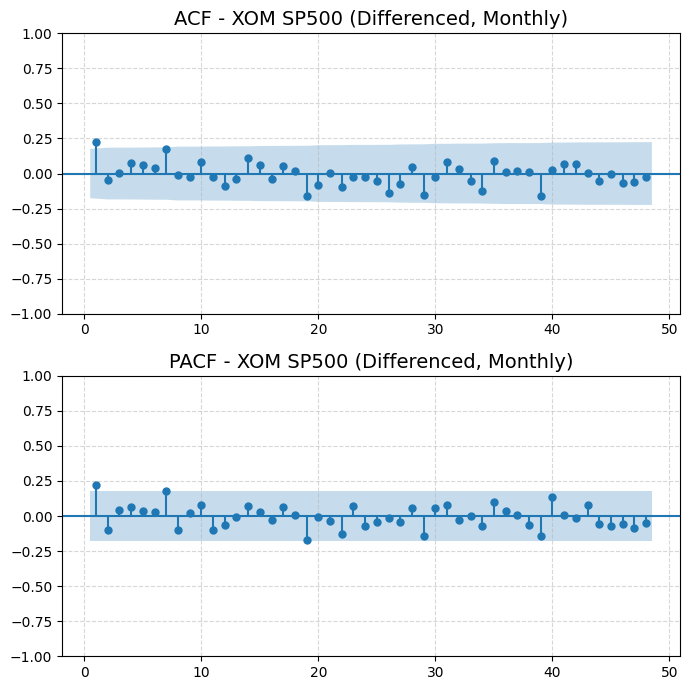

In [1450]:
fig, axes = plt.subplots(2, 1, figsize=(7, 7))
plot_acf(dt_sp500_diff['XOM'], ax=axes[0], lags=48, alpha=0.05, zero=False)
axes[0].set_title('ACF - XOM SP500 (Differenced, Monthly)', fontsize=14)
axes[0].grid(True, linestyle='--', alpha=0.5)
plot_pacf(dt_sp500_diff['XOM'], ax=axes[1], lags=48, alpha=0.05, method='ywm', zero=False)
axes[1].set_title('PACF - XOM SP500 (Differenced, Monthly)', fontsize=14)
axes[1].grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [1452]:
xom_model_arima = SARIMAX(dt_sp500_train.XOM, order=(1, 1, 1))
print(xom_model_arima.fit().summary())

                               SARIMAX Results                                
Dep. Variable:                    XOM   No. Observations:                  125
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -310.031
Date:                Sat, 19 Apr 2025   AIC                            626.062
Time:                        06:45:36   BIC                            634.523
Sample:                    04-30-2012   HQIC                           629.499
                         - 08-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1587      0.317     -0.500      0.617      -0.781       0.463
ma.L1          0.4260      0.326      1.309      0.191      -0.212       1.064
sigma2         8.6878      0.821     10.581      0.0

In [1468]:
xom_model_sarima = SARIMAX(dt_sp500_train.XOM, order=(1, 1, 1), seasonal_order=(1, 0, 1, 12))
print(xom_model_sarima.fit().summary())

                                     SARIMAX Results                                      
Dep. Variable:                                XOM   No. Observations:                  125
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -309.587
Date:                            Sat, 19 Apr 2025   AIC                            629.175
Time:                                    06:49:23   BIC                            643.276
Sample:                                04-30-2012   HQIC                           634.903
                                     - 08-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1535      0.344     -0.446      0.656      -0.828       0.521
ma.L1          0.4142      0.352   

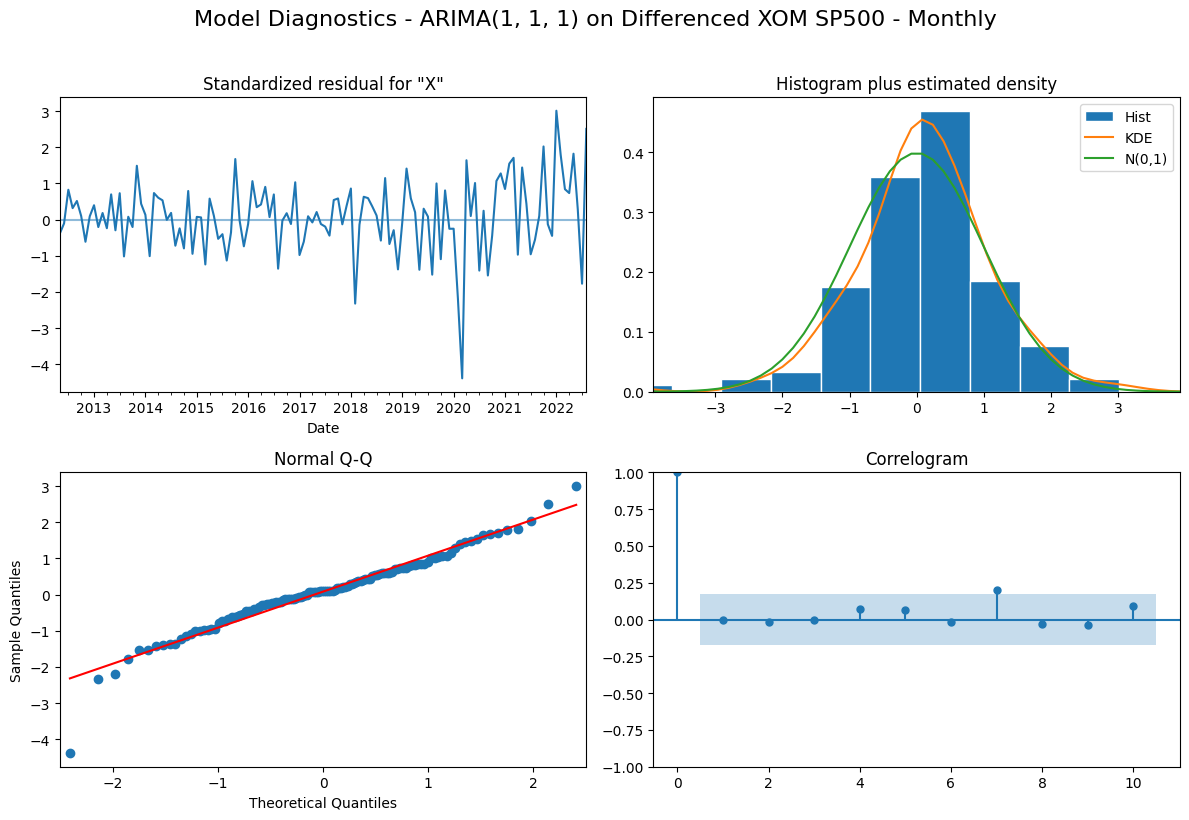

In [1456]:
fig = xom_model_arima.fit().plot_diagnostics(figsize=(12, 8))
fig.suptitle('Model Diagnostics - ARIMA(1, 1, 1) on Differenced XOM SP500 - Monthly', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

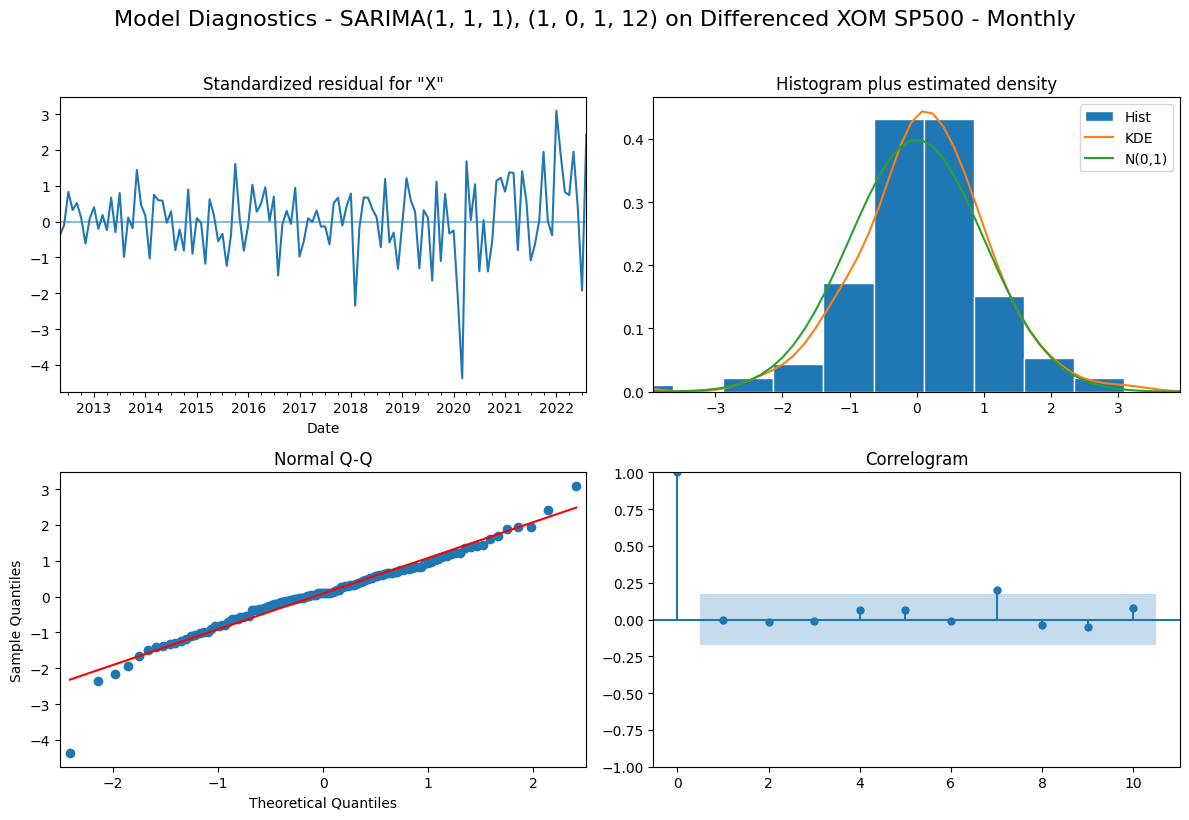

In [1470]:
fig = xom_model_sarima.fit().plot_diagnostics(figsize=(12, 8))
fig.suptitle('Model Diagnostics - SARIMA(1, 1, 1), (1, 0, 1, 12) on Differenced XOM SP500 - Monthly', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [1474]:
LLR_test(xom_model_arima, xom_model_sarima)

0.346

In [1476]:
LLR_test(xom_model_sarima, xom_model_arima)

1.0

In [1478]:
xom_pmdarima_result = pm.auto_arima(dt_sp500_train.XOM,
    d = 1,    # non-seasonal difference order
    start_p = 1,
    start_q = 1, 
    max_p = 5, 
    max_q = 5,
    seasonal = True, 
    m = 12, 
    D = 0, 
    start_P = 1, 
    start_Q = 1,
    max_P = 5, 
    max_Q = 5,
    information_criterion = 'aic', # used to select best model
    trace = True,  # print results whilst training
    error_action = 'ignore',  #ignore orders that don't work
    stepwise = True  # apply intelligent order search
                       )

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=630.347, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=631.271, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=627.911, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=626.791, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=630.353, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=625.515, Time=0.04 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=626.850, Time=0.13 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=628.618, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=627.217, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=627.182, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=626.859, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=629.180, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=624.297, Time=0.02 sec
 ARIMA(0,1,1)(1,0,0)[12]             : AIC=625.640, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[12]         

In [1480]:
xom_model_sarimax = SARIMAX(dt_sp500_train.XOM, order=(1,1,1),seasonal_order=(1,0,1,12), exog=dt_sp500_train.TIP)
print(xom_model_sarimax.fit().summary())

                                     SARIMAX Results                                      
Dep. Variable:                                XOM   No. Observations:                  125
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -309.575
Date:                            Sat, 19 Apr 2025   AIC                            631.150
Time:                                    06:52:00   BIC                            648.072
Sample:                                04-30-2012   HQIC                           638.024
                                     - 08-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
TIP            0.0411      0.234      0.176      0.861      -0.417       0.500
ar.L1         -0.1478      0.345   

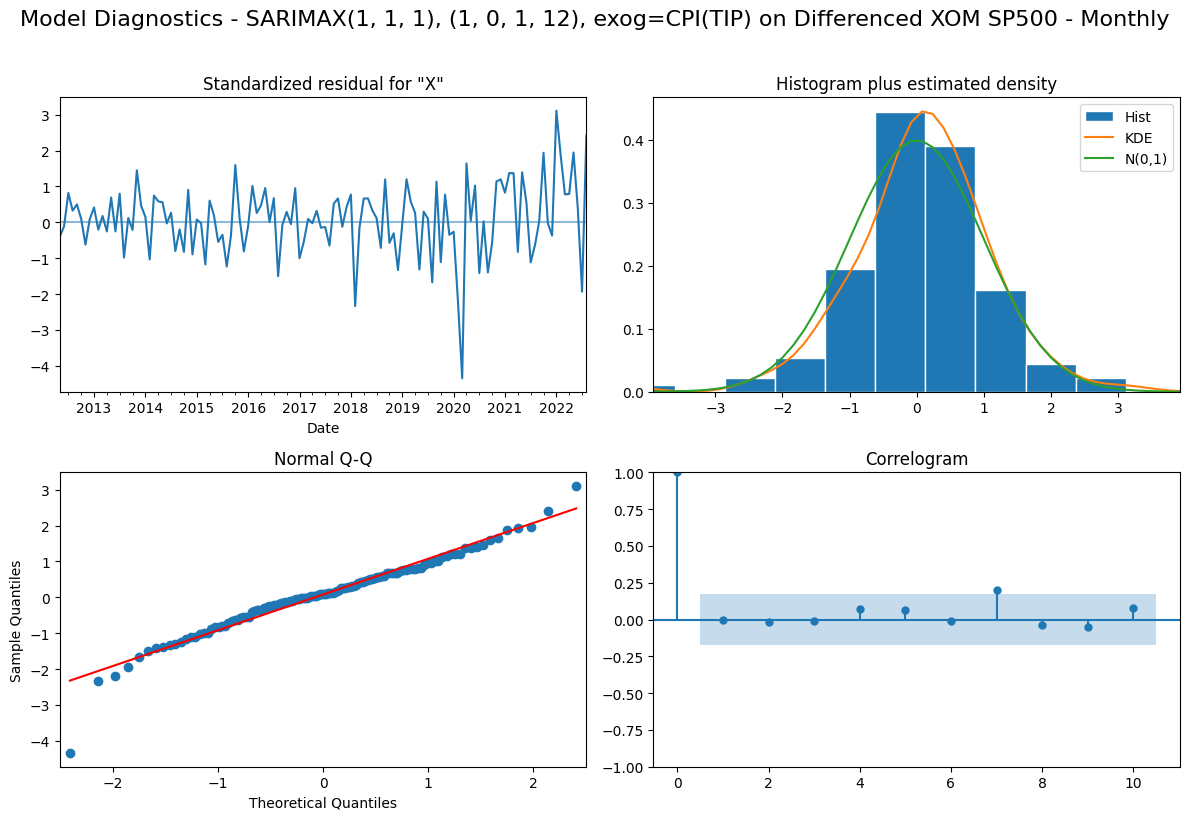

In [1482]:
fig = xom_model_sarimax.fit().plot_diagnostics(figsize=(12, 8))
fig.suptitle('Model Diagnostics - SARIMAX(1, 1, 1), (1, 0, 1, 12), exog=CPI(TIP) on Differenced XOM SP500 - Monthly', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [1488]:
LLR_test(xom_model_sarima, xom_model_sarimax)

0.876

In [1490]:
LLR_test(xom_model_sarimax, xom_model_sarima)

1.0

In [1492]:
xom_model_sarimax

In [1494]:
model_s12_ar2_i_ma1

In [1502]:
oil_train_start = '2010-01-31'
oil_test_start = '2022-04-30'
oil_test_end = '2025-04-30'

In [1510]:
xom_train_start = '2012-04-30'
xom_test_start = '2022-09-30'
xom_test_end = '2025-04-30'

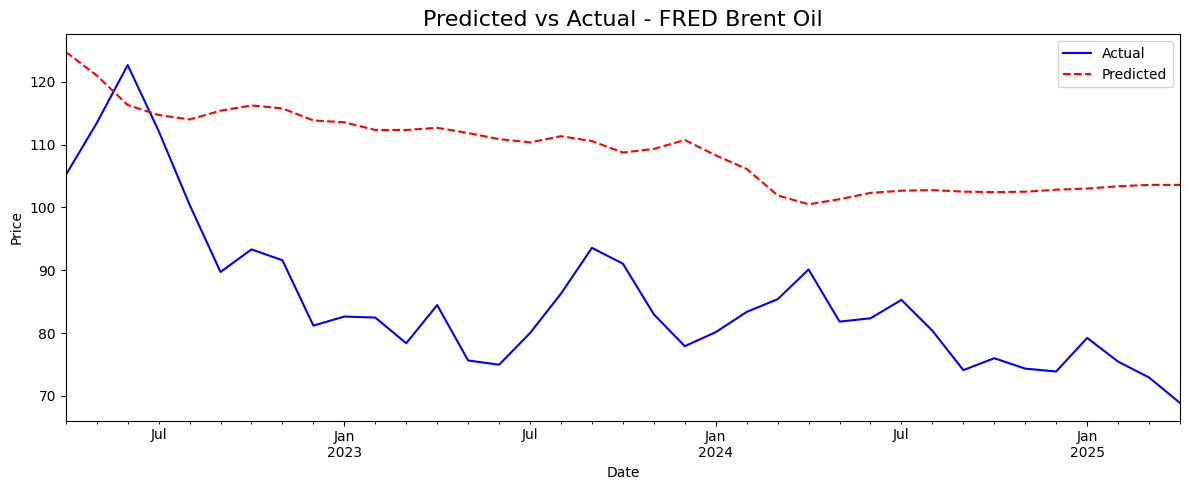

In [1546]:
dt_pred_oil = model_s12_ar2_i_ma1.fit().predict(start=oil_test_start, end=oil_test_end)
plt.figure(figsize=(12, 5))
dt_oil_test['Price'].plot(label='Actual', color='blue')
dt_pred_oil.plot(label='Predicted', color='red', linestyle='--')
plt.title('Predicted vs Actual - FRED Brent Oil', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

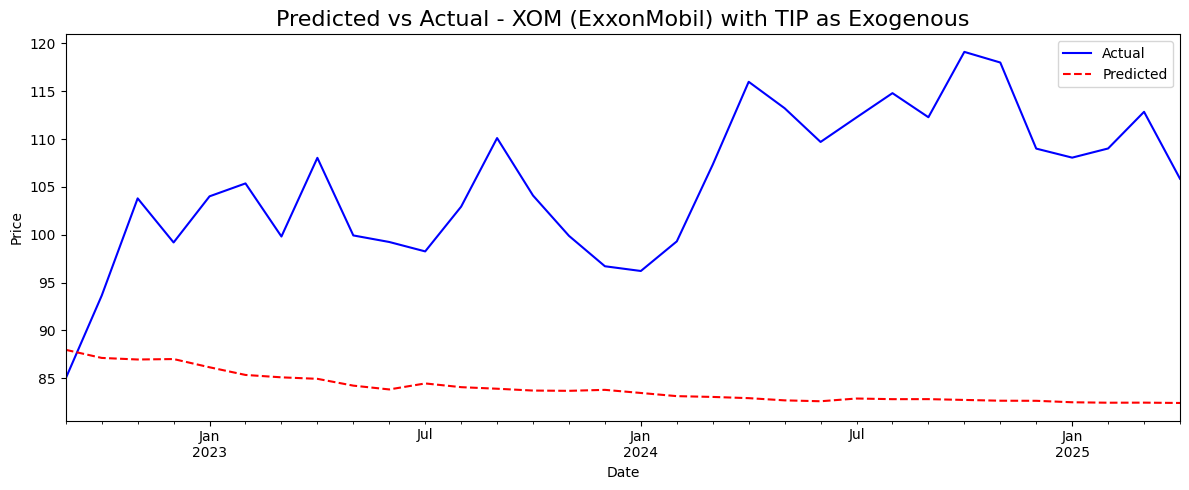

In [1544]:
xom_model_sarimax_fit = xom_model_sarimax.fit(
    exog=dt_sp500_train[['TIP']]
)
xom_pred = xom_model_sarimax_fit.predict(
    start=xom_test_start, 
    end=xom_test_end, 
    exog=dt_sp500_test[['TIP']]
)
plt.figure(figsize=(12, 5))
dt_sp500_test['XOM'].plot(label='Actual', color='blue')
xom_pred.plot(label='Predicted', color='red', linestyle='--')
plt.title('Predicted vs Actual - XOM (ExxonMobil) with TIP as Exogenous', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

In [1554]:
print(xom_pmdarima_result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  125
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -310.149
Date:                Sat, 19 Apr 2025   AIC                            624.297
Time:                        07:19:48   BIC                            629.938
Sample:                    04-30-2012   HQIC                           626.588
                         - 08-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2784      0.071      3.904      0.000       0.139       0.418
sigma2         8.7047      0.780     11.160      0.000       7.176      10.234
Ljung-Box (L1) (Q):                   0.03   Jarque-

In [1556]:
print(oil_pmdarima_result2.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  147
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -461.635
Date:                Sat, 19 Apr 2025   AIC                            927.270
Time:                        07:19:56   BIC                            933.237
Sample:                    01-31-2010   HQIC                           929.694
                         - 03-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4339      0.084      5.184      0.000       0.270       0.598
sigma2        32.6046      3.004     10.852      0.000      26.716      38.493
Ljung-Box (L1) (Q):                   0.03   Jarque-

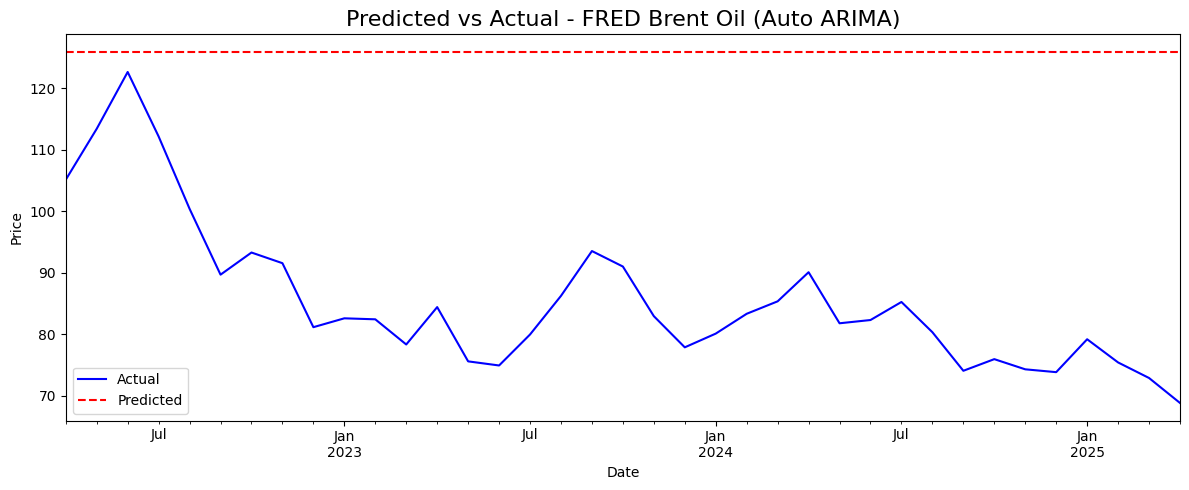

In [1560]:
n_test = len(dt_oil_test)
dt_pred_oil = pd.Series(
    oil_pmdarima_result2.predict(n_periods=n_test),
    index=dt_oil_test.index
)
plt.figure(figsize=(12, 5))
dt_oil_test['Price'].plot(label='Actual', color='blue')
dt_pred_oil.plot(label='Predicted', color='red', linestyle='--')
plt.title('Predicted vs Actual - FRED Brent Oil (Auto ARIMA)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

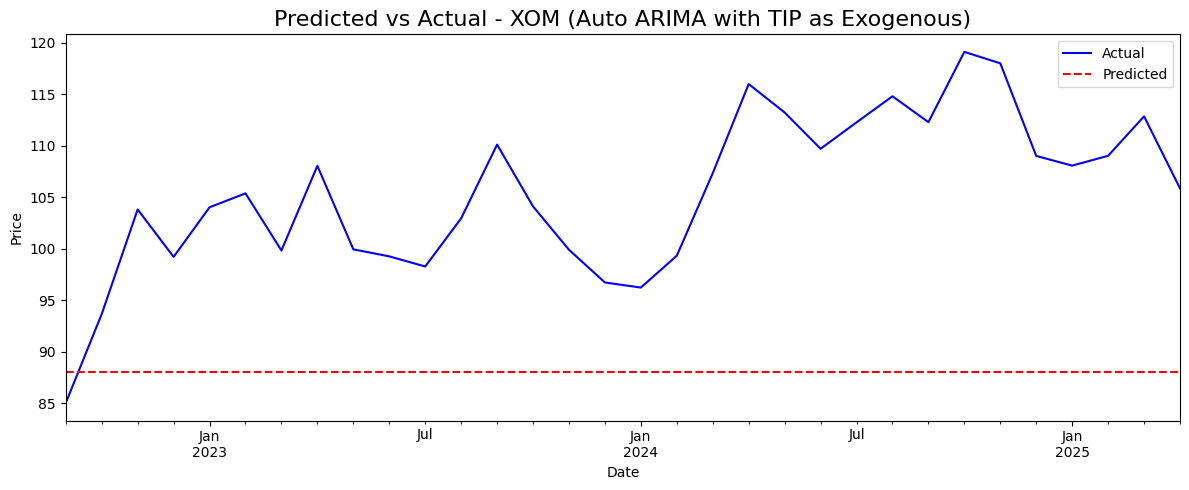

In [1562]:
n_test = len(dt_sp500_test)
xom_pred_pmdarima = pd.Series(
    xom_pmdarima_result.predict(n_periods=n_test, exogenous=dt_sp500_test[['TIP']]),
    index=dt_sp500_test.index
)
plt.figure(figsize=(12, 5))
dt_sp500_test['XOM'].plot(label='Actual', color='blue')
xom_pred_pmdarima.plot(label='Predicted', color='red', linestyle='--')
plt.title('Predicted vs Actual - XOM (Auto ARIMA with TIP as Exogenous)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

In [1568]:
model_ar4_i_ma3 = SARIMAX(df_oil_train.Price, order=(4, 1, 3))
result_ar4_i_ma3 = model_ar4_i_ma3.fit()
print(result_ar4_i_ma3.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 4464
Model:               SARIMAX(4, 1, 3)   Log Likelihood               -7225.905
Date:                Sat, 19 Apr 2025   AIC                          14467.811
Time:                        07:25:55   BIC                          14519.039
Sample:                    01-04-2010   HQIC                         14485.869
                         - 03-25-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3756      0.071     -5.263      0.000      -0.515      -0.236
ar.L2         -0.4754      0.044    -10.826      0.000      -0.561      -0.389
ar.L3         -0.9321      0.073    -12.773      0.0

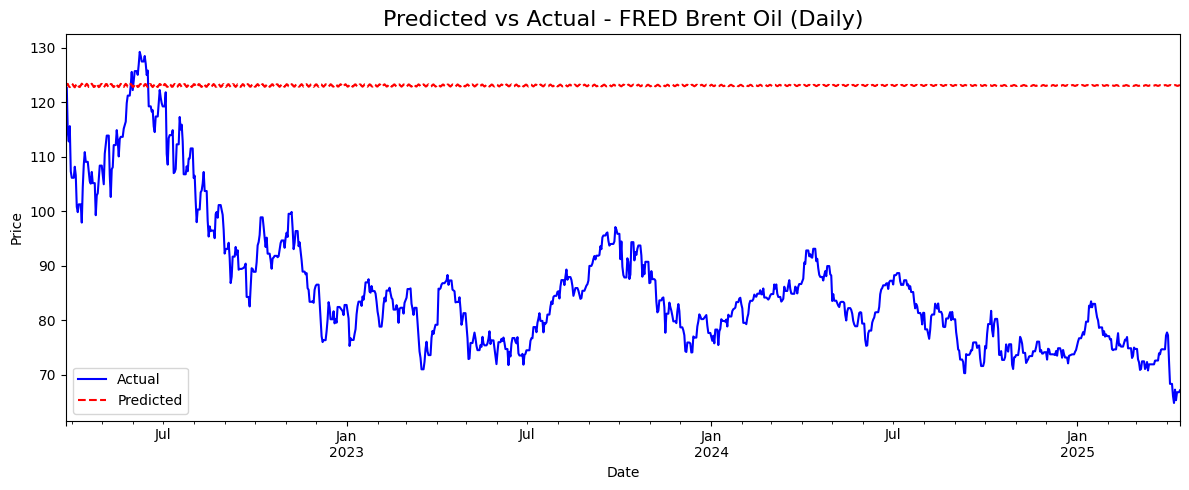

In [1578]:
df_pred_oil = model_ar4_i_ma3.fit().predict(start='2022-03-26', end='2025-04-14')
plt.figure(figsize=(12, 5))
df_oil_test['Price'].plot(label='Actual', color='blue')
df_pred_oil.plot(label='Predicted', color='red', linestyle='--')
plt.title('Predicted vs Actual - FRED Brent Oil (Daily)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

In [1590]:
# model = ARDL(
#     endog=dt_sp500_train['XOM'], 
#     lags=4,  # Example lag
#     exog=dt_oil_train['Price'], 
#     exog_lags=4
# ).fit()
# print(model.summary())

In [1610]:
dt_oil_train.Price.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 147 entries, 2010-01-31 to 2022-03-31
Freq: ME
Series name: Price
Non-Null Count  Dtype  
--------------  -----  
147 non-null    float64
dtypes: float64(1)
memory usage: 6.4 KB


In [1612]:
dt_sp500_train.XOM.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 125 entries, 2012-04-30 to 2022-08-31
Freq: ME
Series name: XOM
Non-Null Count  Dtype  
--------------  -----  
125 non-null    float64
dtypes: float64(1)
memory usage: 6.0 KB


In [1580]:
from statsmodels.tsa.ardl import ARDL

In [1725]:
# Align both series to common range
common_start = '2012-04-30'
common_end = '2022-03-31'
xom_aligned = dt_sp500_train['XOM'].loc[common_start:common_end]
oil_aligned = dt_oil_train['Price'].loc[common_start:common_end]
oil_aligned_df = oil_aligned.to_frame()  
order = {'Price': list(range(1, 10))}  
model = ARDL(endog=xom_aligned, exog=oil_aligned_df, lags=10, order=order).fit()
print(model.summary())

                              ARDL Model Results                              
Dep. Variable:                    XOM   No. Observations:                  120
Model:                    ARDL(10, 9)   Log Likelihood                -265.454
Method:               Conditional MLE   S.D. of innovations              2.703
Date:                Sat, 19 Apr 2025   AIC                            572.908
Time:                        08:36:11   BIC                            629.618
Sample:                    02-28-2013   HQIC                           595.910
                         - 03-31-2022                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7248      2.592      2.208      0.030       0.574      10.875
XOM.L1         1.1994      0.128      9.343      0.000       0.944       1.454
XOM.L2        -0.3721      0.191     -1.949      0.0

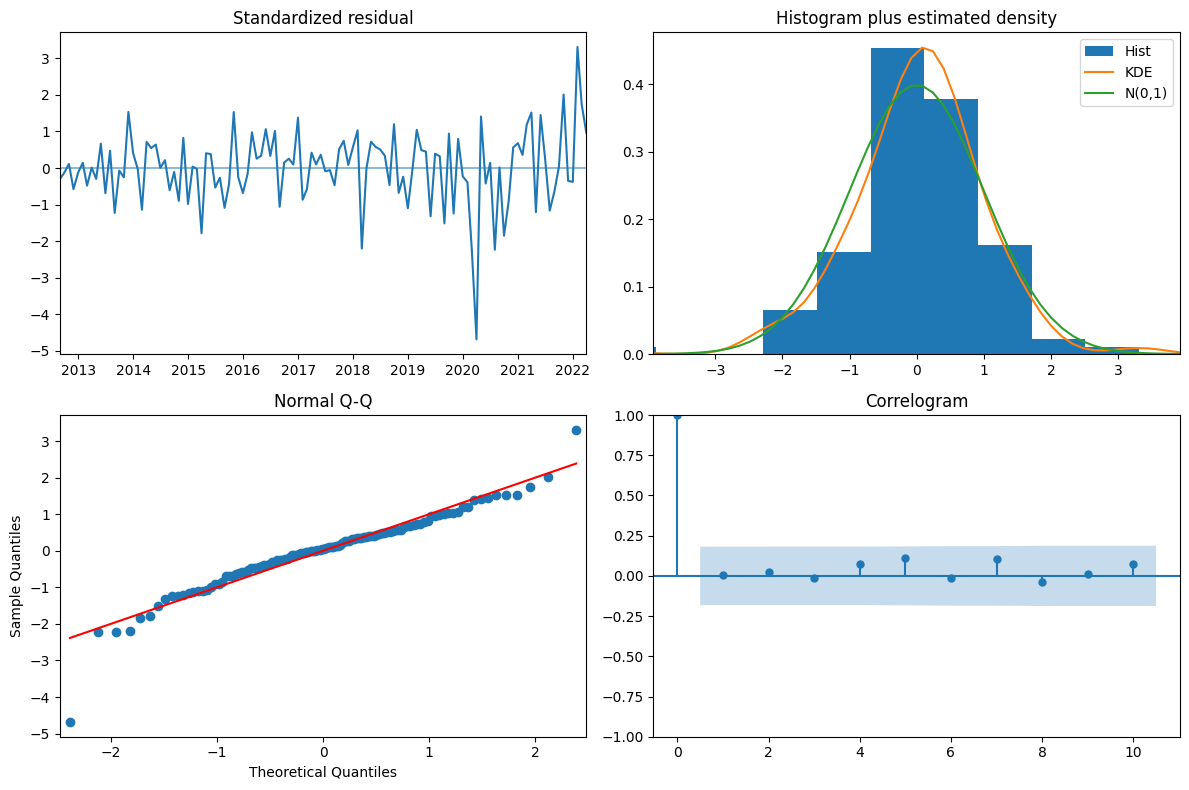

In [1632]:
model.plot_diagnostics(figsize=(12, 8)); plt.tight_layout(); plt.show()

---

The evidence from this model does not support the idea that oil prices significantly affect the XOM stock price, nor does it suggest that there are significant long-term effects based on the lag structure you used.

We fail to reject the first hypothesis (oil prices affect the stock), but the data does not show strong evidence in favor of it.

We reject the second hypothesis (short vs long-term effects differ) based on the insignificance of long-term effects in our results.

---

In [1636]:
dt_sp500_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 125 entries, 2012-04-30 to 2022-08-31
Freq: ME
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BKR     125 non-null    float64
 1   COP     125 non-null    float64
 2   CVX     125 non-null    float64
 3   HAL     125 non-null    float64
 4   MPC     125 non-null    float64
 5   OXY     125 non-null    float64
 6   PSX     125 non-null    float64
 7   SLB     125 non-null    float64
 8   VLO     125 non-null    float64
 9   XOM     125 non-null    float64
 10  BNO     125 non-null    float64
 11  TIP     125 non-null    float64
dtypes: float64(12)
memory usage: 16.8 KB


In [1644]:
common_start = '2012-04-30'
common_end = '2022-03-31'
bkr_aligned = dt_sp500_train['BKR'].loc[common_start:common_end]
oil_aligned = dt_oil_train['Price'].loc[common_start:common_end]
oil_aligned_df = oil_aligned.to_frame()  
order = {'Price': list(range(1, 10))}  
model = ARDL(endog=bkr_aligned, exog=oil_aligned_df, lags=10, order=order).fit()
print(model.summary())

                              ARDL Model Results                              
Dep. Variable:                    BKR   No. Observations:                  120
Model:                    ARDL(10, 9)   Log Likelihood                -226.146
Method:               Conditional MLE   S.D. of innovations              1.891
Date:                Sat, 19 Apr 2025   AIC                            494.293
Time:                        08:13:25   BIC                            551.003
Sample:                    02-28-2013   HQIC                           517.295
                         - 03-31-2022                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1628      1.126      1.033      0.304      -1.074       3.400
BKR.L1         1.2196      0.136      8.981      0.000       0.950       1.489
BKR.L2        -0.2929      0.200     -1.462      0.1

---
Based on the p-values, we fail to reject both hypotheses:

Oil prices do not seem to significantly affect BKR stock prices in this model.

There's no significant evidence to suggest a short-term vs long-term difference in effects, as none of the lags are significant.

---

In [1648]:
common_start = '2012-04-30'
common_end = '2022-03-31'
cop_aligned = dt_sp500_train['COP'].loc[common_start:common_end]
oil_aligned = dt_oil_train['Price'].loc[common_start:common_end]
oil_aligned_df = oil_aligned.to_frame()  
order = {'Price': list(range(1, 10))}  
model = ARDL(endog=cop_aligned, exog=oil_aligned_df, lags=10, order=order).fit()
print(model.summary())

                              ARDL Model Results                              
Dep. Variable:                    COP   No. Observations:                  120
Model:                    ARDL(10, 9)   Log Likelihood                -288.727
Method:               Conditional MLE   S.D. of innovations              3.340
Date:                Sat, 19 Apr 2025   AIC                            619.454
Time:                        08:16:42   BIC                            676.164
Sample:                    02-28-2013   HQIC                           642.456
                         - 03-31-2022                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8183      2.712      0.671      0.504      -3.569       7.206
COP.L1         1.2193      0.153      7.944      0.000       0.914       1.524
COP.L2        -0.5026      0.223     -2.253      0.0

---
For COP (ConocoPhillips), based on our results, we should fail to reject both hypotheses:

Oil prices do not significantly affect COP stock prices in this model.

No clear short-term vs long-term effect can be identified, as the significance is inconsistent across the lags.

In summary, oil price does not appear to have a statistically significant impact on COP (ConocoPhillips) stock price.

---

## General to Specific Approach

In [1683]:
order = {'Price': [1, 2, 5, 8]} 
model = ARDL(endog=cop_aligned, exog=oil_aligned_df, lags=10, order=order).fit()
print(model.summary())

                              ARDL Model Results                              
Dep. Variable:                    COP   No. Observations:                  120
Model:                    ARDL(10, 8)   Log Likelihood                -291.992
Method:               Conditional MLE   S.D. of innovations              3.440
Date:                Sat, 19 Apr 2025   AIC                            615.984
Time:                        08:31:32   BIC                            659.192
Sample:                    02-28-2013   HQIC                           633.510
                         - 03-31-2022                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9670      2.660      1.115      0.267      -2.314       8.248
COP.L1         1.2275      0.150      8.164      0.000       0.929       1.526
COP.L2        -0.5023      0.193     -2.601      0.0

## Cointegration Testing

Cointegration testing is used to examine whether two or more time series are linked in such a way that they share a common long-term equilibrium relationship. This is particularly useful when dealing with non-stationary data, such as stock prices or economic variables like oil prices. Even if individual time series are non-stationary (i.e., their means and variances change over time), they may still have a stable long-run relationship. In such cases, the series are said to be cointegrated.

Why is Cointegration Important?
Cointegration suggests that there is a long-term relationship between the variables, even if the individual time series are non-stationary.

In econometrics, cointegration is essential because it allows for modeling relationships between non-stationary variables without causing spurious results.

Types of Cointegration Tests:
Engle-Granger Two-Step Method: This is a simple method where you first test for the existence of a long-term relationship by running a regression of one time series on another. The residuals from this regression are then tested for stationarity using an Augmented Dickey-Fuller (ADF) test.

Johansen Cointegration Test: This is a more advanced method that tests for multiple cointegrating relationships among several time series.

In [1658]:
from statsmodels.tsa.stattools import coint

In [1665]:
common_start = '2012-04-30'
common_end = '2022-03-31'
# cop_aligned = dt_sp500_train['COP'].loc[common_start:common_end]
# oil_aligned = dt_oil_train['Price'].loc[common_start:common_end]
# oil_aligned_df = oil_aligned.to_frame()  

x = dt_oil['Price'].loc[common_start:common_end]
y = dt_sp500['XOM'].loc[common_start:common_end]

# Perform Cointegration Test
score, p_value, _ = coint(x, y)

# Print the p-value
print(f'Cointegration p-value: {p_value}')

Cointegration p-value: 0.5651936457908278


Interpretation:

If the p-value is less than 0.05, you reject the null hypothesis (no cointegration), indicating that the two time series are cointegrated (i.e., they have a long-term relationship).

If the p-value is greater than 0.05, you fail to reject the null hypothesis, suggesting no cointegration between the series.

In [1667]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [1673]:
common_start = '2012-04-30'
common_end = '2022-03-31'
x = dt_oil['Price'].loc[common_start:common_end]
y = dt_sp500['XOM'].loc[common_start:common_end]

data = pd.concat([x, y], axis=1)
# Perform Johansen Cointegration Test
johansen_test = coint_johansen(data, det_order=0, k_ar_diff=4) 
print(f"Trace Statistic: {johansen_test.trace_stat}")
print(f"Critical Values: {johansen_test.cvt}")

Trace Statistic: [10.7016483   4.62573634]
Critical Values: [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]


Interpretation:

1. **Test for rank = 0**  
   - Trace statistic = 10.70  
   - Critical values: 13.43 (90%), 15.49 (95%), 19.93 (99%)  
   - Since 10.70 < 13.43, we **fail to reject** the null hypothesis of **no cointegration**.

2. **Test for rank ≤ 1**  
   - Trace statistic = 4.63  
   - Critical values: 2.71 (90%), 3.84 (95%), 6.63 (99%)  
   - Since 4.63 > 3.84, we **reject** the null that there is **at most 1 cointegrating relationship**.

In [1699]:
from statsmodels.stats.diagnostic import linear_reset
# reset_test = linear_reset(model, power=2, use_f=True)
# print(reset_test)

In [1697]:
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
# bp = het_breuschpagan(model_s12_ar2_i_ma1.fit().resid)
# white = het_white(model_s12_ar2_i_ma1.fit().resid)

In [1713]:
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
bg = acorr_breusch_godfrey(model_s12_ar2_i_ma1.fit(), nlags=4)

In [1711]:
bg

(1.7562073314271884,
 0.7804839629472726,
 0.42924629769155265,
 0.7873266386049271)

In [1721]:
model_ar4_i_ma3.fit().aic

14467.810639850857

In [1723]:
model_ar4_i_ma3.fit().bic

14519.03925156789

In [1729]:
model.aic # this is for ARDL

572.9078381653067

In [1733]:
model.bic # this is for ARDL

629.6179258469474

In [1747]:
print(f'ARIMA LLR: {model_ar4_i_ma3.fit().llf}')
print(f'ARLD LLR: {model.llf}')

ARIMA LLR: -7225.905319925429
ARLD LLR: -265.45391908265333


In [1753]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# import numpy as np

# def mean_absolute_percentage_error(y_true, y_pred):
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# rmse_ardl = mean_squared_error(y_true, y_pred_ardl, squared=False)
# mae_ardl = mean_absolute_error(y_true, y_pred_ardl)
# mape_ardl = mean_absolute_percentage_error(y_true, y_pred_ardl)

# rmse_arima = mean_squared_error(y_true, y_pred_arima, squared=False)
# mae_arima = mean_absolute_error(y_true, y_pred_arima)
# mape_arima = mean_absolute_percentage_error(y_true, y_pred_arima)

# print("ARDL RMSE:", rmse_ardl)
# print("ARDL MAE:", mae_ardl)
# print("ARDL MAPE:", mape_ardl)

# print("ARIMA RMSE:", rmse_arima)
# print("ARIMA MAE:", mae_arima)
# print("ARIMA MAPE:", mape_arima)